In [218]:
df <- read.csv("../biostats bootcamp 2023.csv", stringsAsFactors = F)
df$race <- as.factor(df$race)
df$discharge_dispsn <- as.factor(df$discharge_dispsn)

options(repr.plot.res = 250) # this changes plotting size within jupyter notebook

# Linear Models

Last class, we covered the ideas and assumptions behind a standard linear regression model.  As a reminder, we are interested in quantifying the association between an outcome variable $y$ and a predictor $x_1$; using our scientific understanding of the problem, we adjust for confounding with variables, say,  $x_2, x_3, x_4$.  This gets turned into the following theoretical probability model:

\begin{align*}
\mu_y(x) &= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 \\
y &= \mu_y(x) + \varepsilon \\
\varepsilon &\sim \text{Normal}(0, \sigma)
\end{align*}

We interpret this model as follows.  Based on each patient's characteristics (i.e. their level of $x$), there is an optimal prediction $\mu_y(x)$ we can make for their outcome $y$; we model this prediction as linear. Then their actual observed $y$ is a random, 0-centered, Normally-distributed fluctuation away from this optimal prediction.  Recall that the variation in this fluctation is assumed to be *the same* for all patients, regardless of their level of $x$. 

With a dataset in hand, we estimate the parameters (i.e. the $\beta$'s) of this probability model using the ordinary least squares (OLS) estimator, which gives us something that looks like the following:
$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + \hat{\beta}_3 x_3 + \hat{\beta}_4 x_4 $$

The primary goal of our analysis is to make an inference over the unknown $\beta_1$, which we do using $\hat{\beta}_1$ and a confidence interval around it or a p-value for the null hypothesis that it is 0.

## Visualization using the Frisch-Waugh-Lowell Theorem
Before I explain this tool, I'm just going to do a quick demonstration of two methods to get the same result for $\hat{\beta}_1$.  For the demonstration, we will seek to establish the relationship between log wbcc_max ($y$) and creatinine_max ($x_1$).  We'll adjust for femalesex, steroid, and sodium_max.  First, the usual linear model.  For simplicitly, we're not going to do anything regarding centering/scaling continuous predictors.

In [54]:
model <- lm(log(wbcc_max) ~ creatinine_max + femalesex + steroid + sodium_max, data = df)
summary(model)


Call:
lm(formula = log(wbcc_max) ~ creatinine_max + femalesex + steroid + 
    sodium_max, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2507 -0.3788 -0.0137  0.3582  4.1953 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -2.061945   0.230981  -8.927  < 2e-16 ***
creatinine_max  0.039177   0.003415  11.472  < 2e-16 ***
femalesex      -0.070408   0.019185  -3.670 0.000246 ***
steroid         0.304315   0.020427  14.898  < 2e-16 ***
sodium_max      0.030427   0.001609  18.906  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5529 on 3411 degrees of freedom
Multiple R-squared:  0.2052,	Adjusted R-squared:  0.2043 
F-statistic: 220.2 on 4 and 3411 DF,  p-value: < 2.2e-16


Second, we'll do things in a slightly more complicated way:

In [55]:
# fit models x1 vs confounders and y vs confounders
model.x1.confounders <- lm(creatinine_max ~ femalesex + steroid + sodium_max, data = df)
model.y.confounders <- lm(log(wbcc_max) ~ femalesex + steroid + sodium_max, data = df)

# extract residuals (i.e. remaining variation after accounting for confounders) for each model
x1.res <- model.x1.confounders$residuals
y.res <- model.y.confounders$residuals 

# fit model y_residualized vs x1_residualized
model <- lm(y.res ~ -1 + x1.res)
summary(model)


Call:
lm(formula = y.res ~ -1 + x1.res)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2507 -0.3788 -0.0137  0.3582  4.1953 

Coefficients:
       Estimate Std. Error t value Pr(>|t|)    
x1.res 0.039177   0.003413   11.48   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5525 on 3415 degrees of freedom
Multiple R-squared:  0.03715,	Adjusted R-squared:  0.03687 
F-statistic: 131.8 on 1 and 3415 DF,  p-value: < 2.2e-16


Notice the coefficient for creatinine_max is exactly the same, as well as the standard error and t-statistic (ignoring small numerical errors).  This time, I ran 3 models.  First, I predicted creatinine_max, my $x_1$, using the confounders.  I set x1.res to the residuals of creatinine_max; the residuals represent the remaining variation in creatinine_max after accounting for the confounders.  Second, I repeated this procedure for log(wbcc_max) to create y.res, removing the variation that can be accounted for by the confounders.  Note that I include intercepts in both models, treating the intercept as another "confounder".  Finally, I fit a model between y.res and x1.res to isolate the effect between $y$ and $x_1$ after accounting for the confounders (which includes the intercept, which is why we removed an intercept from this equation).

The equivalence of the two methods we've shown is guaranteed by the Frisch-Waugh-Lowell Theorem.  But why would anyone choose to take the second, longer way?  We can use the intermediate results to give us a visualization between the only two variables we actually care about.

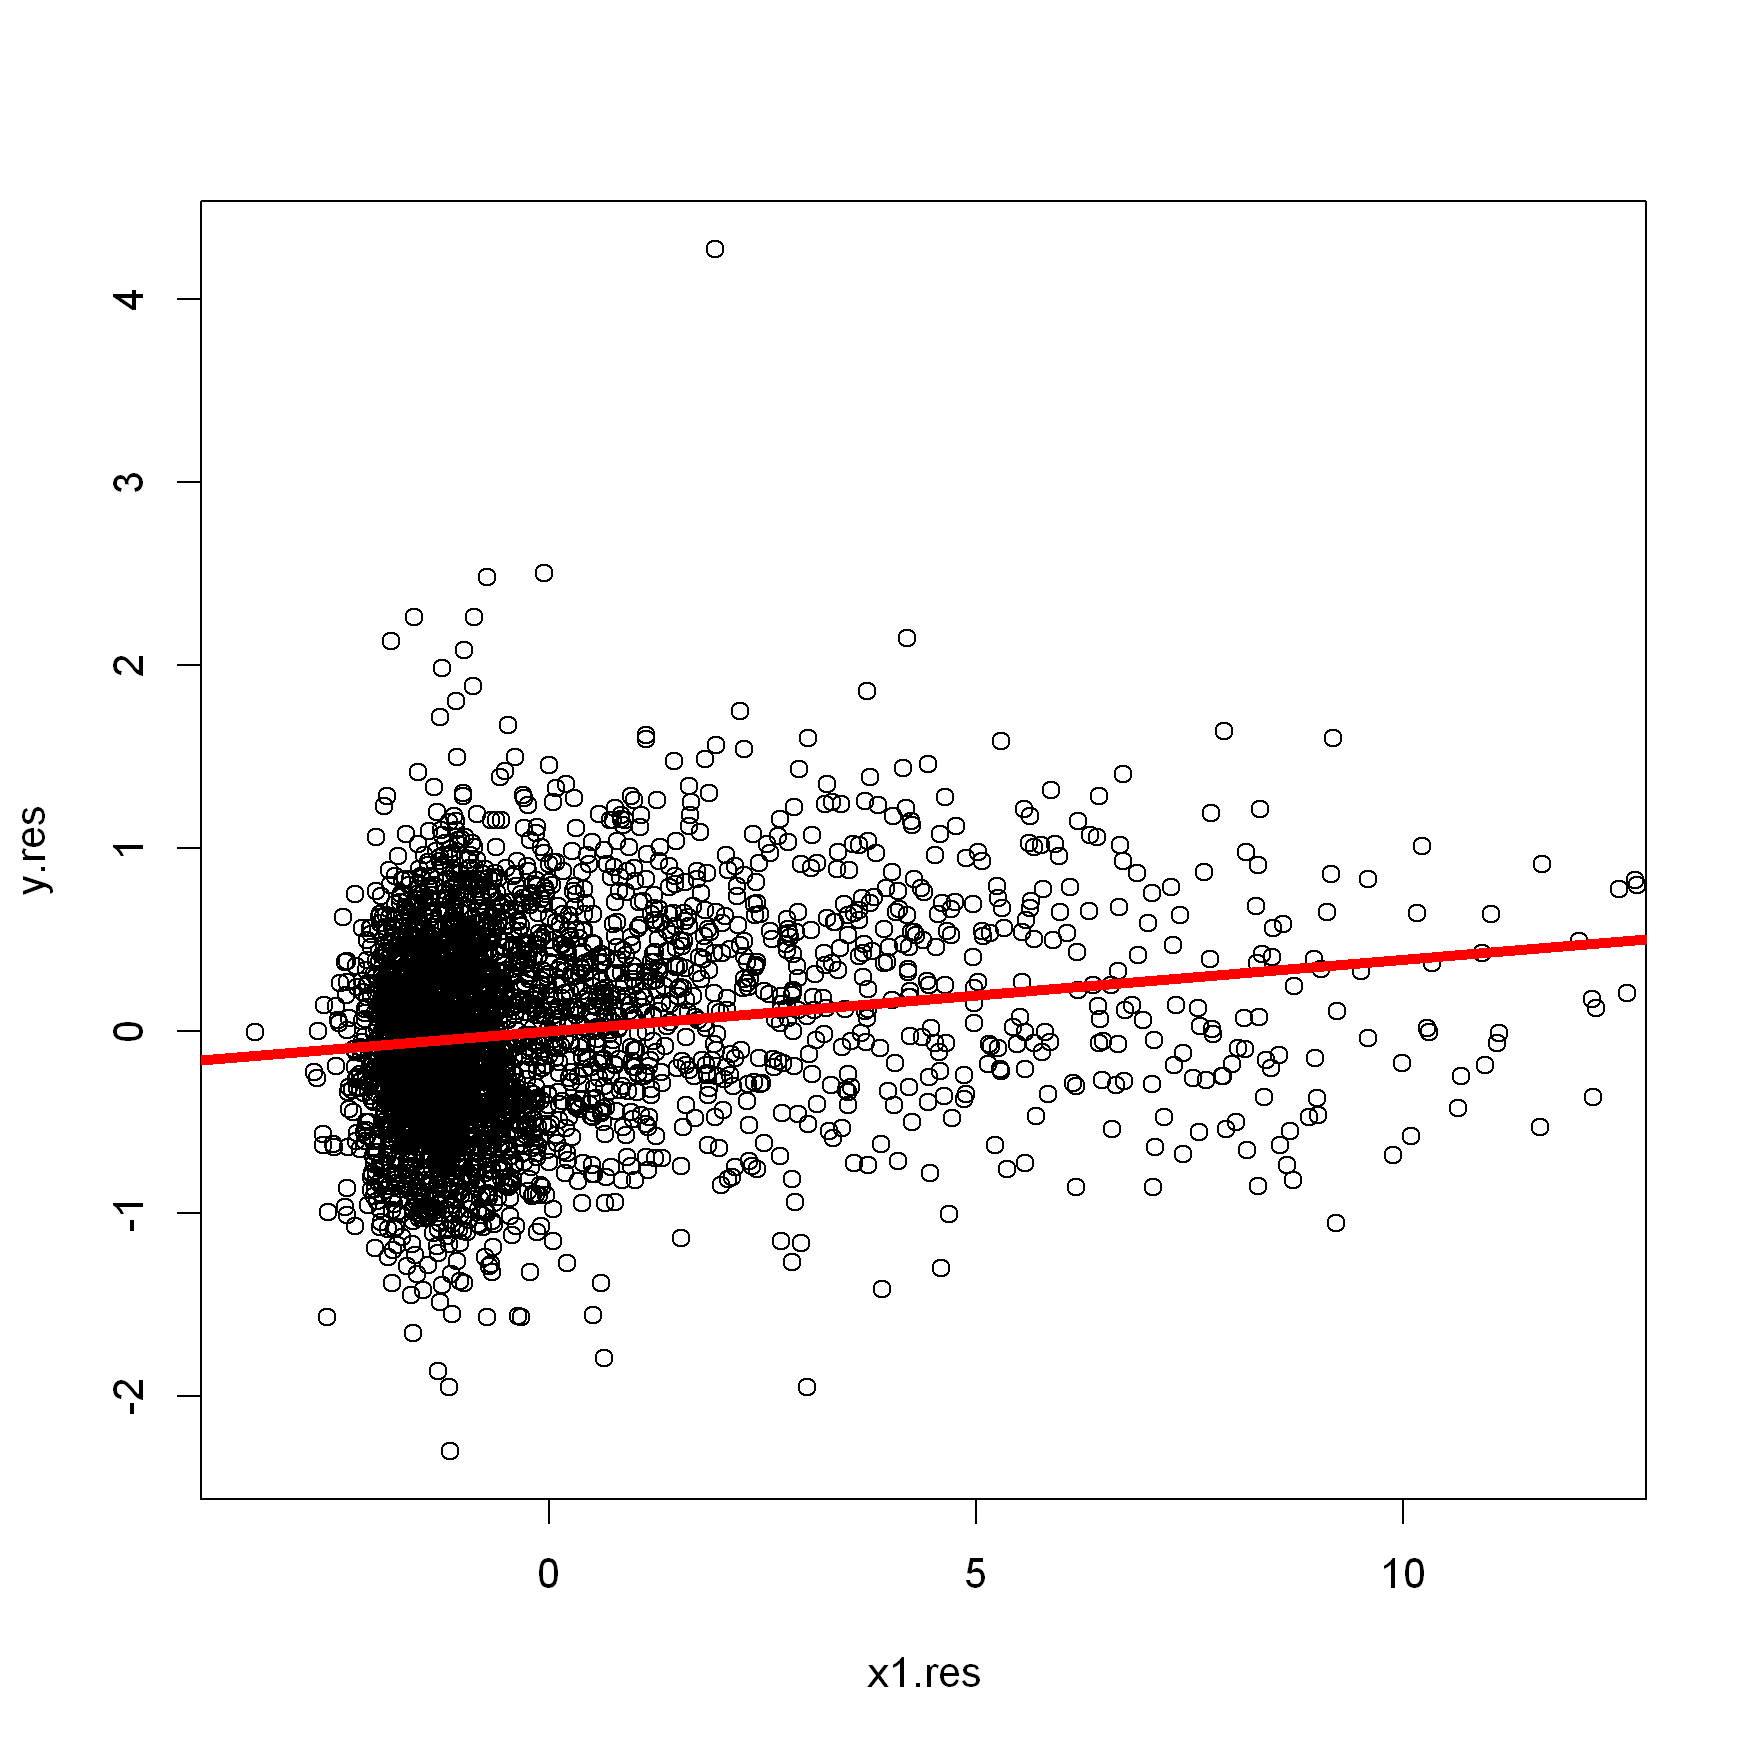

In [56]:
plot(x1.res, y.res,
    xlim = quantile(x1.res, c(0, 0.99)))
abline(a = 0, b = model$coefficients[1], lwd = 4, col = 'red')

This is sort of useful to visualize the true underlying pattern between your $x_1$ and $y$ after accounting for the confounders.  This can further be helpful to identify if the relationship is truly linear and/or if any outliers are overly influencing your model fit.  The drawback of this approach is that the $x$ and $y$ axes lack interpretability, since they now are centered at 0 and only represent "residual variation" after accounting for the confounders.

## Quantile Regression

We have been defining an optimal prediction to be the mean of the outcome at a particular level of $x$.  What if instead, we defined "optimal prediction" to be the median?  The median is just the $0.5$-th quantile.  What if we pushed this further and defined "optimal prediction" as the $\tau$-th quantile where we get to set $\tau$ to whatever we want?  This is the idea behind quantile regression!  For simplicity in the initial exposition, we'll set $\tau = 0.5$, not worrry about adjusting for confounders, and not center/scale continuous variables for interpretability.

Okay, so how do we formalize the model.  We'll start with stating the linear relationship we're positing:
$$Q_{0.5}(x) = \beta_{0} + \beta_{1} x_1 $$
where $Q_{0.5}(x)$ is the median of the outcome at a setting of $x$.  Then $y$ is created using some sort of random fluctuation away from this value. 
$$ y = Q_{0.5}(x) + \varepsilon$$
However, this time the random fluctutations $\varepsilon$ should *not* have a mean of 0.  Our prediction is representing the $\tau$-th quantile, so a proportion of $(1-\tau)$ fluctuations should be positive and a proportion of $\tau$ fluctuations should be negative; this follows from the definition of a quantile.  Since we picked $\tau = 0.5$, this corresponds to half and half.

In terms of the *distribution* of the residuals $\varepsilon$, we won't actually make any further assumptions than above.  We will just rely on our sample size being "sufficiently large" and rely on the central limit theorem (CLT) to give us correct confidence intervals.

Let's see this in action.  We will use the **quantreg** package to run a quantile regression.   We will examine the association between log(wbcc_max) and log(inr_max).

[1] "-------------------------------------------------------------------------------------"



Call:
lm(formula = log(wbcc_max) ~ log(inr_max), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4094 -0.4074 -0.0133  0.4204  4.5367 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.50548    0.01216   206.1   <2e-16 ***
log(inr_max)  0.37295    0.02626    14.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6023 on 3414 degrees of freedom
Multiple R-squared:  0.05579,	Adjusted R-squared:  0.05552 
F-statistic: 201.7 on 1 and 3414 DF,  p-value: < 2.2e-16


[1] "-------------------------------------------------------------------------------------"



Call: rq(formula = log(wbcc_max) ~ log(inr_max), tau = 0.5, data = df)

tau: [1] 0.5

Coefficients:
             Value     Std. Error t value   Pr(>|t|) 
(Intercept)    2.48008   0.01487  166.77497   0.00000
log(inr_max)   0.43650   0.04059   10.75318   0.00000

[1] "-------------------------------------------------------------------------------------"


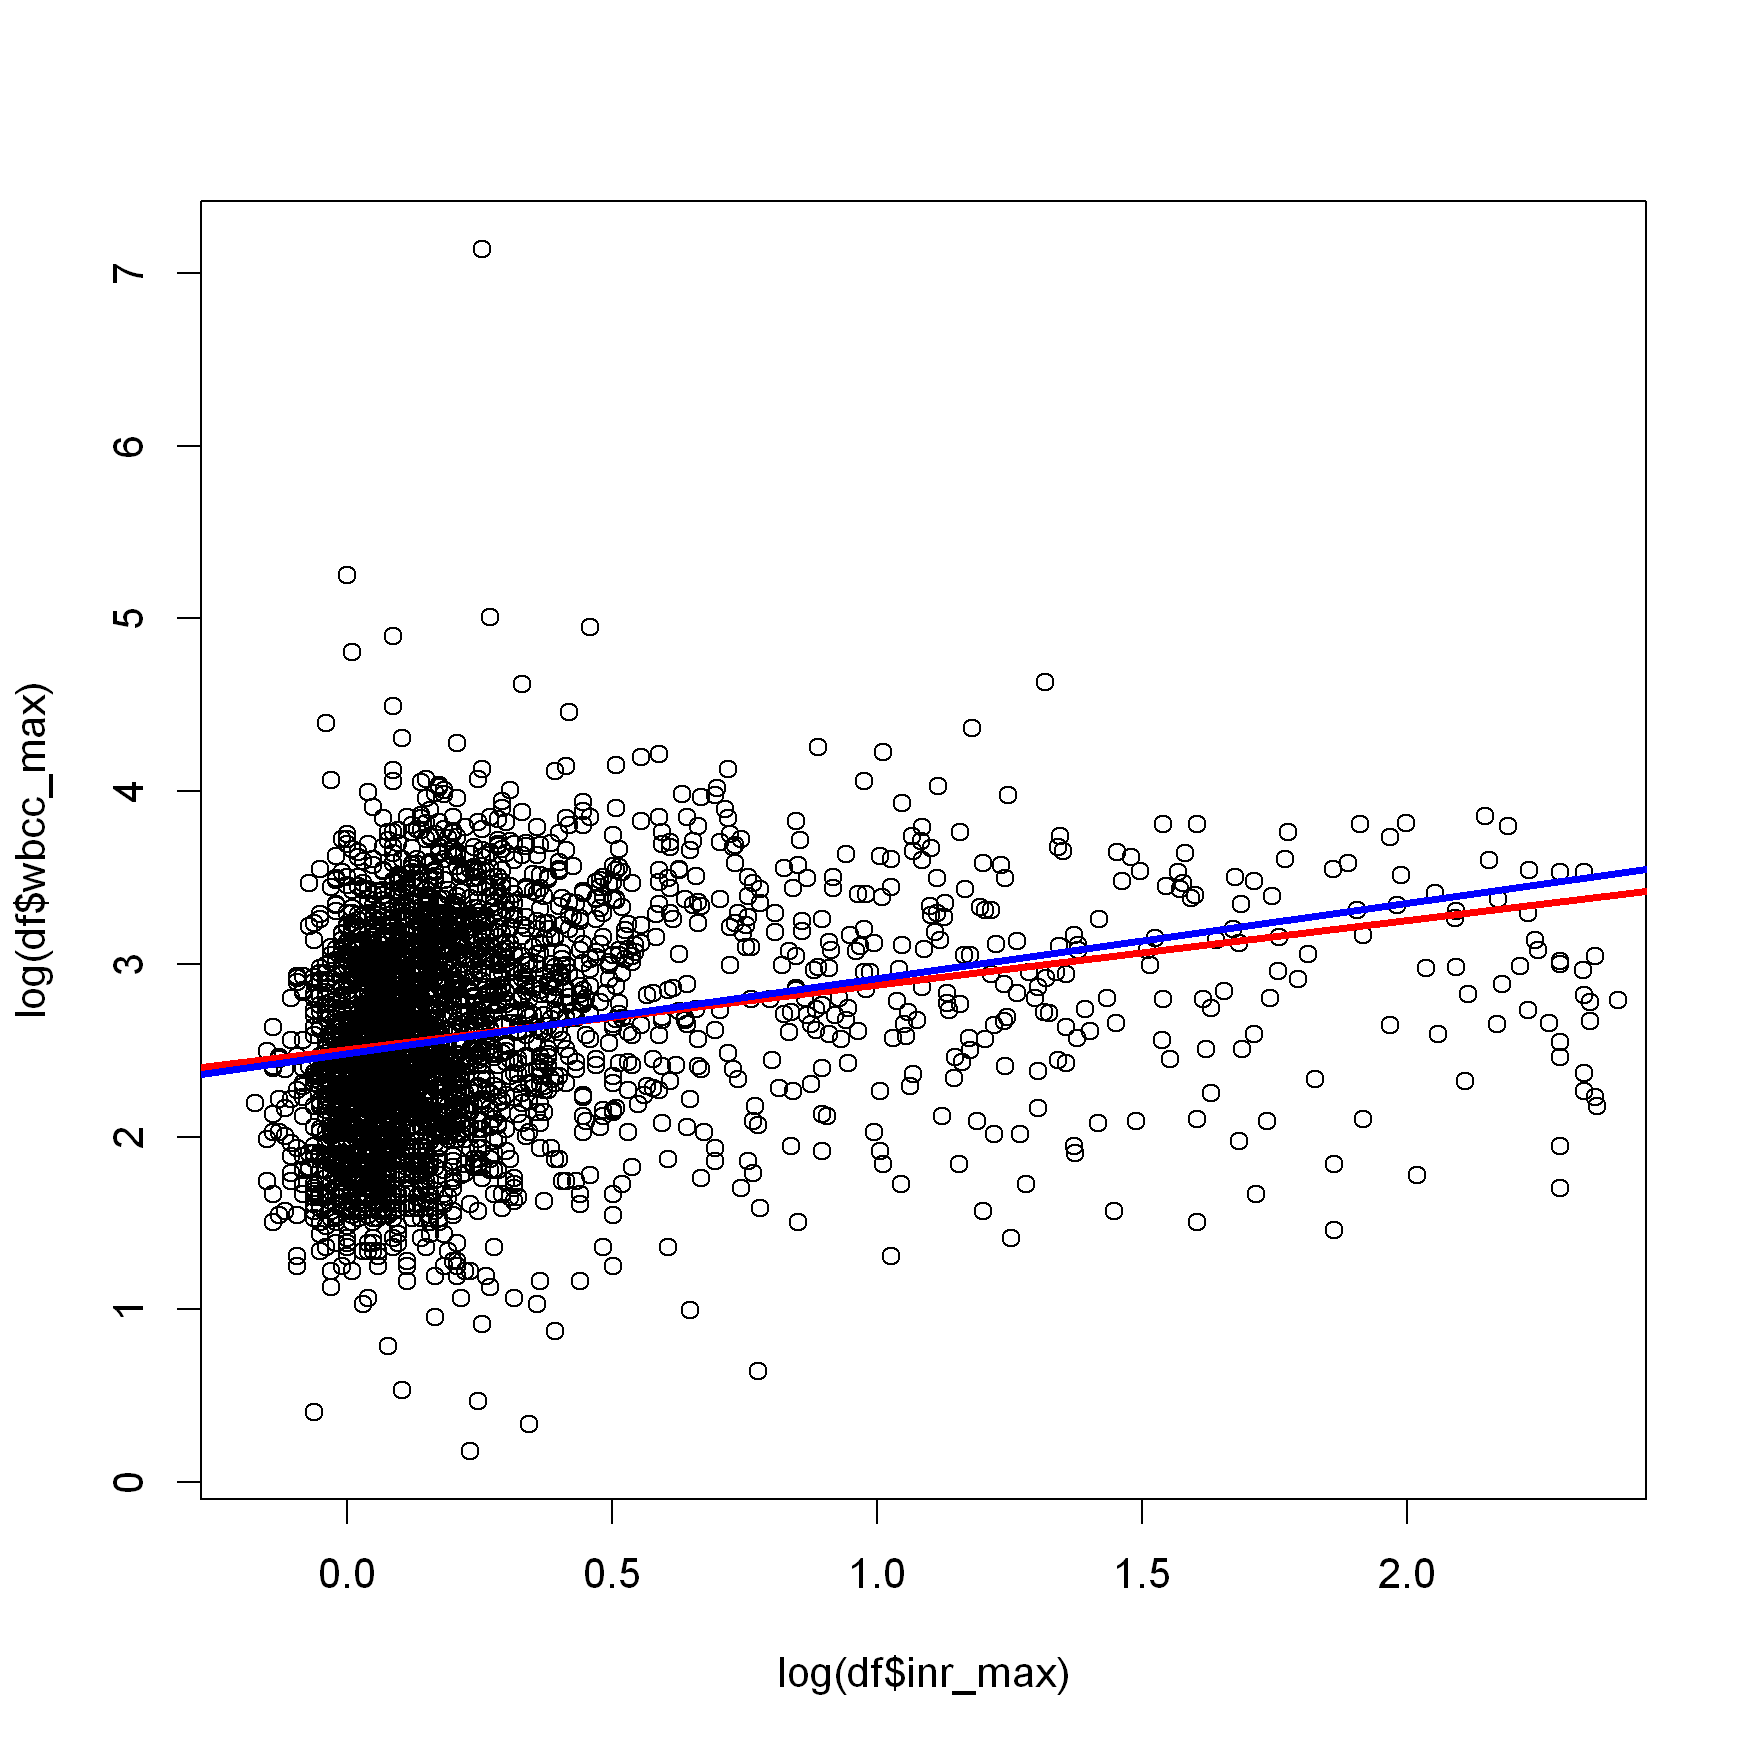

In [136]:
#install.packages("quantreg")
library(quantreg)

# fit a linear model predicting the mean and then the median
model.mean <- lm(log(wbcc_max) ~ log(inr_max), data = df)
model.median <- rq(log(wbcc_max) ~ log(inr_max), data = df, tau = 0.5)

# print results
print('-------------------------------------------------------------------------------------')
summary(model.mean)
print('-------------------------------------------------------------------------------------')
summary(model.median)
print('-------------------------------------------------------------------------------------')

# plot both models
plot(log(df$inr_max), log(df$wbcc_max),
    xlim = quantile(log(df$inr_max), c(0, 0.999)))
abline(a = model.mean$coefficients[1], b = model.mean$coefficients[2], lwd = 3, col = 'red')
abline(a = model.median$coefficients[1], b = model.median$coefficients[2], lwd = 3, col = 'blue')

From the plot, you can see you get pretty similar results.  This means that the errors/residuals are pretty symmetric, since that is the case when the mean equals the median.  However as you can see, they lines are a bit different though, indicating there might be some skew in the residuals.

Another advantage of quantile regression is that it allows you to fit *many* models, one for each choice of the quantile $\tau$.  Therefore, you get many estimates of $\beta_1$, one at each choice of $\tau$.  You can plot this to show how the linear relationship changes across the quantiles.  Lets do this.  We can create a grid of $\tau$ values and pass this over to the **rq** function, and it will fit all the models simultaneously.

In [124]:
# create grid of desired quantiles and print
spacing <- 0.05
tau.grid <- seq(0+spacing, 1-spacing, by = spacing)
print(tau.grid)

# fit all models simultaneously
model.quantiles <- rq(log(wbcc_max) ~ log(inr_max), data = df, tau = tau.grid)
# summary(model.median) # summary would be very long, since one summary per tau value

 [1] 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75
[16] 0.80 0.85 0.90 0.95


Okay let's use the coefficients from our fit model to see how the linear effect size of inr_max changes across quantiles.  Additionally, we'll plot the linear effect measured by the mean model with a red horizontal line, and theat measured by the median with a blue horizontal line.

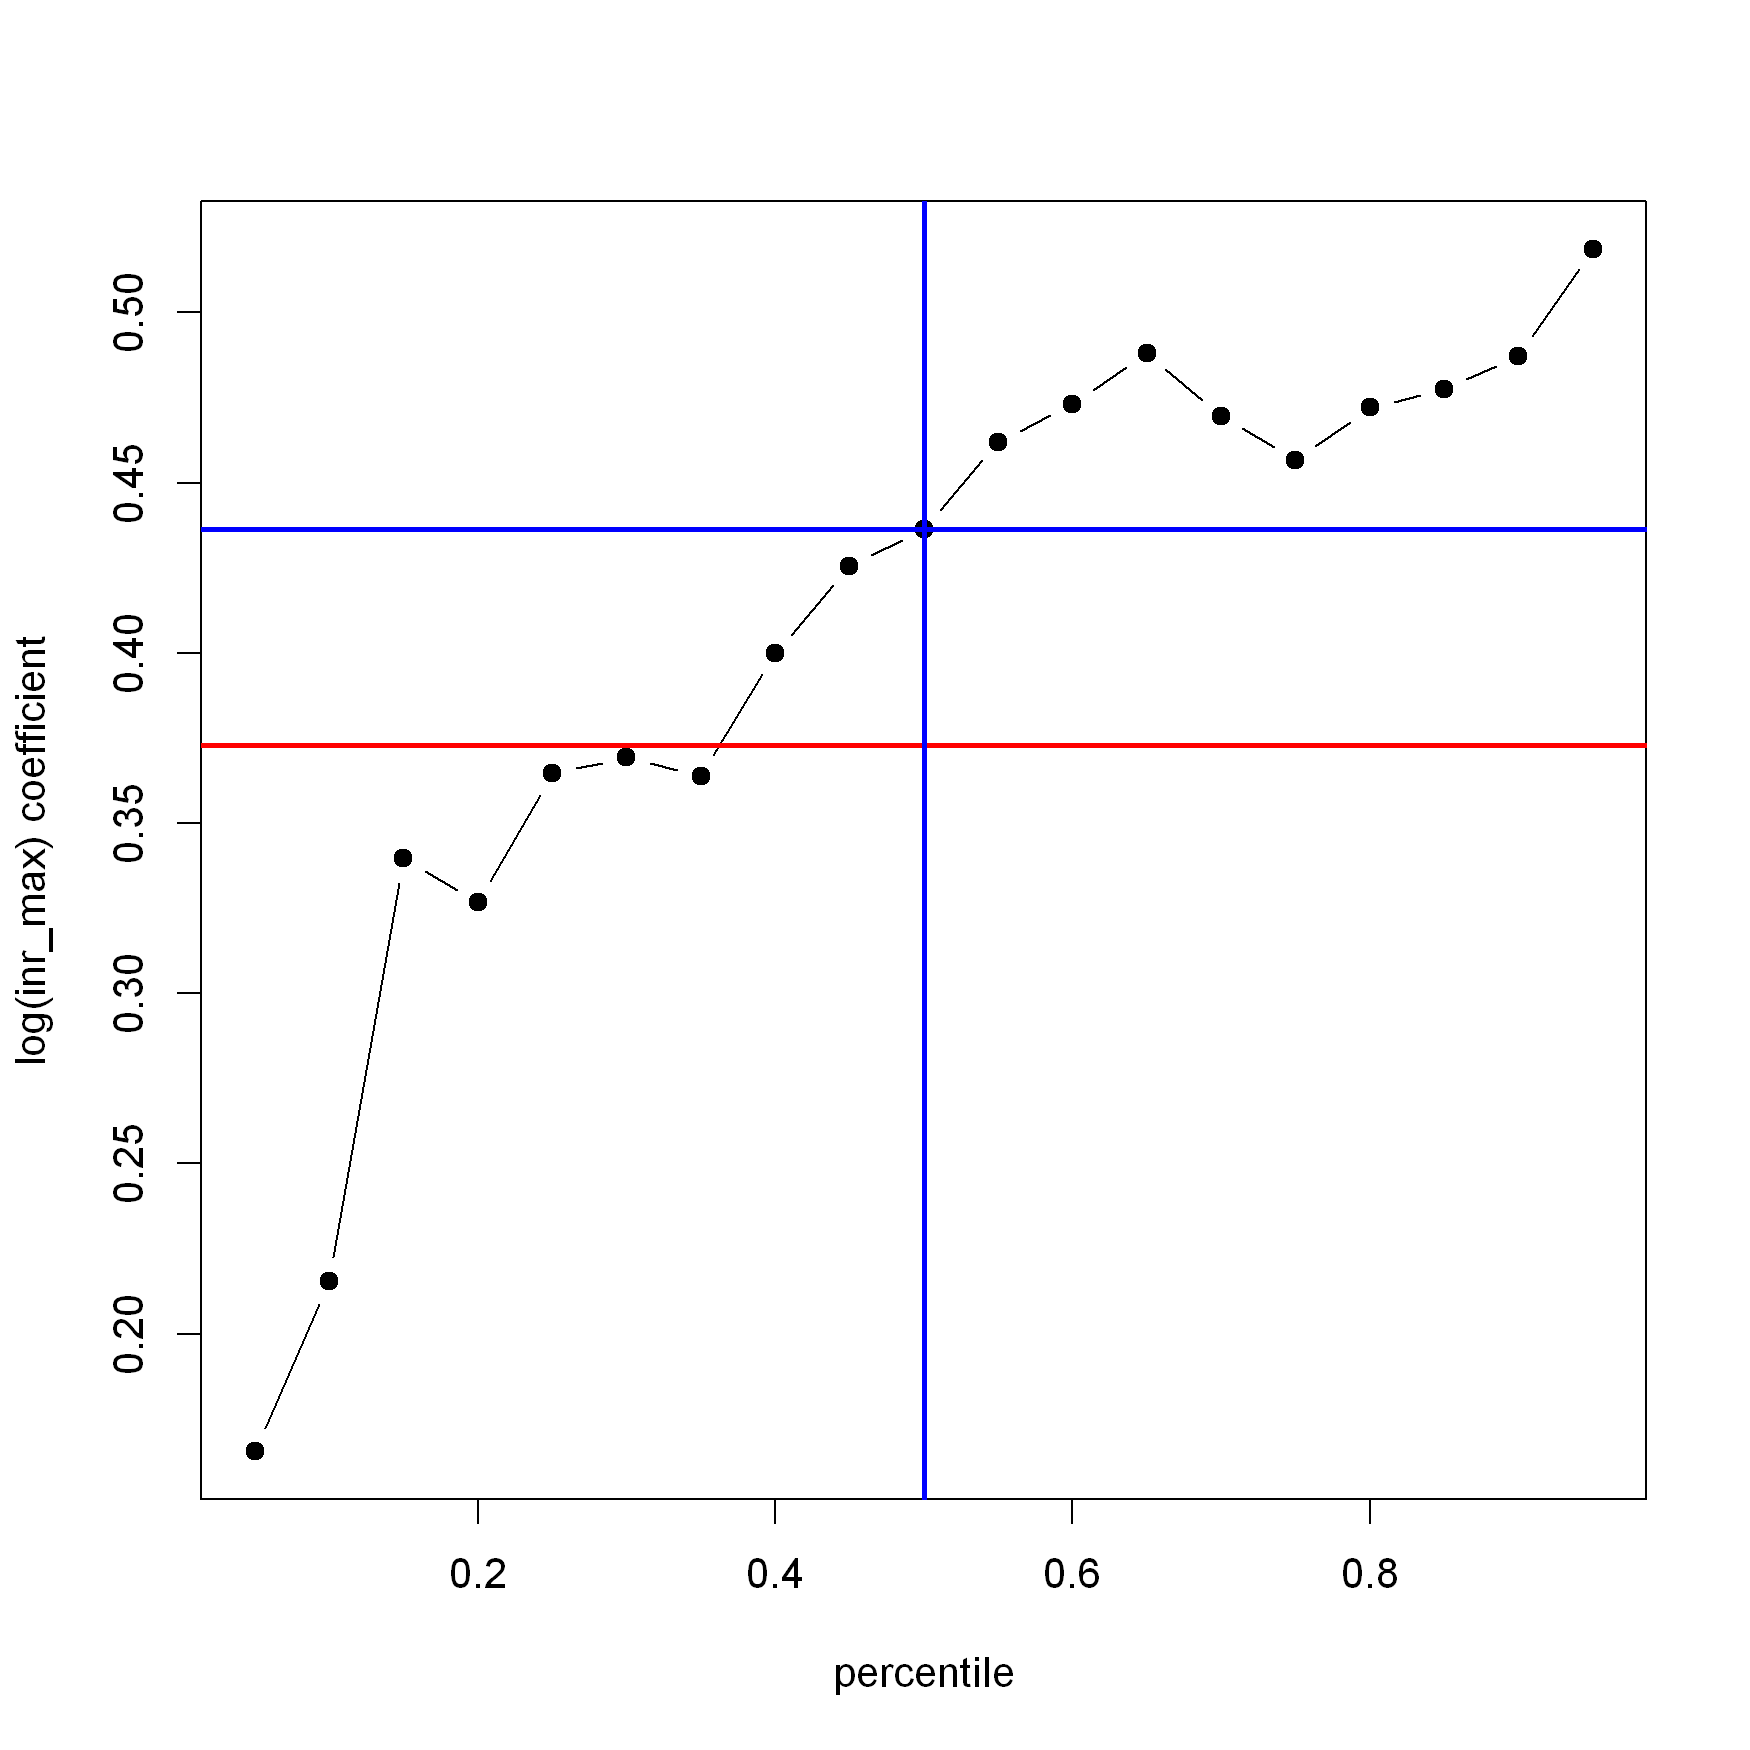

In [149]:
plot(tau.grid, model.quantiles$coefficients[2,], 
     type = 'b', pch = 19, col = 'black',
     xlab = 'percentile',
     ylab = 'log(inr_max) coefficient')
abline(h = model.mean$coefficients[2], col = 'red', lwd = 2)
abline(h = model.median$coefficients[2], col = 'blue', lwd = 2)
abline(v = 0.5, col = 'blue', lwd = 2)

This gives a more detailed story than the simple mean model.  We can see that the linear effect of inr_max increases as the quantile increases. Let's visualize all the fit quantile models at once to help interpret this.  I'll use a color gradient for the different line fits across quantiles, but I'll set the median fit to blue with a fatter line to stand out.

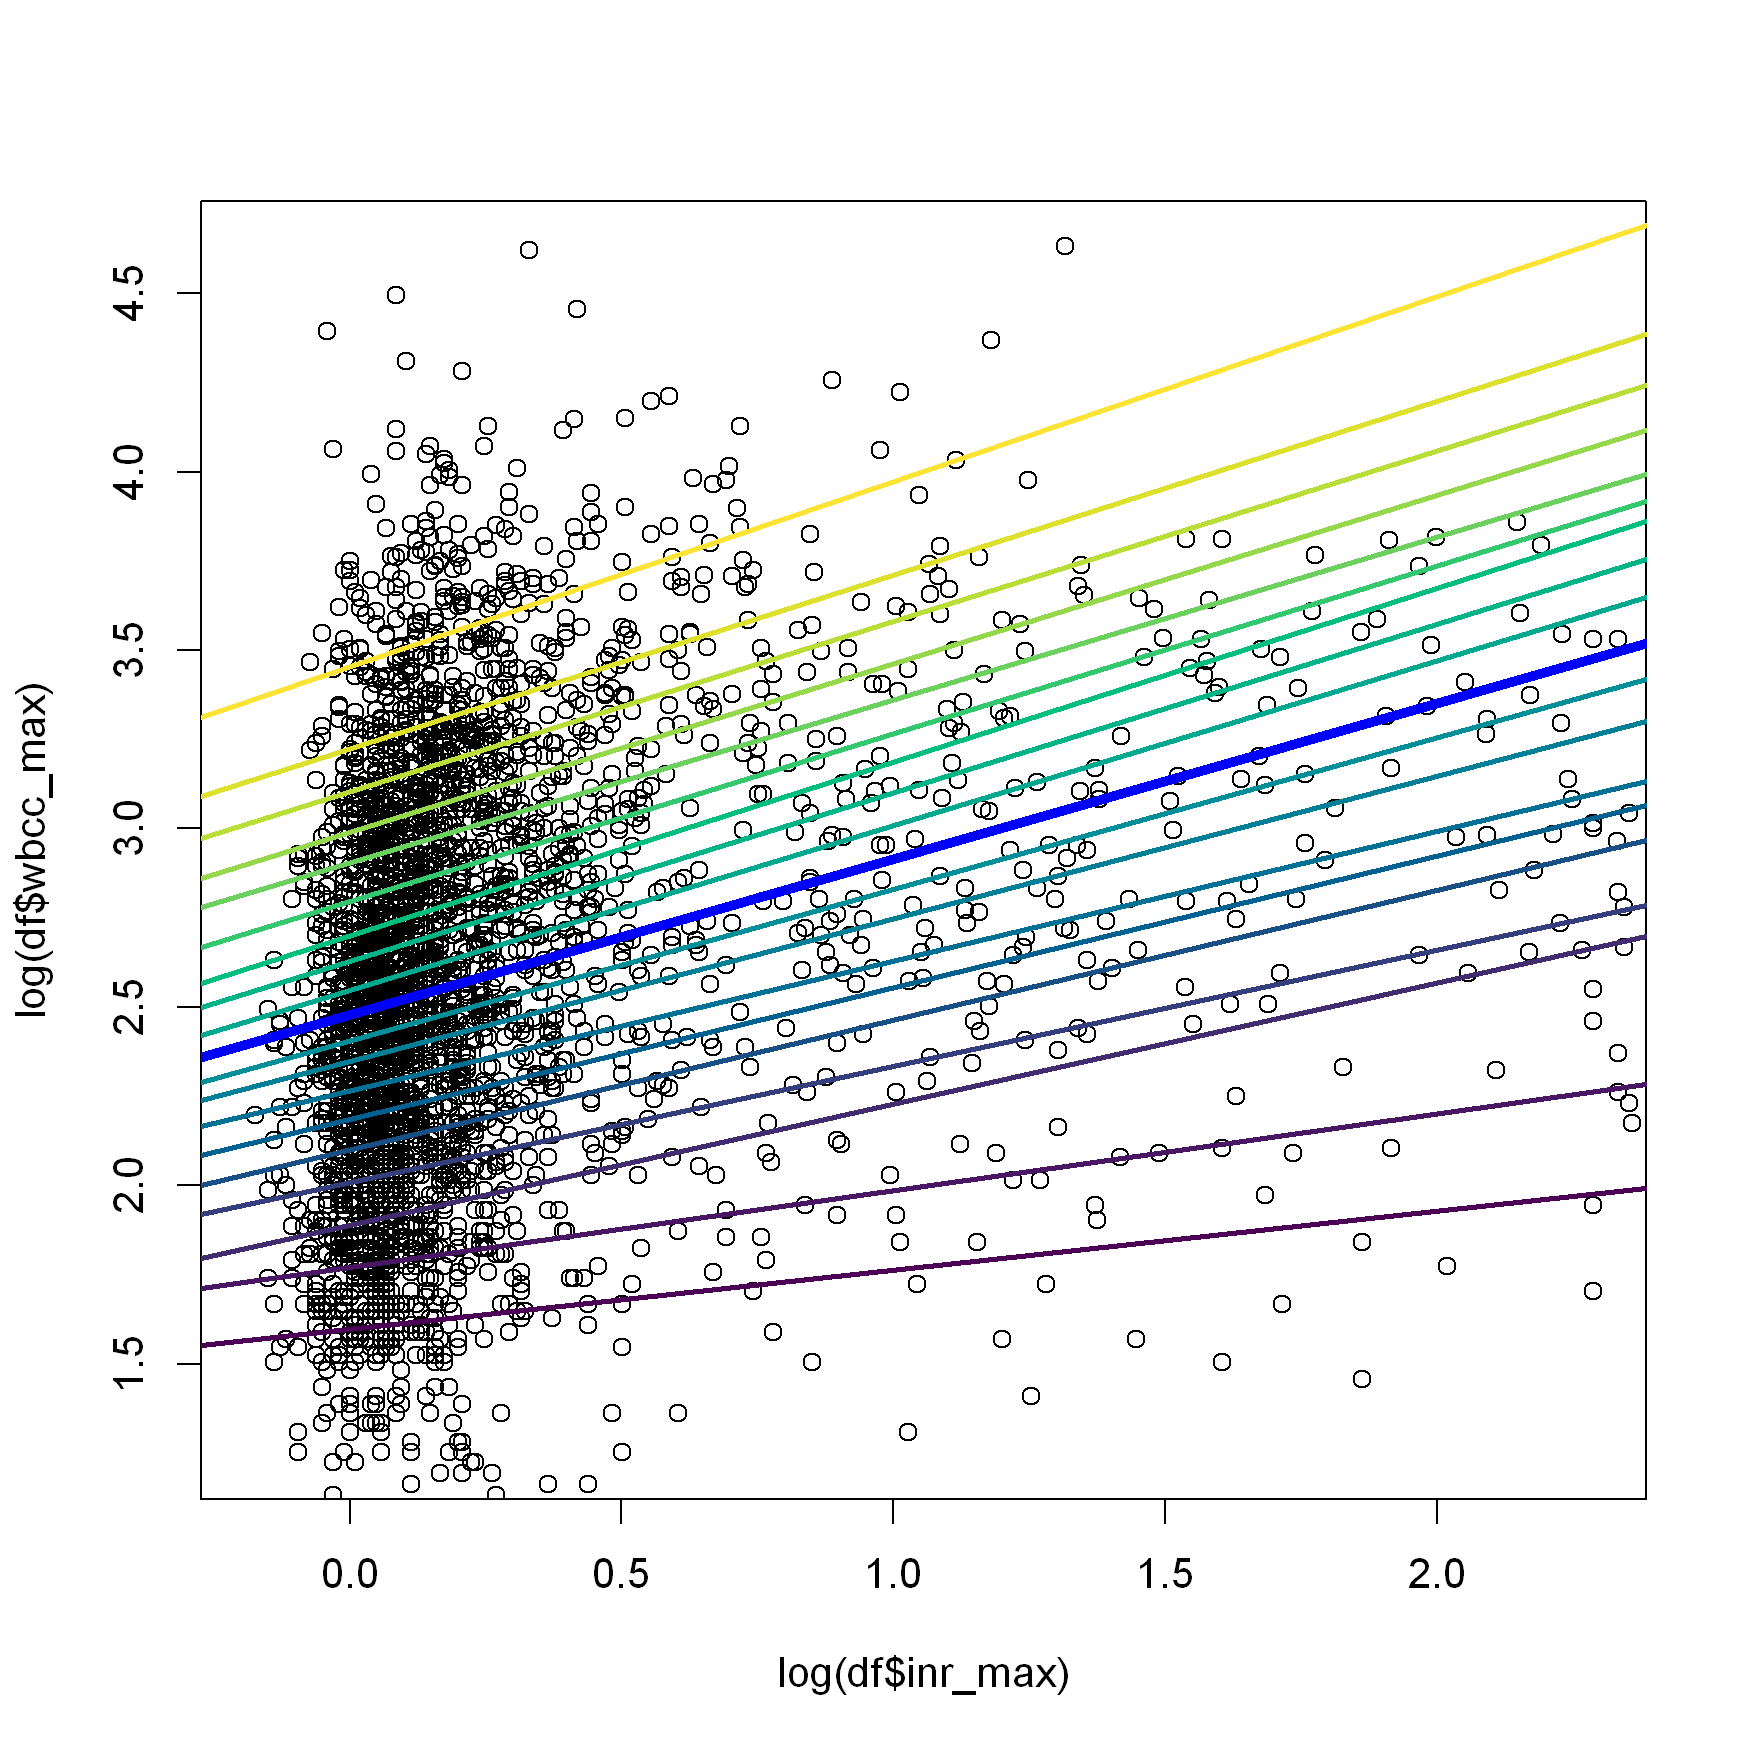

In [145]:
plot(log(df$inr_max), log(df$wbcc_max),
    xlim = quantile(log(df$inr_max), c(0, 0.995)),
    ylim = quantile(log(df$wbcc_max), c(0.01, 0.998)))

palette <- hcl.colors(palette = 'viridis', length(tau.grid))
for (i in 1:length(tau.grid)) {
    col <- ifelse(tau.grid[i] == 0.5, "blue", palette[i])
    lwd <- ifelse(tau.grid[i] == 0.5, 4, 2)
    abline(a = model.quantiles$coefficients[1,i], b = model.quantiles$coefficients[2,i],
          lwd = lwd, col = col)
}

My interpretation of the first plot would have been to say that as $x$ increases, the distribution of $y$ at a level of $x$ becomes slightly more variable and more left-skewed.  This is justified by this second visualization through the following logic. 

- As we move to the right of the second plot, the lines seem to slightly spread out more; this means that the variation in the outcome $y$ gets slightly larger as $x$ increases.  This corresponds to to the increasing trend in the first plot.
- Above the median, the spread of the lines seems to grow only a little with $x$.  This corresponds to the right side of the first plot not changing very much from the median coefficient.  Below the median, the spread of the lines seems to grow more drastically with $x$.   This corresponds to the left side of the first plot changing a lot from the median coefficient. 

Another way to visualize this in your head is to try to take a vertical slice at the left-hand side of the plot.  Then turn that vertical slice horizontally and imagine it as a histogram (use the quantile markers to help).  Then do the same thing for a vertical slice at the right-hand side.  Compare the two "histograms in your head" to come up with conclusions.

Finally, I'll simply note that we can do adjustment and prediction the same way that we saw with the usual (mean) linear regression model.  

# Logistic Regression
Wow, so much functionality for linear models.  If only we could do something similar to model other types of outcomes...

Welcome to the world of **Generalized Linear Models**!  In linear models, we said that at every level of $x$, our outcome $y$ had some Normal distribution (i.e. $y$ = optimal mean prediction using $x$ + Normally distributed random fluctuation).  In generalized linear models, we allow $y$ to have other parametric (read: named) distributions at each level of $x$, and we seek to model the mean of this distribution.

The two most common types of GLMs for biological data are Poisson Regression for count data and **Logistic Regression** for binary data.  For demonstration, we will focus on Logistic Regression, since it's the more important one for medical data.  

## The Model
Logistic regression is used when the outcome is binary.  A binary outcome can be modeled using a Bernoulli distribution as we have discussed.  A Bernoulli distribution has a single parameter $p$, describing the probability of a 1 occurring (vs 0).  $p$ is also the true mean of this distribution.  This should be intuitive: imagine sampling billions of zeros and ones from this distribution and taking the sample mean.  In a logistic regression model, every individual should get their own prediction for a $p$, the mean of their own personal Bernoulli distribution.  We achieve this by proposing a model for $p$ as a function of a patient's covariates $x$.

However, we can't model $p$ linearly as a function of $x$.  $p$ is restricted to take values only in $[0,1]$, and a linear function could produce values outside of this range.  So what do we do?  We can examine a transformation of $p$ such that is allowed to take values in $[-\infty, \infty]$ and then model this *transformed* $p$ linearly with our $x$'s.  Technically, there are an infinite number of transformations that could achieve this, but we pick a very special one for statistical reasons we won't dive into: the log-odds function.  
$$ \log \bigg( \frac{p}{1-p} \bigg) $$
Remember this from Session 2?   Here's a plot of the function.

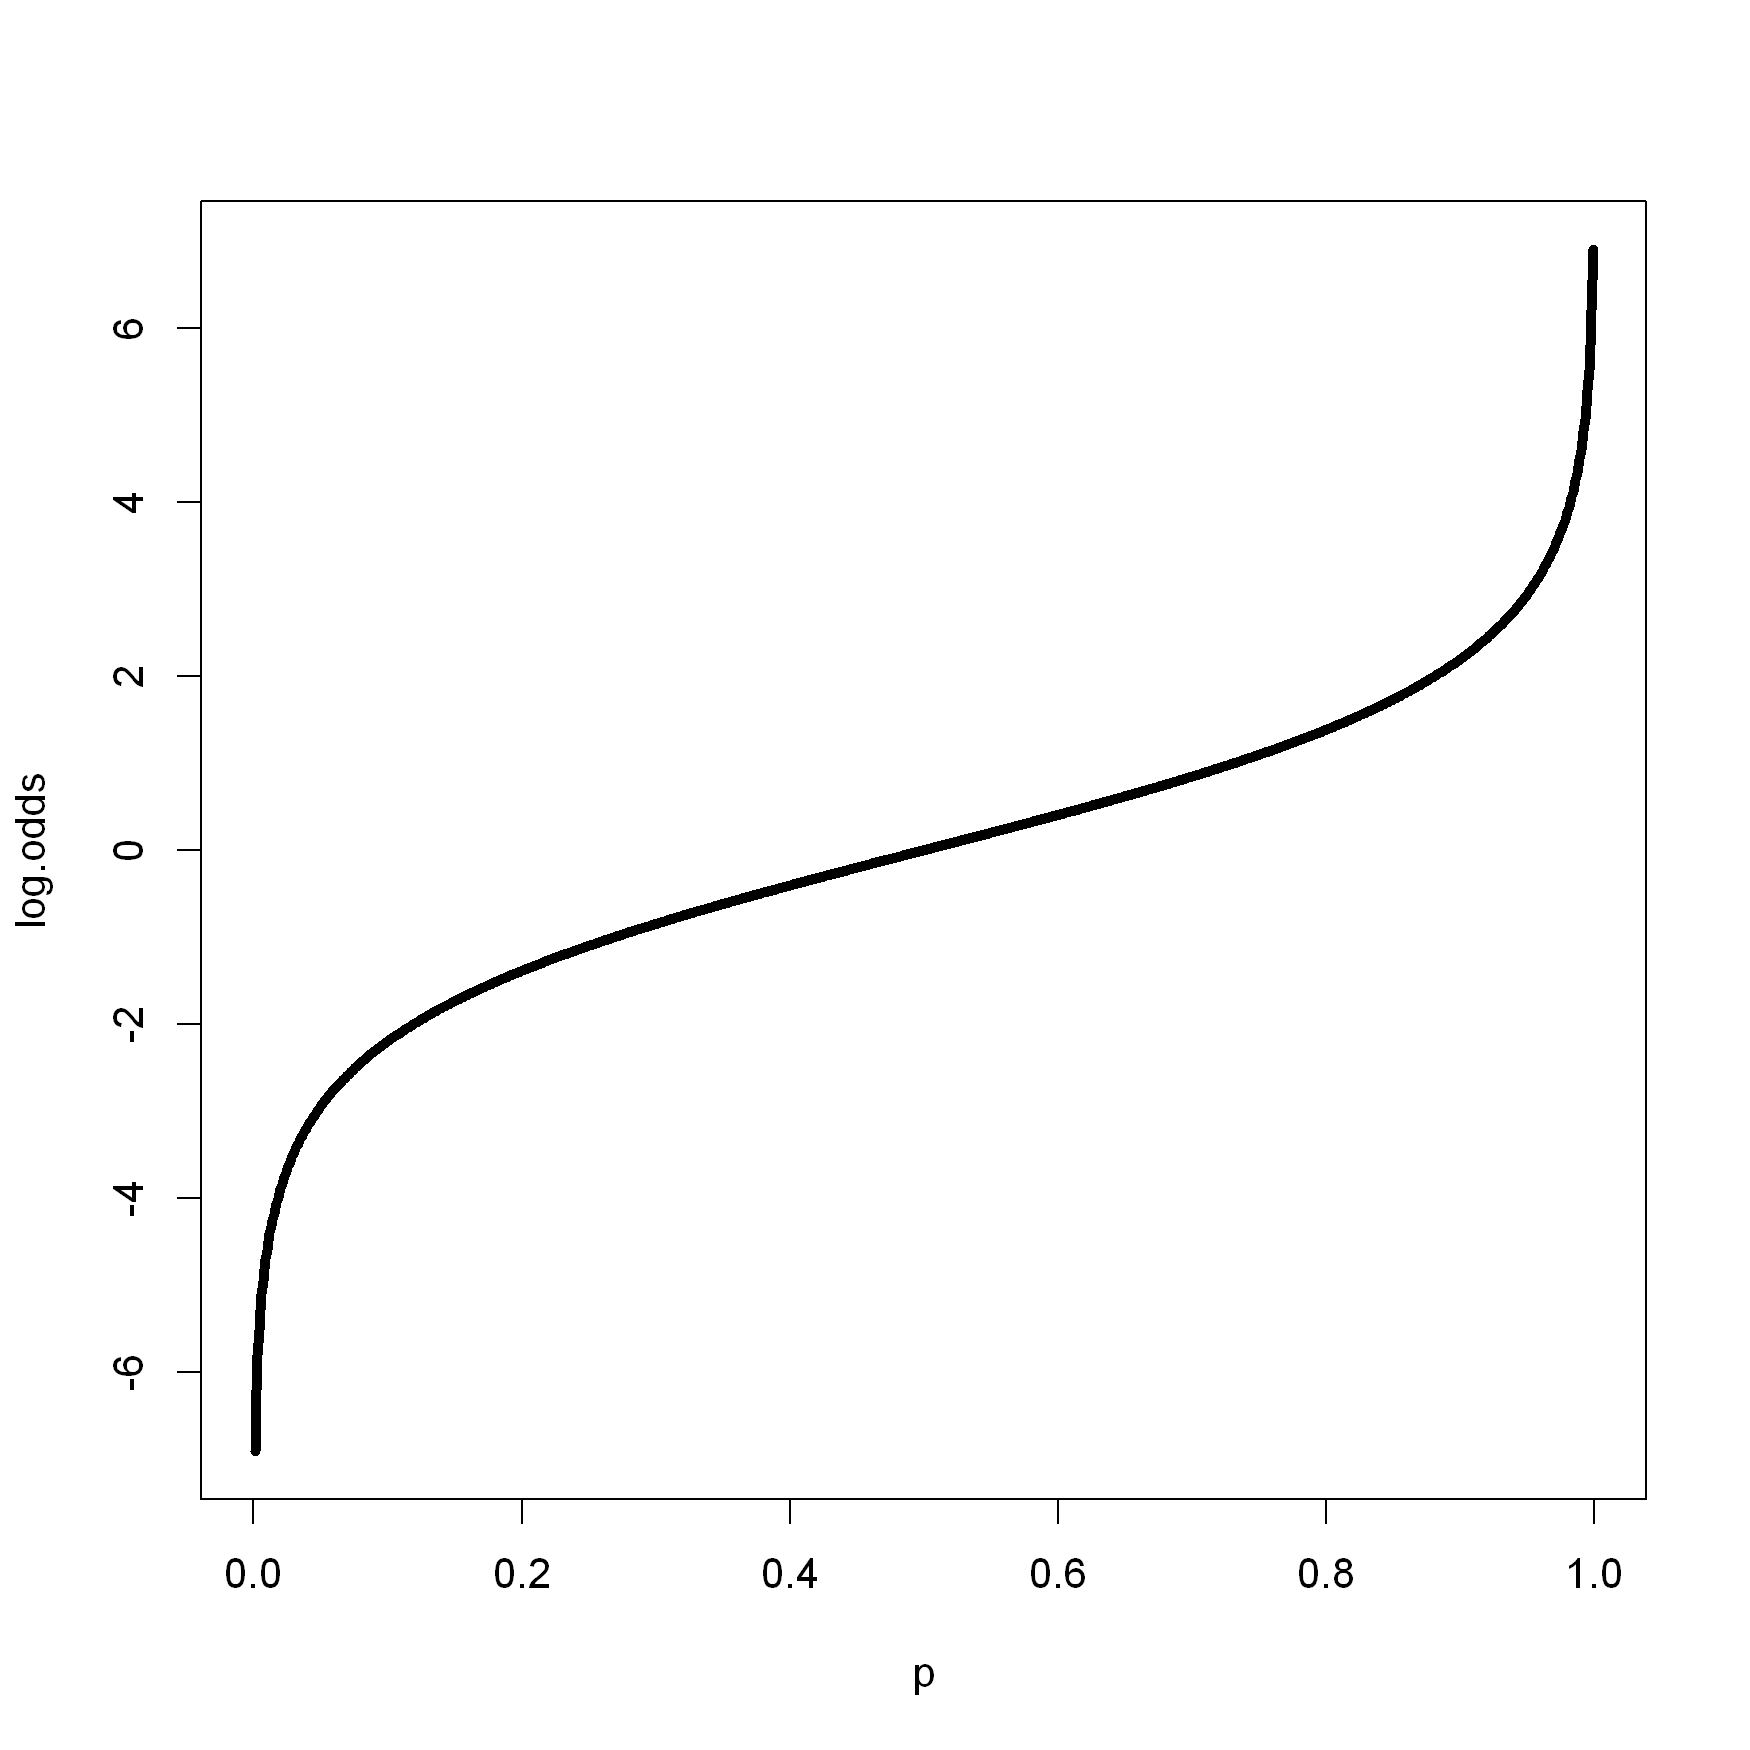

In [105]:
spacing <- 0.001
p <- seq(0+spacing, 1-spacing, by = spacing)
log.odds <- log(p/(1-p))
plot(p, log.odds, 
     type = 'l', lwd = 4)

See how it maps the interval $[0,1]$ into $[-\infty, \infty]$? So in logistic regression, we model the log odds of $p$ to be linear.  In math, it looks like this
$$ \log\bigg( \frac{p}{1-p}\bigg) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 $$
Rearranging, we have
$$ p = \frac{1}{1 + \exp\{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3)\}} \\
= \text{Logistic}(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3)$$
which is why we call this logistic regression.  Here is a corresponding plot of the logistic function.  Since the logistic function is the inverse of the log-odds function, its plot is simply the previous plot reflected across the line $y=x$:

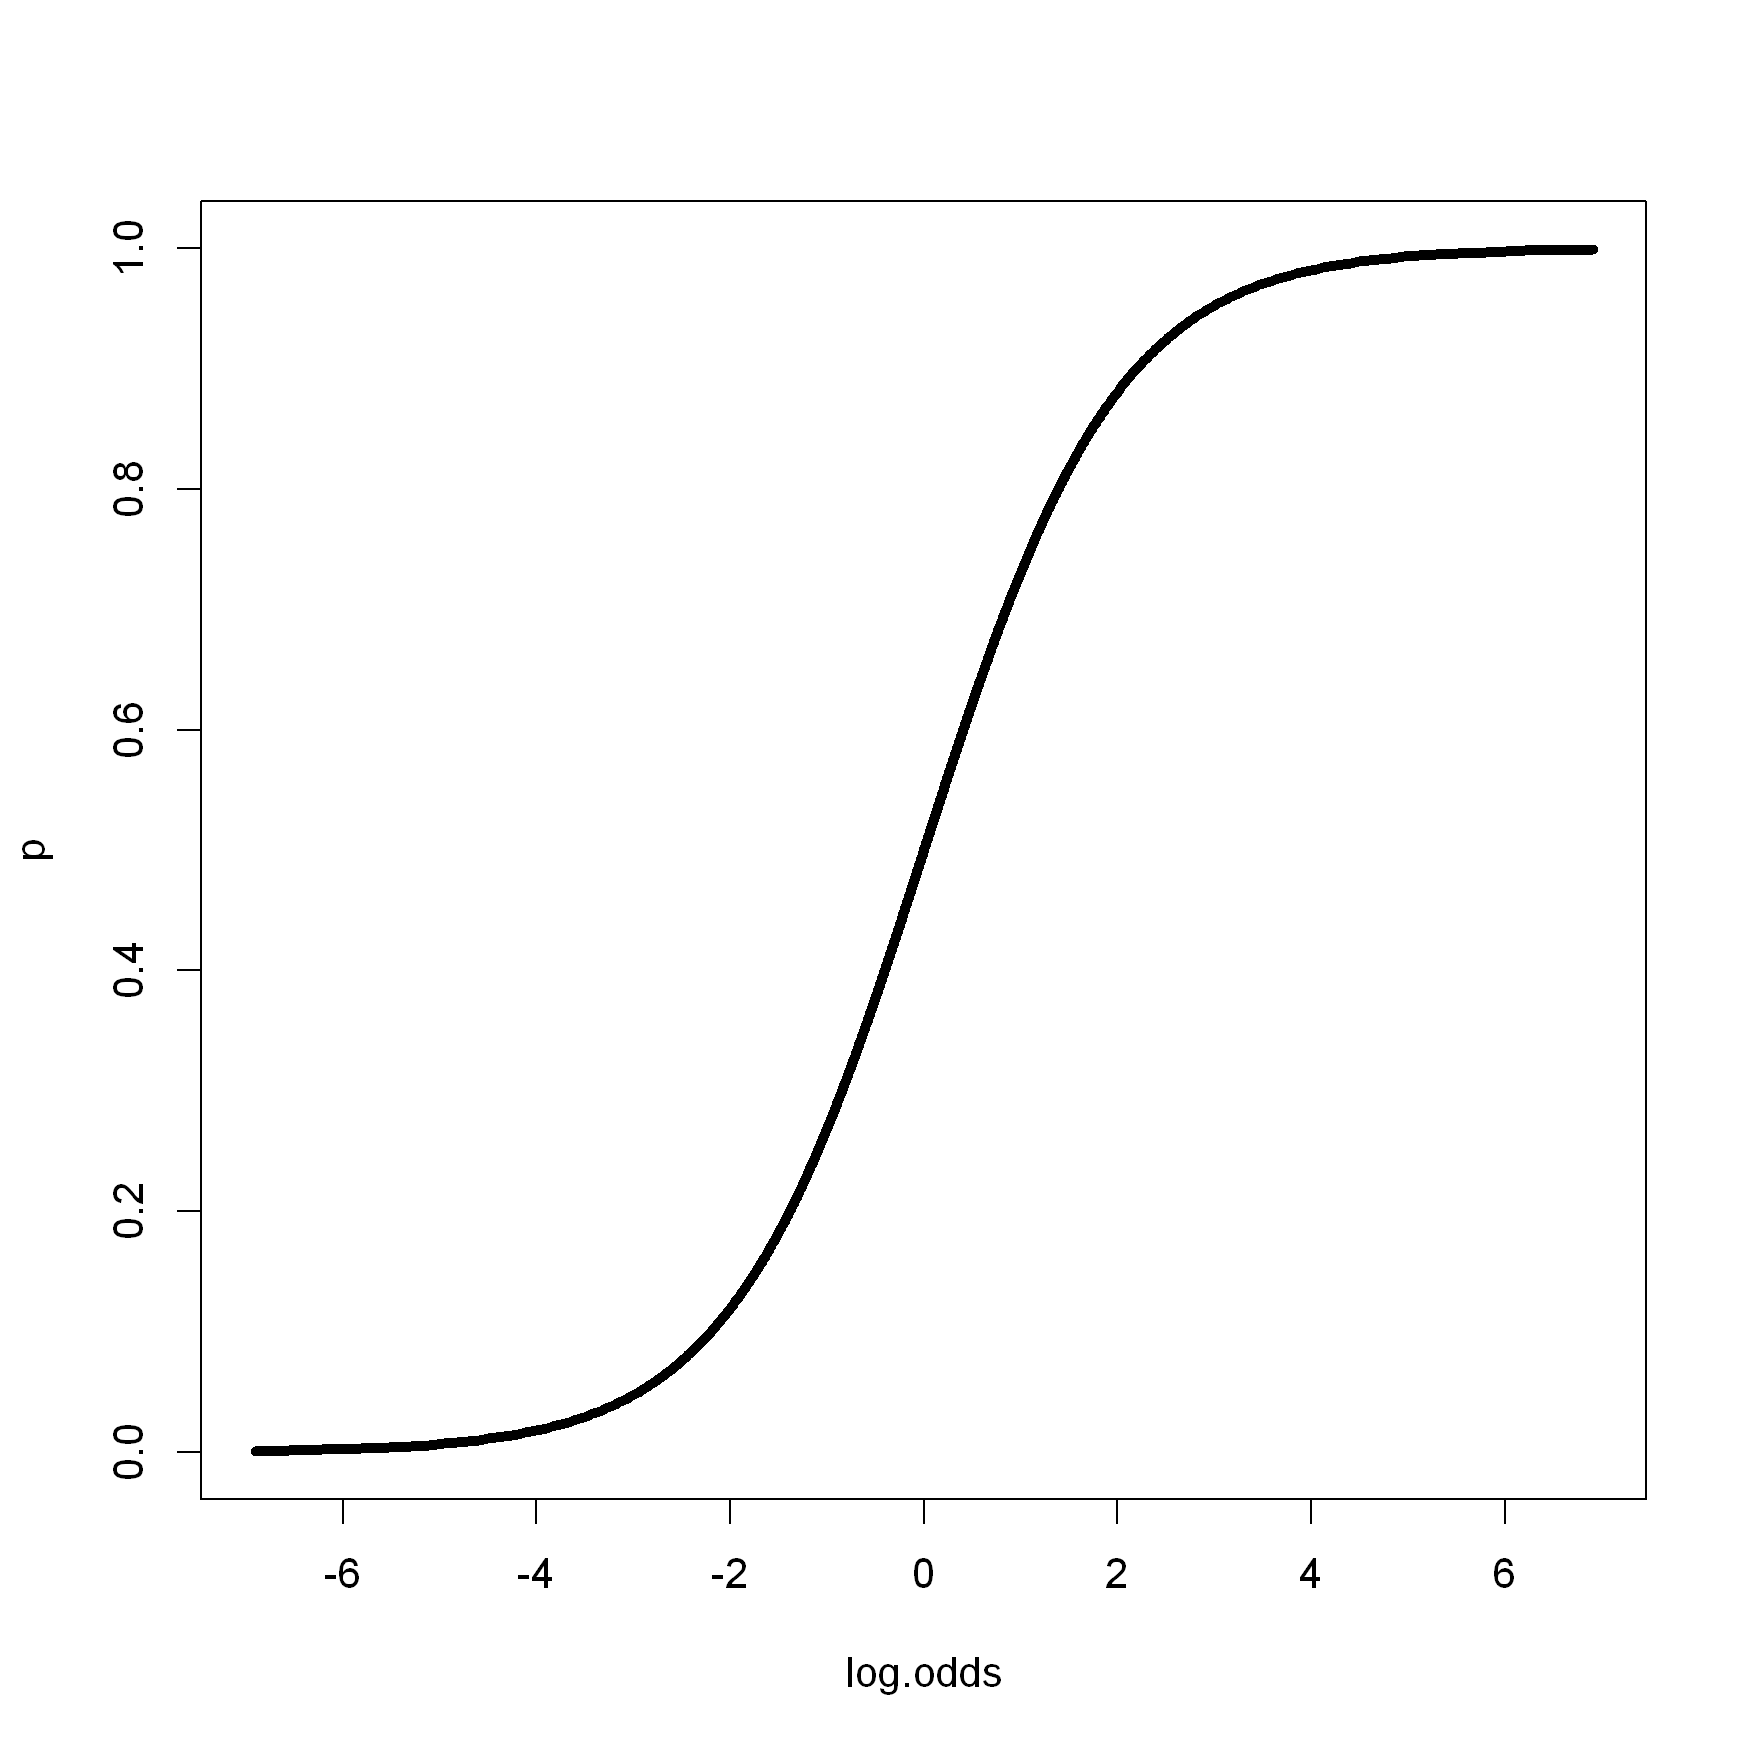

In [106]:
plot(log.odds, p,
    type = 'l', lwd = 4)

The final statement needed to specify the model is that
$$ y \sim \text{Bernoulli}(p)$$
This roughly corresponds to how we were thinking before with linear models.  $p$ is an optimal prediction, and then you can think of the actual observation of 0/1 as a random fluctuation away from $p$.

## Running The Analysis
Let's show you how to perform this regression.  Operationally, we do almost the exact same stuff as before with the function **glm** and have the same functionality with contrasts and basis expansions and whatnot.  Recall how closely related the Bernoulli and Binomial families are; due to this, the argument we need to specify is family = "binomial".

In [219]:
model <- glm(died ~ femalesex + I(scale(age,TRUE,F)/10) + sodium_max, data = df, family = "binomial")
summary(model)
summary(df$sodium_max)


Call:
glm(formula = died ~ femalesex + I(scale(age, TRUE, F)/10) + 
    sodium_max, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8803  -0.6937  -0.5220  -0.3320   2.8673  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -16.151496   1.075674 -15.015  < 2e-16 ***
femalesex                  -0.319366   0.091172  -3.503  0.00046 ***
I(scale(age, TRUE, F)/10)   0.326387   0.031825  10.256  < 2e-16 ***
sodium_max                  0.102521   0.007349  13.951  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3486.4  on 3415  degrees of freedom
Residual deviance: 3145.5  on 3412  degrees of freedom
AIC: 3153.5

Number of Fisher Scoring iterations: 4


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  126.0   140.0   143.0   144.1   147.0   180.0 

As with linear regression, there are certain model diagnostics to check if the logistic regression model is appropriate for your data (i.e. are your p-values correct).  Again, I encourage you to read about this information on your own.  A quick and dirty one that is sort-of informative is a residuals vs fitted plot like we saw in linear models.  However, what residuals means in this context is a little more complicated and we won't get into it.  Here's some code to auto-generate the plot for you.

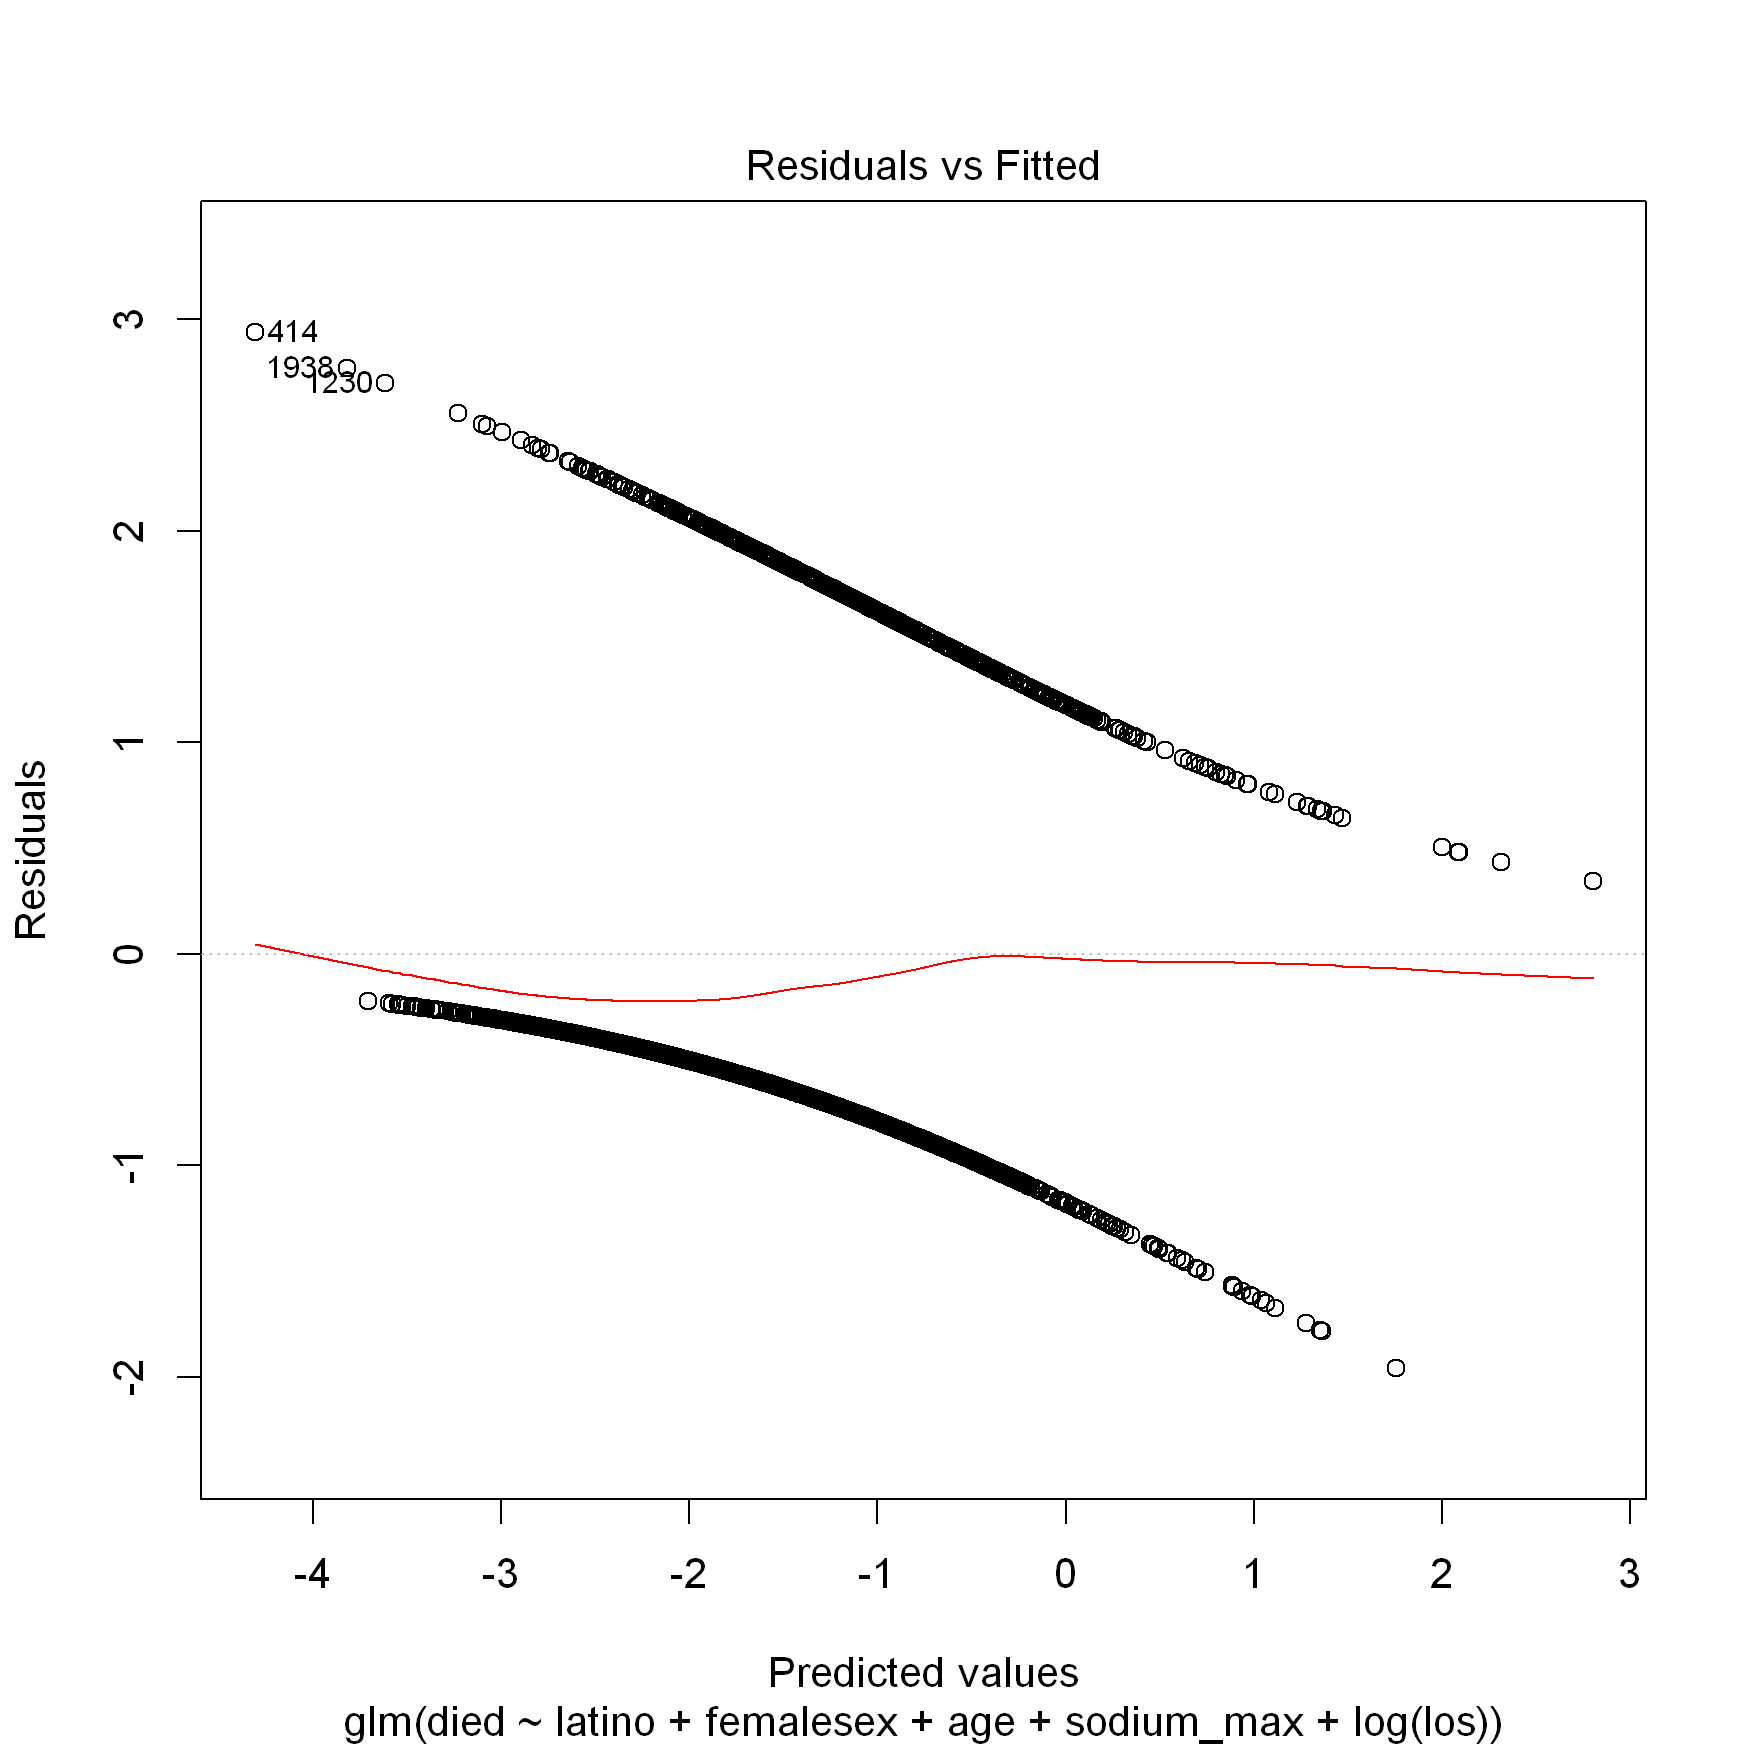

In [188]:
plot(model, which = 1)

You should look for the red line to stay fairly close to 0 throughout; otherwise, your model is likely incorrect.

Continuing forward, we can use many of the same functions we used before with linear models such as "confint" and "predict".

In [193]:
confint(model)

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-20.51287328,-16.1526002
femalesex,-0.49872296,-0.1412025
age,0.02646973,0.0389500
sodium_max,0.08823250,0.1170535


However, now we observe a "Waiting for profiling to be done..." warning that pops up when we call "confint".  This is because for generalized linear models, R actually does not use the 95% Wald confidence interval.  It uses a slightly better interval called a 95% profile likelihood confidence interval.  This interval takes slightly more work to compute, but has the advantage in that it stays accurate with even smaller sample size than the Wald interval.  

For help with the predict function, type "?predict.glm".  We need to specify on what scale we want our predictions.  On the linear scale or the scale of the responses/outcomes.  Usually, the latter is what we are interested in.  With this predict function, we don't get confidence intervals or prediction intervals.

In [192]:
new.data <-  data.frame(femalesex = c(0,1,1), 
                        age = c(31, 52, 69), 
                        sodium_max = c(140, 143, 139))
print(predict(model, newdata = new.data, type = "response"))

         1          2          3 
0.04995478 0.09348710 0.10649940 


## Intepretting Coefficients

If we have a patient A with predictors $(x_1, x_2)$, then the model tells us that their log odds look like
$$ \log \bigg( \frac{p_A}{1-p_A} \bigg) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 $$
From this, we see that their odds looks like
$$ \frac{p_A}{1-p_A} = \exp \big\{ \beta_0 + \beta_1 x_1 + \beta_2 x_2 \big\} $$
Now consider patient B with predictors $(x_1+1, x_2)$; in other words, they look exactly like patient A with respect to the covariates, except they have a 1 unit increase in $x_1$.  Their odds looks like
$$ \frac{p_B}{1-p_B} = \exp \big\{ \beta_0 + \beta_1 (x_1+1) + \beta_2 x_2 \big\} $$
Now if I wanted to compute the odds *ratio* between these two patients, it would look like
\begin{align*}
\text{OR}_{BA} &= \bigg(\frac{p_B}{1-p_B}\bigg) \biggr/ \bigg(\frac{p_A}{1-p_A}\bigg) \\
&= \frac{\exp \big\{ \beta_0 + \beta_1 (x_1+1) + \beta_2 x_2 \big\}}{\exp \big\{ \beta_0 + \beta_1 x_1 + \beta_2 x_2 \big\}} \\
&= \exp \big\{\beta_0 + \beta_1 (x_1+1) + \beta_2 x_2  - ( \beta_0 + \beta_1 x_1 + \beta_2 x_2) \big\} \\
&= \exp \{ \beta_1 \}
\end{align*} 

This gives us a very elegant interpretation once we estimate our coefficients: $\exp\{ \hat{\beta}_1 \}$ is an estimate of the odds ratio when you increase $x_1$ by one unit.  Remarkably, this number is the same *regardless* of the values $(x_1, x_2)$ you use; this property is a result of the model's linearity.

This interpretation is really handy for binary variables because an increase of 1 unit essentially corresponds to turning that variable on from an off state.  For example:

In [194]:
exp(model$coefficients['femalesex'])

femalesex 
0.7266093

We interpret this as females are estimated to have an odds that is about $72\%$ the odds of males, after adjustment.

## In-Class Exercise 1: Readmission among the Living

1. We are interested in exploring the relationship between several drugs administred to treat Covid and readmission within 30 days, the latter represented by "readmission30".  Obviously, you cannot be readmitted if you die, so we will restrict our analysis to those who did not experience death, which is represented by "died".  The drugs we are interested in are "remdesivir", "steroid", and "hydroxychloroquine".  Run a single logistic regression analysis to explore these relationships, additionally adjusting for "age" and "femalesex".

2. In a comment, interpet your three coefficients of interest using odds ratios.

3. What is the odds ratio between people who were administered both remdesivir and hydroxychloroquine vs people who were administered neither?

In [196]:
predictors <- c('remdesivir', 'hydroxychloroquine', 'steroid', 'age', 'femalesex')
formula <- paste(predictors, collapse = " + ")
formula <- paste('readmission30', formula, sep = ' ~ ')
formula <- as.formula(formula)
formula

model <- glm(formula, data = df[df$died == 0,], family = "binomial")
summary(model)

readmission30 ~ remdesivir + hydroxychloroquine + steroid + age + 
    femalesex


Call:
glm(formula = formula, family = "binomial", data = df[df$died == 
    0, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7625  -0.5930  -0.5396  -0.4676   2.3050  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -2.121984   0.256620  -8.269  < 2e-16 ***
remdesivir         -0.395621   0.135281  -2.924 0.003451 ** 
hydroxychloroquine -0.566135   0.158287  -3.577 0.000348 ***
steroid             0.202117   0.136267   1.483 0.138009    
age                 0.009258   0.003522   2.629 0.008573 ** 
femalesex          -0.166628   0.111355  -1.496 0.134557    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2246.6  on 2707  degrees of freedom
Residual deviance: 2219.8  on 2702  degrees of freedom
AIC: 2231.8

Number of Fisher Scoring iterations: 4


In [200]:
# question 2
round(exp(model$coefficients['remdesivir']), 3)
round(exp(model$coefficients['hydroxychloroquine']), 3)
round(exp(model$coefficients['steroid']), 3)

# question 3
unname(round(exp(model$coefficients['remdesivir'] + model$coefficients['hydroxychloroquine']), 3))

remdesivir 
     0.673

hydroxychloroquine 
             0.568

steroid 
  1.224

[1] 0.382

We estimate that those administered remdesivir have $67\%$ of the odds for readmission in 30 days compared to those who were not administered it.  Similar for hydroxycholoroquine and steroid, except using the percentages $57\%$ and $122\%$, respectively. 

We estimate that those administered both remdesivir and hydroxychloroquine have $38\%$ the odds of readmission compared to those who were administered neither.

# Survival Analysis

In survival analysis, the type of outcome we aim to model is a time-to-event.  This is a positive, continuous outcome that falls somewhere in $(0, \infty)$. To begin exposition, we will look at data where everybody has experienced the "event" and thus has an associated time-to-event.  We will look at the outcome length of stay (los), which describes how long a patient stayed at the hospital.  This is a common way of constructing time-to-event data in observational data.  Everybody has their own unique "time zero", i.e. when they were admitted.  The "event" of interest here is discharge.  "Survival" in this context corresponds to not experiencing the event.  Los is measured in days (I think)

## In-Class Exercise 2: Summarizing Time-to-Discharge

1. Plot a histogram of los.  If what you see isn't as helpful as you'd like, try using the "xlim = c(start,end)" and "breaks = num.breaks" argument. (FYI, you should fill in start, end, and num.breaks with your own numbers.)

2. Think about what the data represents and what sorts of questions might be interesting to answer.  Based on these thoughts, compute some summary statistics of your choosing to understand this data; these don't necessarily need to be the ones we covered in Sessions 1 and 2.

**Solution:**

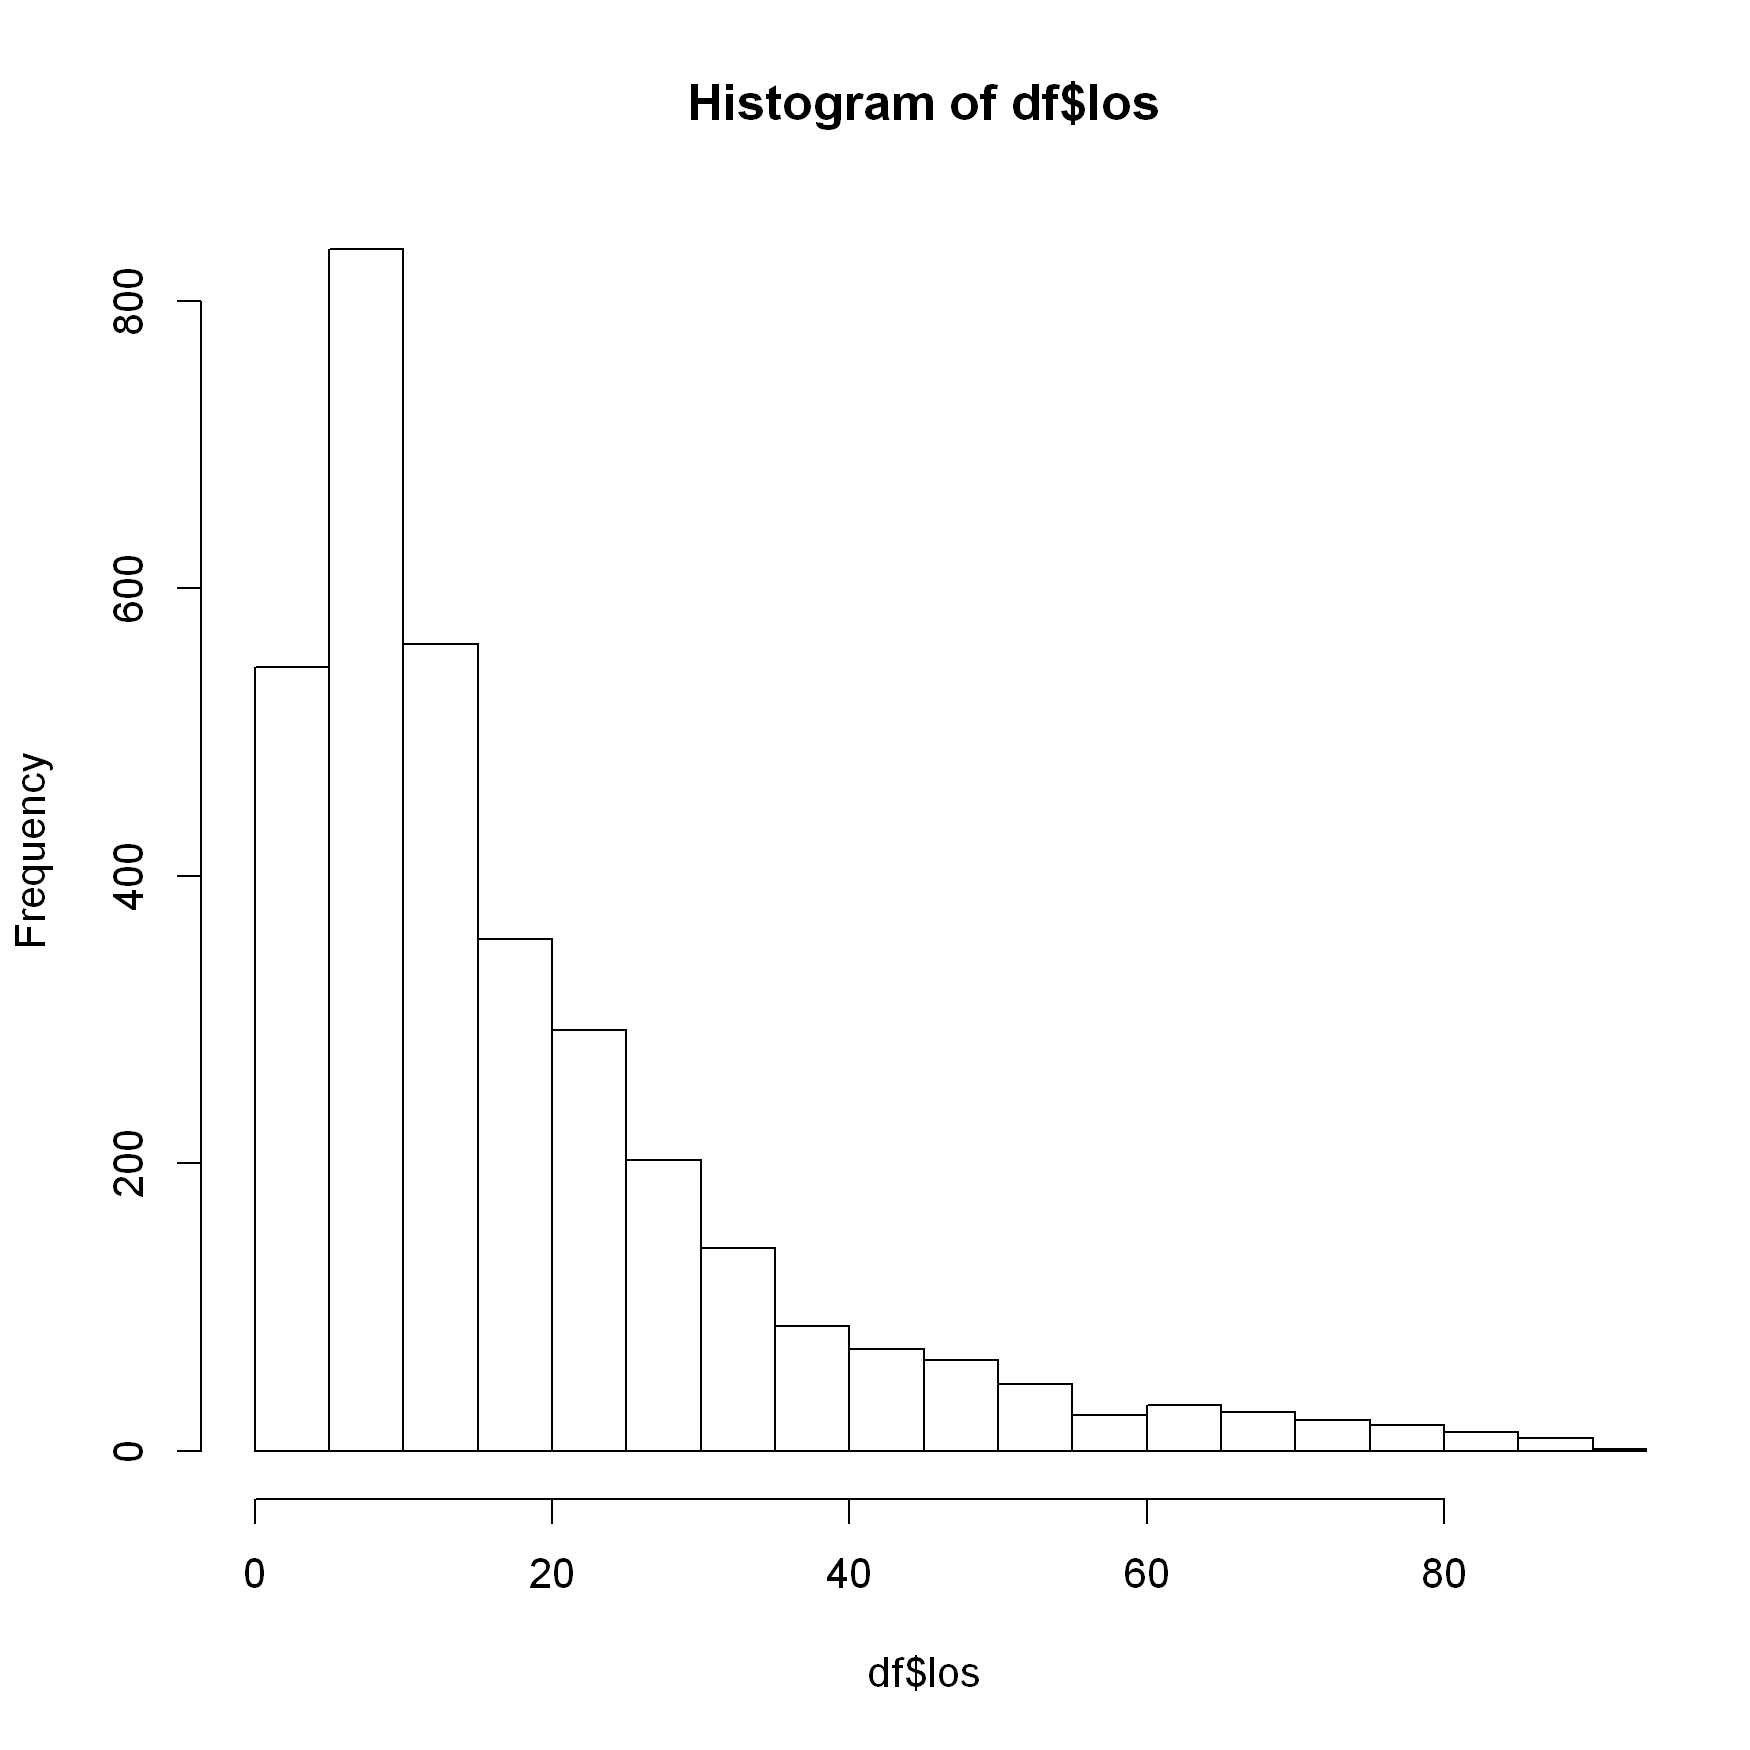

In [113]:
hist(df$los, breaks = 100, xlim = c(0, 90))

To get a sense of location, we'll use the summary function. I'll also get the inter-quartile range to get a sense of spread.

However, I think the most interesting question to ask is what proportion of patients have a los *larger than* particular meaninful cutoff.  For example, what proportion of these patients are hospitalized for larger than a week? A month? Two months?

In [123]:
# measures of centrality, 25 & 75th percentile locations, and extremes
summary(df$los)

# inter quartile range
round(IQR(df$los), 2)

# hospitalized longer than cutoff
round(mean(df$los > 7), 3)
round(mean(df$los > 30), 3)
round(mean(df$los > 60), 3)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.4715   6.8436  12.7184  20.6338  24.2811 455.2160 

[1] 17.44

[1] 0.739

[1] 0.182

[1] 0.056

## The Survival Function

If I ask this last question for every number between 0 and infinity, I get back what's known as the **surival function**.  In practice, I can simple run sometime similar to the above code for a dense grid of points and plot it to get an *estimate* of the survival function; I can choose the actual observations in my dataset as the grid.  I'm effectively doing that in the code below, but in a very compact, efficient way; you don't need to understand how this works.

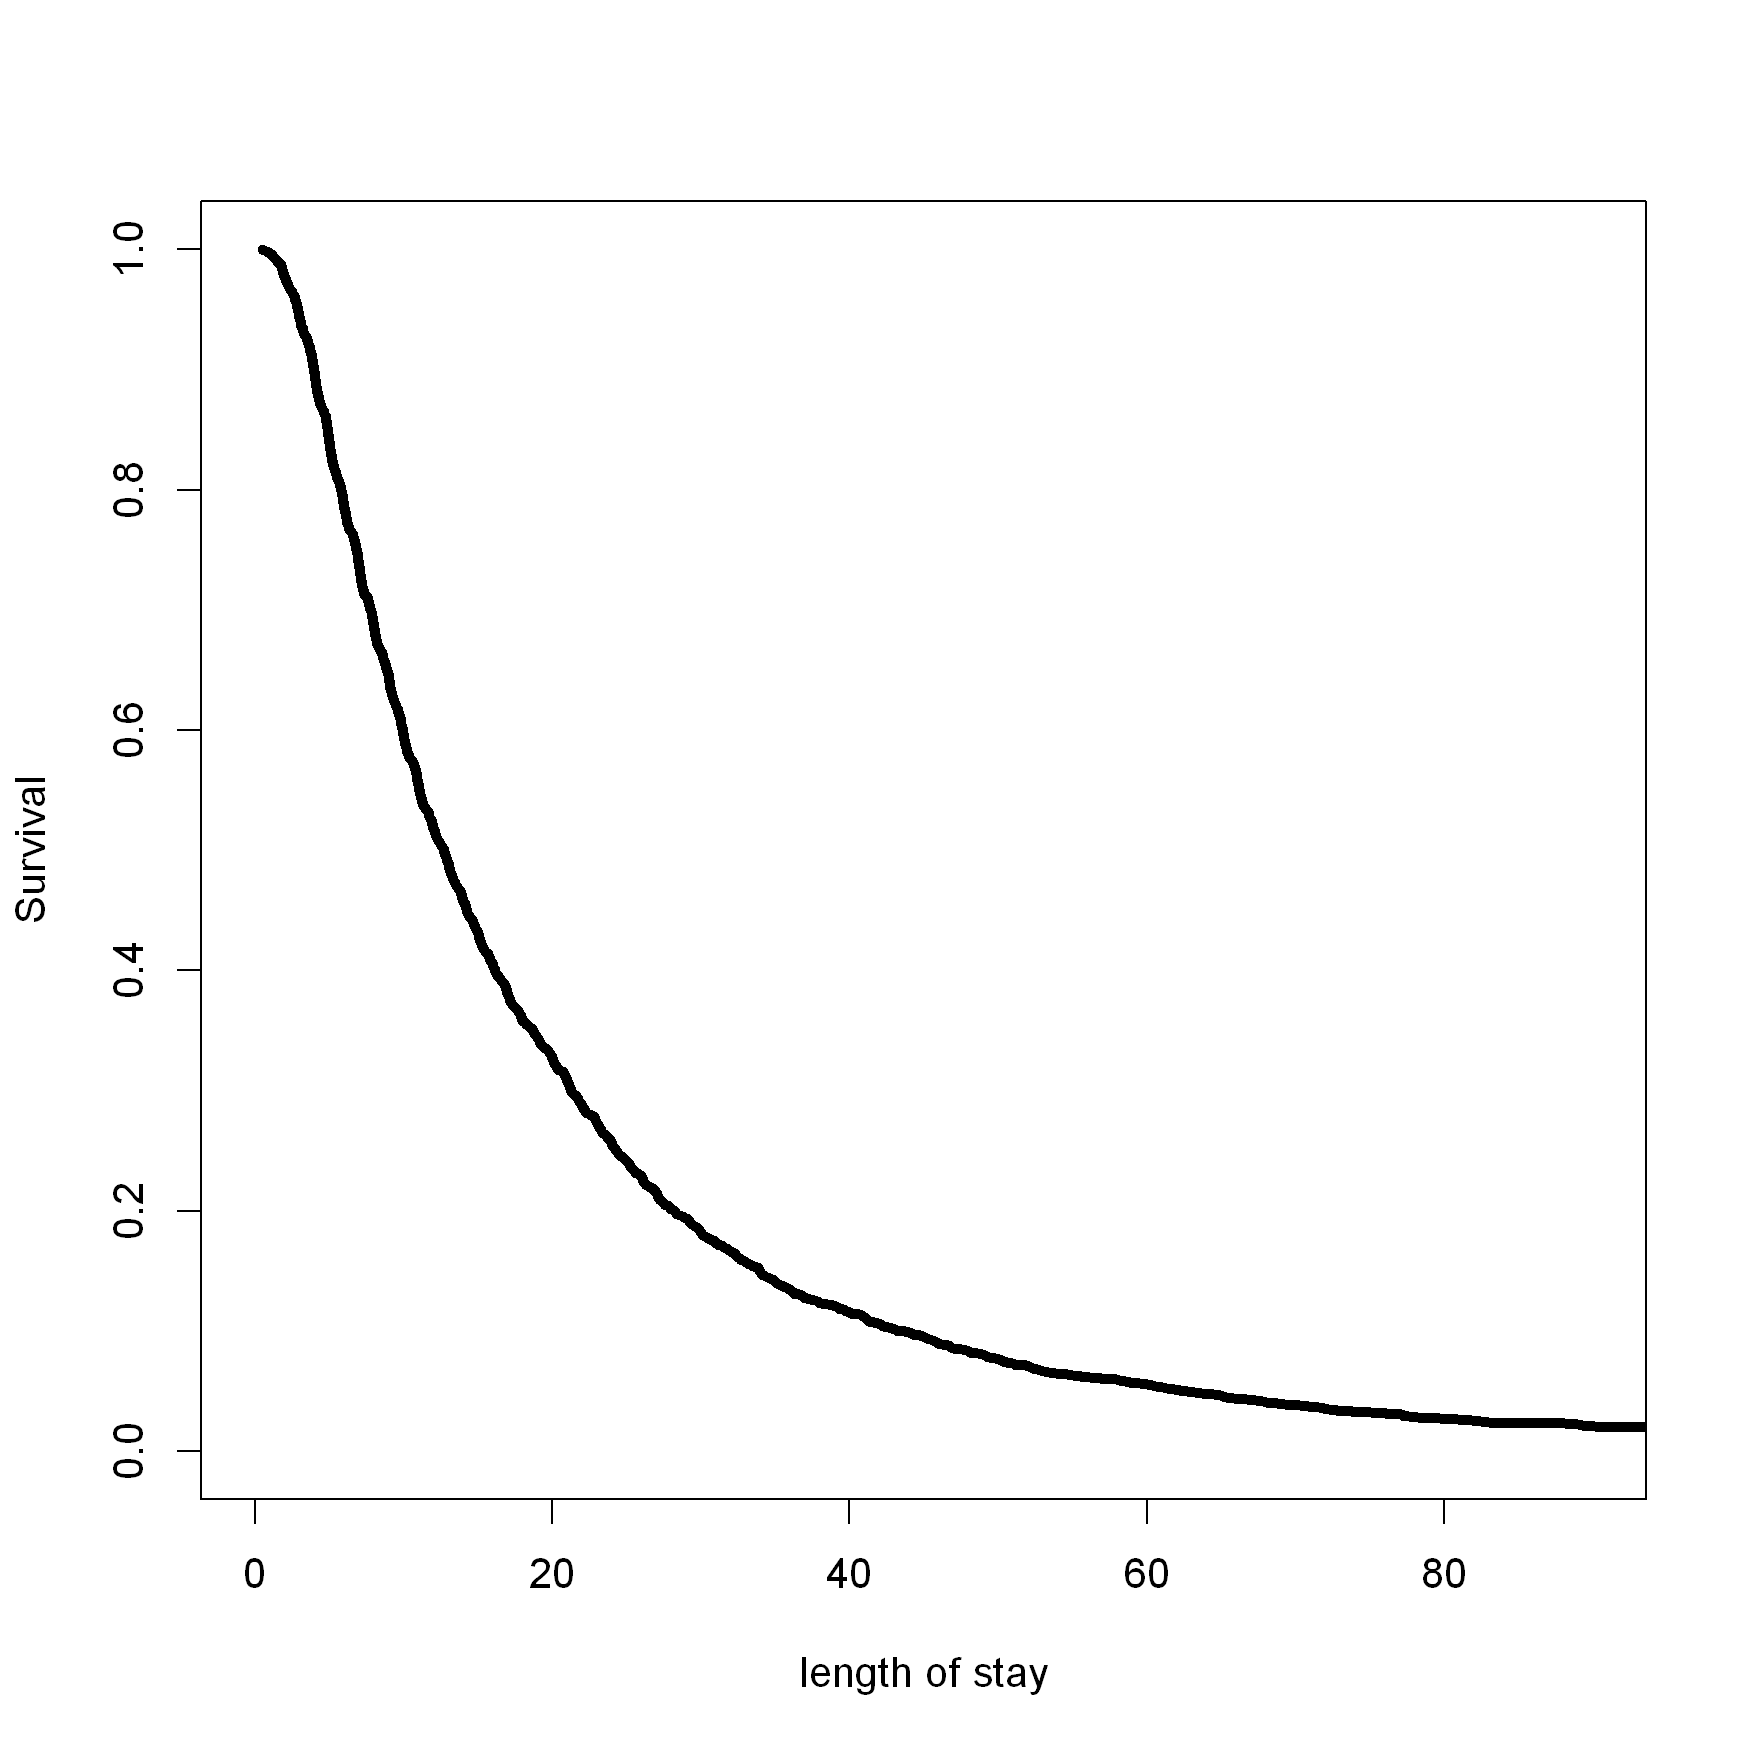

In [90]:
n <- nrow(df)
T <- sort(df$los)
T.surv <- rev(seq(1/n, 1, 1/n))
plot(T, T.surv, 
     xlim = c(0, 90), type = 'l', lwd = 4,
     ylab = 'Survival', xlab = "length of stay")

Looking at this plot, we can then answer the question for any value of los.  What percent of patients are admitted to the hospital for more than 45 days?  According to the plot, our estimate is about $10\%$.  What is the median length of stay in the hospital?  According to the plot (and our previous calculation), just over 12 days.

## The Hazard Function

The other crucial element of survival analysis is the **hazard function**.  It expresses the "instantaneous rate" of the event at some time $t$, but only amongst all the patients who did experience the event yet at time $t$.  In your head, you can imagine this as subsetting your data to only examine those whose time-to-event $T$ satisfies $T > t$.  Then you'd ask, in this subpopulation, what proportion of patients would experience the event in the next unit of time (day in this case).  This is not exactly correct, but it's close enough to aid intuition.

I'm going to make a plot where I estimate the hazard function below.  You don't need to understand my code.

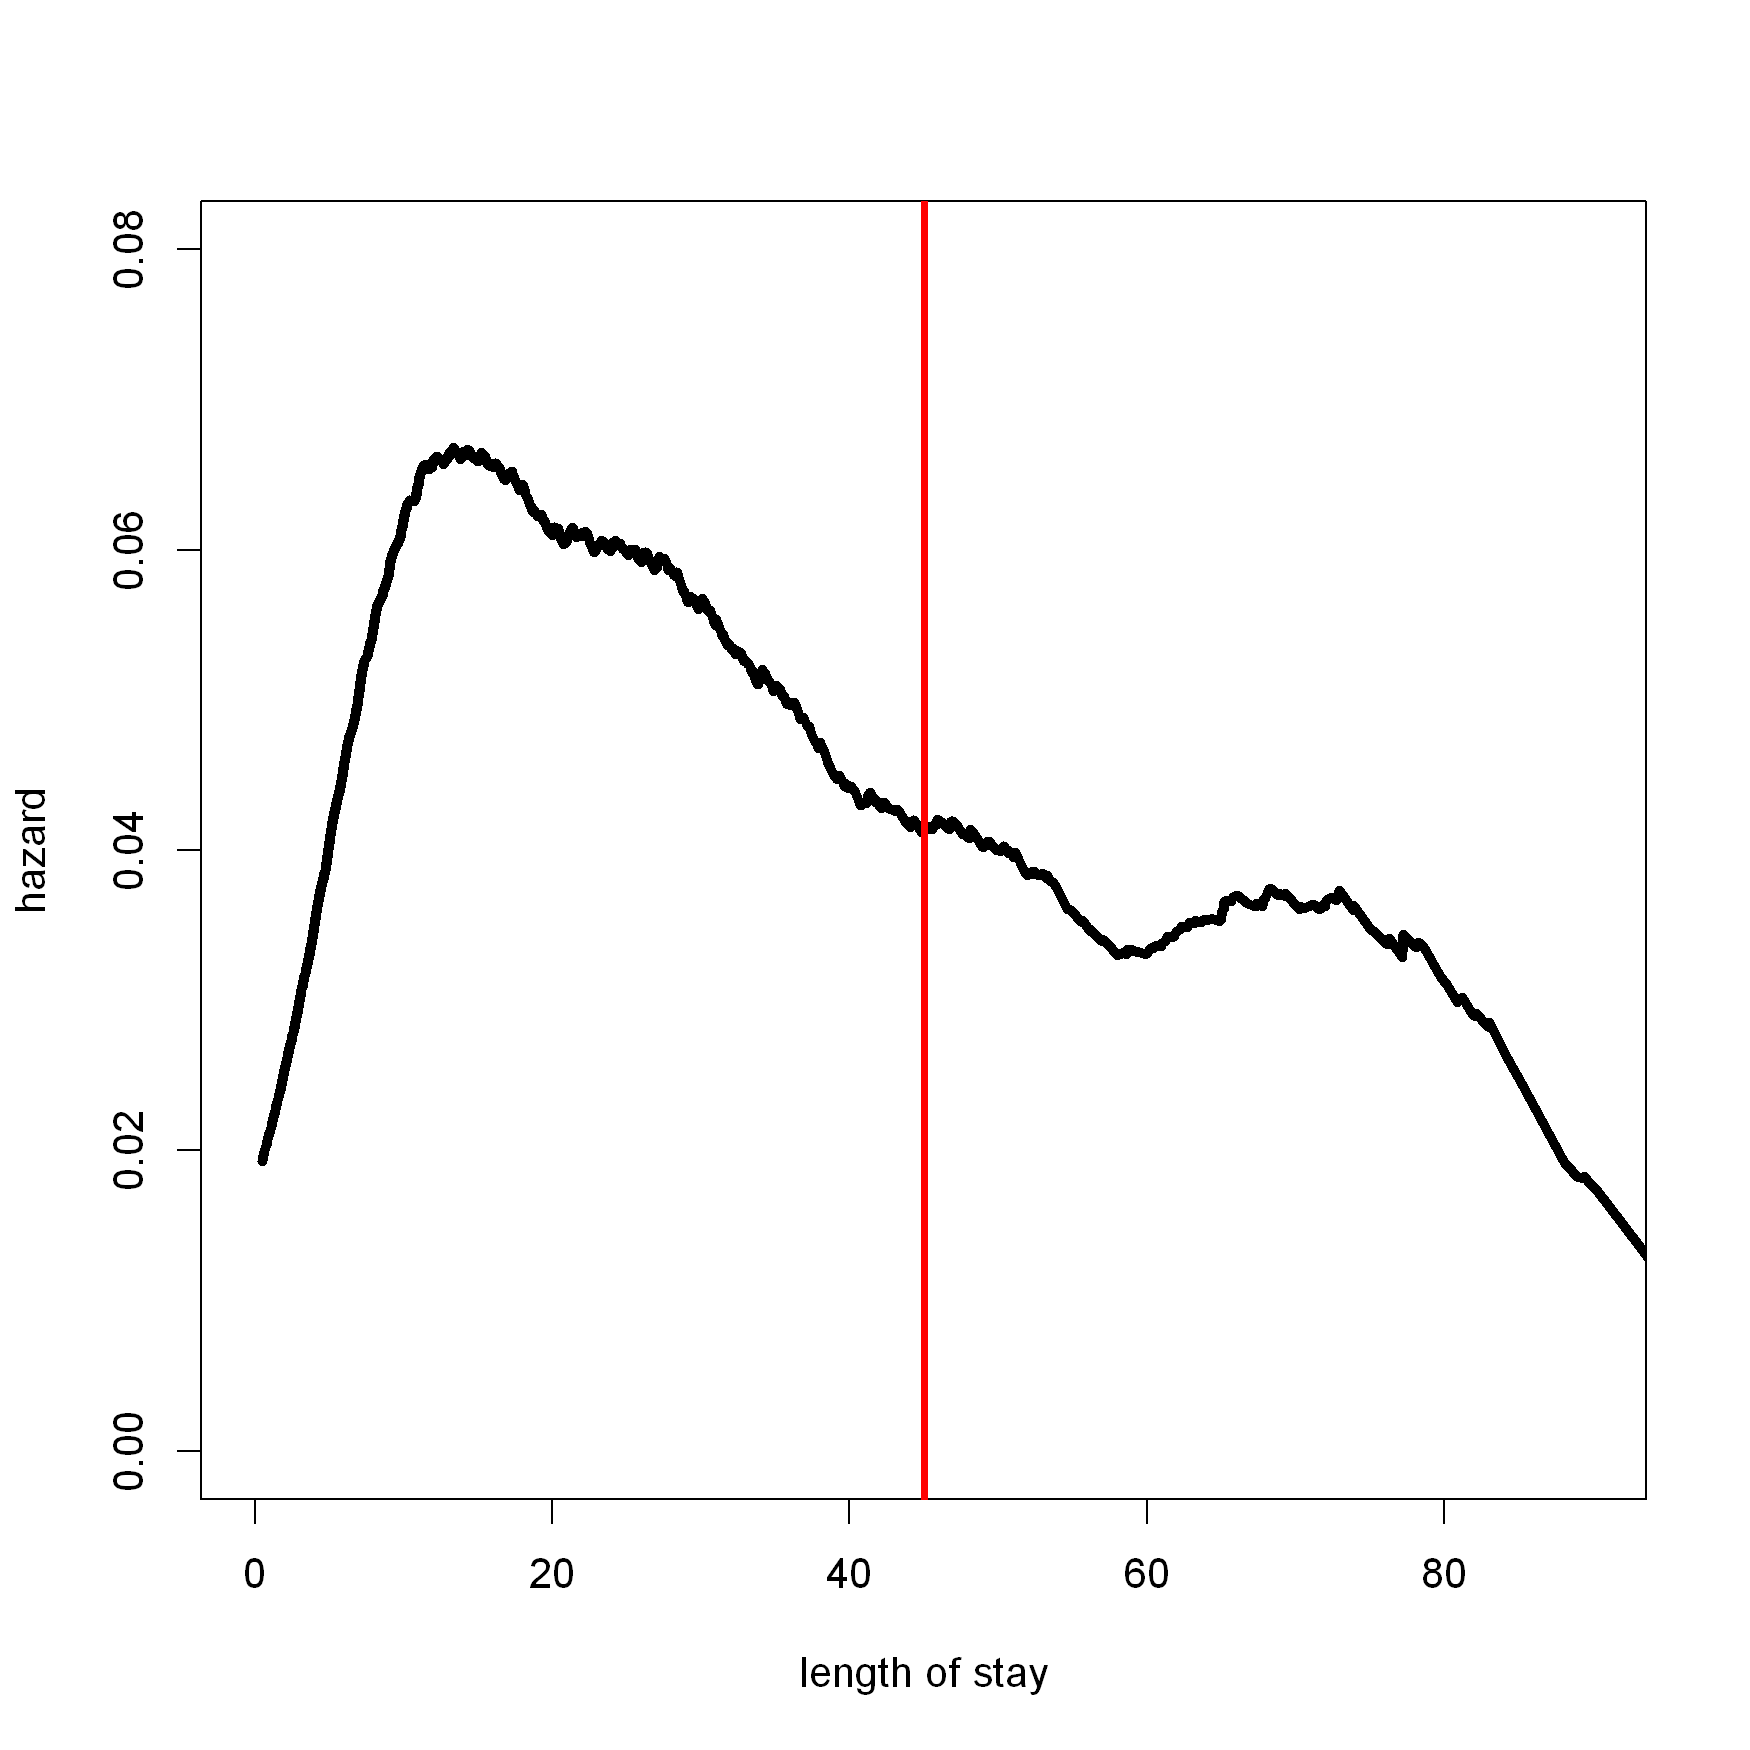

In [111]:
d <- density(T, n = 2048, bw = 'SJ', adjust = 5)
T.haz <- approx(d$x, d$y, xout = T)$y/T.surv
plot(T, T.haz,
    type = 'l', lwd = 4,
    xlim = c(0, 90), ylim = c(0, 0.08),
    xlab = "length of stay", ylab = "hazard")
abline(v = 45, col = 'red', lwd = 3)

Let's take the value $t = 45$.  This plot tells us that amongst those who were admitted to the hospital for 45 days or longer, I'd roughly expect around $4\%$ of them to experience the event by day 46.  A slightly more accurate statement would be that I expect $0.4\%$ of them to experience the event by day 45.1.  Recall that the hazard is technically an "instantaneous" rate, so the farther forward we extrapolate in time, the less accurate the statement is.

Lastly, I can plot the **cumulative hazard function**.  This effectively cumulatively sums up the values of the plot above from left to right.  Here's what it looks like.

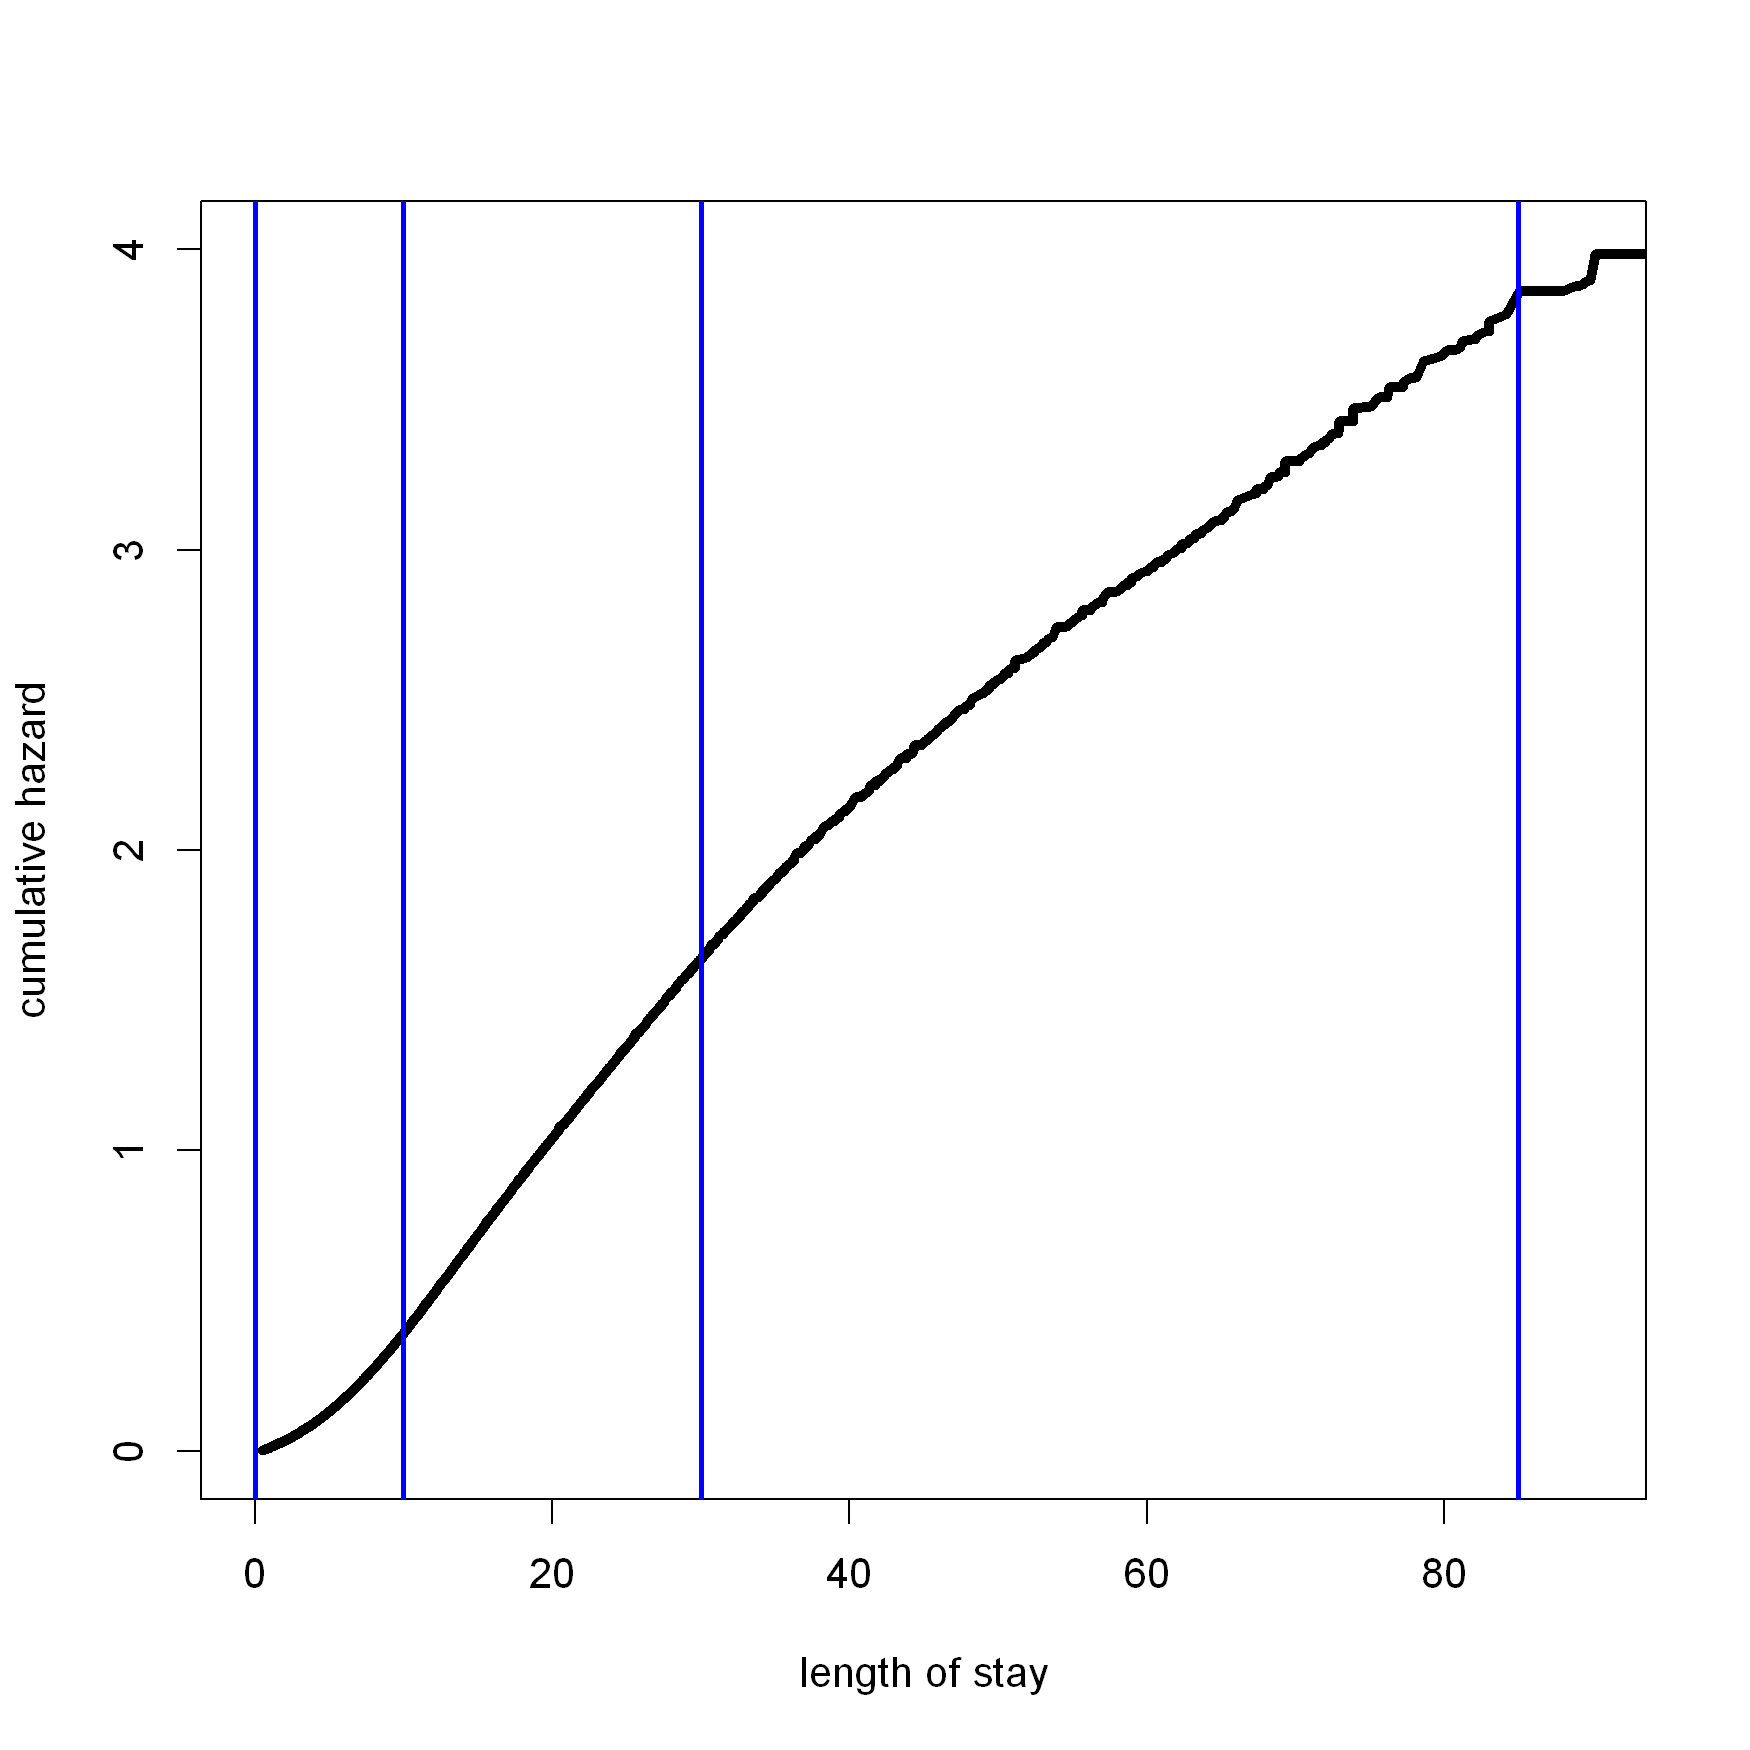

In [118]:
T.cum.haz <- cumsum(T.haz[1:(n-1)]*(T[2:n]-T[1:(n-1)]))
plot(T[1:(n-1)], T.cum.haz,
    type = 'l', lwd = 4,
    xlim = c(0, 90), ylim = c(0, 4),
    xlab = "length of stay", ylab = "cumulative hazard")
abline(v = 0, col = 'blue', lwd = 2)
abline(v = 10, col = 'blue', lwd = 2)
abline(v = 30, col = 'blue', lwd = 2)
abline(v = 85, col = 'blue', lwd = 2)

This is not a great plot to interpret by itself.  However, I introduce it, since we can look at it and sort of understand what the shape of the underlying hazard function might have been.  From the strong positive curvature on the extreme left of the plot ($t$ in $[0,10]$), you can see the hazard starts out small but quickly picks up.  Then the plot is fairly linear when $t$ is in $[10,30]$, indicating the underlying hazard is sort of stable/constant.  Lastly, when $t$ is in $[30,85]$ the plot has slight negative curvature, indicating that the hazard is slowly decreasing through this interval.

This will be useful when to get to censored survival data - in this case, we don't have a nice, general estimator of the hazard function.  However, we have one for the cumulative hazard function and can use that to make guesses about the shape of the hazard function.

## Hazard Regression Models

### What should we model?
So we've looked 3 different functions: the survival, hazard, and cumulative hazard function.  Suppose $\lambda(t)$ represents the hazard as a function of the time $t$ elapsed since the "start" time.  Then the cumulative hazards function was created by simply cumulatively summing up the values in the plot left to right: let's call it $\Lambda(t)$.  From here, we actually can exactly express the survival function as follows:
$$ S(t) = \exp\big( - \Lambda(t) \big) $$
This means that if you took the most recent plot above, and passed it through this function, you would get back the first survival function plot I created!

Although we would like to derive insights and make scientific conclusions on the level of the survival function, this shows us that the hazard function is really the "central" object of survival analysis.  Once we have a model for the hazard function, we can easily use it to produce a survival function as shown above.  

### Constant Hazard with a Discrete Covariate

Okay, so I have a covariate $x$, say representing female sex, that is measured *before* time zero in each patient.  How might I incorporate this information to make a model of the hazard function?  For clarity, what I'm saying is that the subpopulation who are female (i.e. $x=1$) have their own hazard function vs those who are male ($x=0$).  This is analogous to linear regression modeling in how we said the subgroup with $x=1$ had its own mean vs the subgroup with $x=0$.  However, the big complication in this scenario is that each group doesn't get its own single number like a mean.  Each group has to get its own entire *function* - a hazard function.  However to start with, we can simplify the model so that the entire function *can* be summarized with a single number.  We can model the hazard function as a *constant* and just try to estimate that single constant value.

Here's what this very simple model looks like
$$ \lambda(t,x) = \beta_0 + \beta_1 x $$

The hazard is a regression context is always a function of both $t$ and $x$, but our simple model doesn't make any use of the $t$ information, since we model the hazard as constant across all values of $t$.  Just to drive this home, let's look at what our estimates would be.  In red, I'll be plotting an estimate for females, i.e. $\lambda(t,1)$ as a function of $t$, and in black, I'll be plotting an estimate of $\lambda(t,0)$ for males.

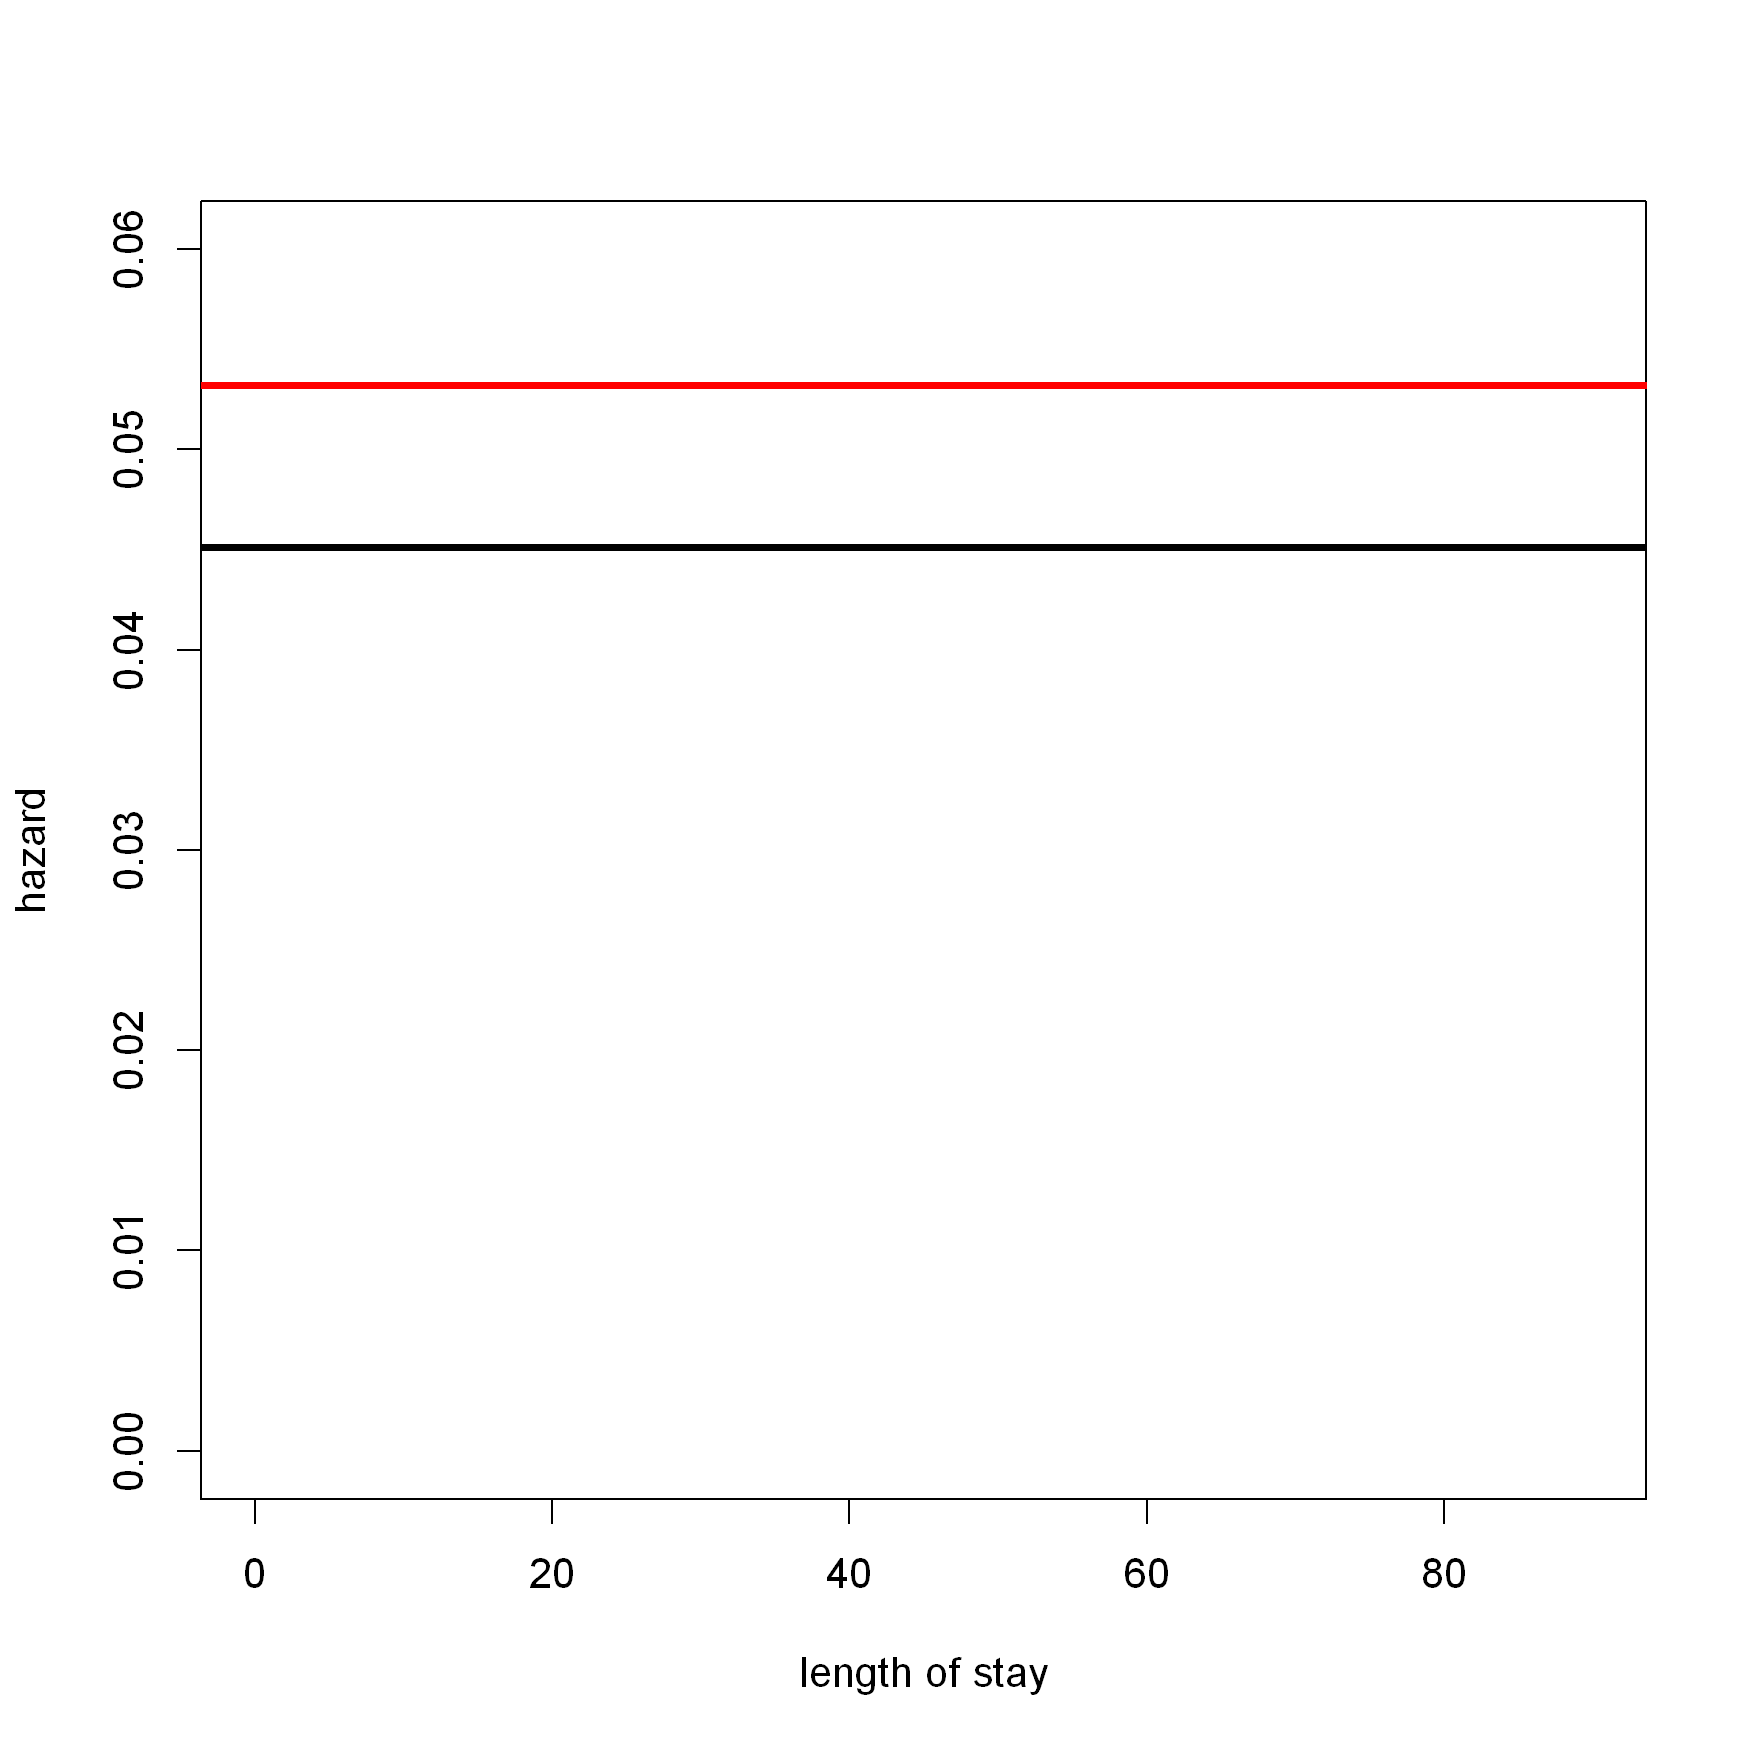

In [76]:
# estimate constant hazards; you don't need to know why this works
hazard.female <- 1/mean(df$los[df$femalesex==1])
hazard.male <- 1/mean(df$los[df$femalesex==0])

# plot hazard functions on top of each other
plot(1, type = "n", xlab = "length of stay",
     ylab = "hazard", xlim = c(0, 90), 
     ylim = c(0, 0.06))
abline(h = hazard.female, col = 'red', lwd = 3)
abline(h = hazard.male, lwd = 3)

This tells us that on average females have a larger hazard for the event of discharge.  We can then pass this information forward and create survival curves for each estimated hazard function.

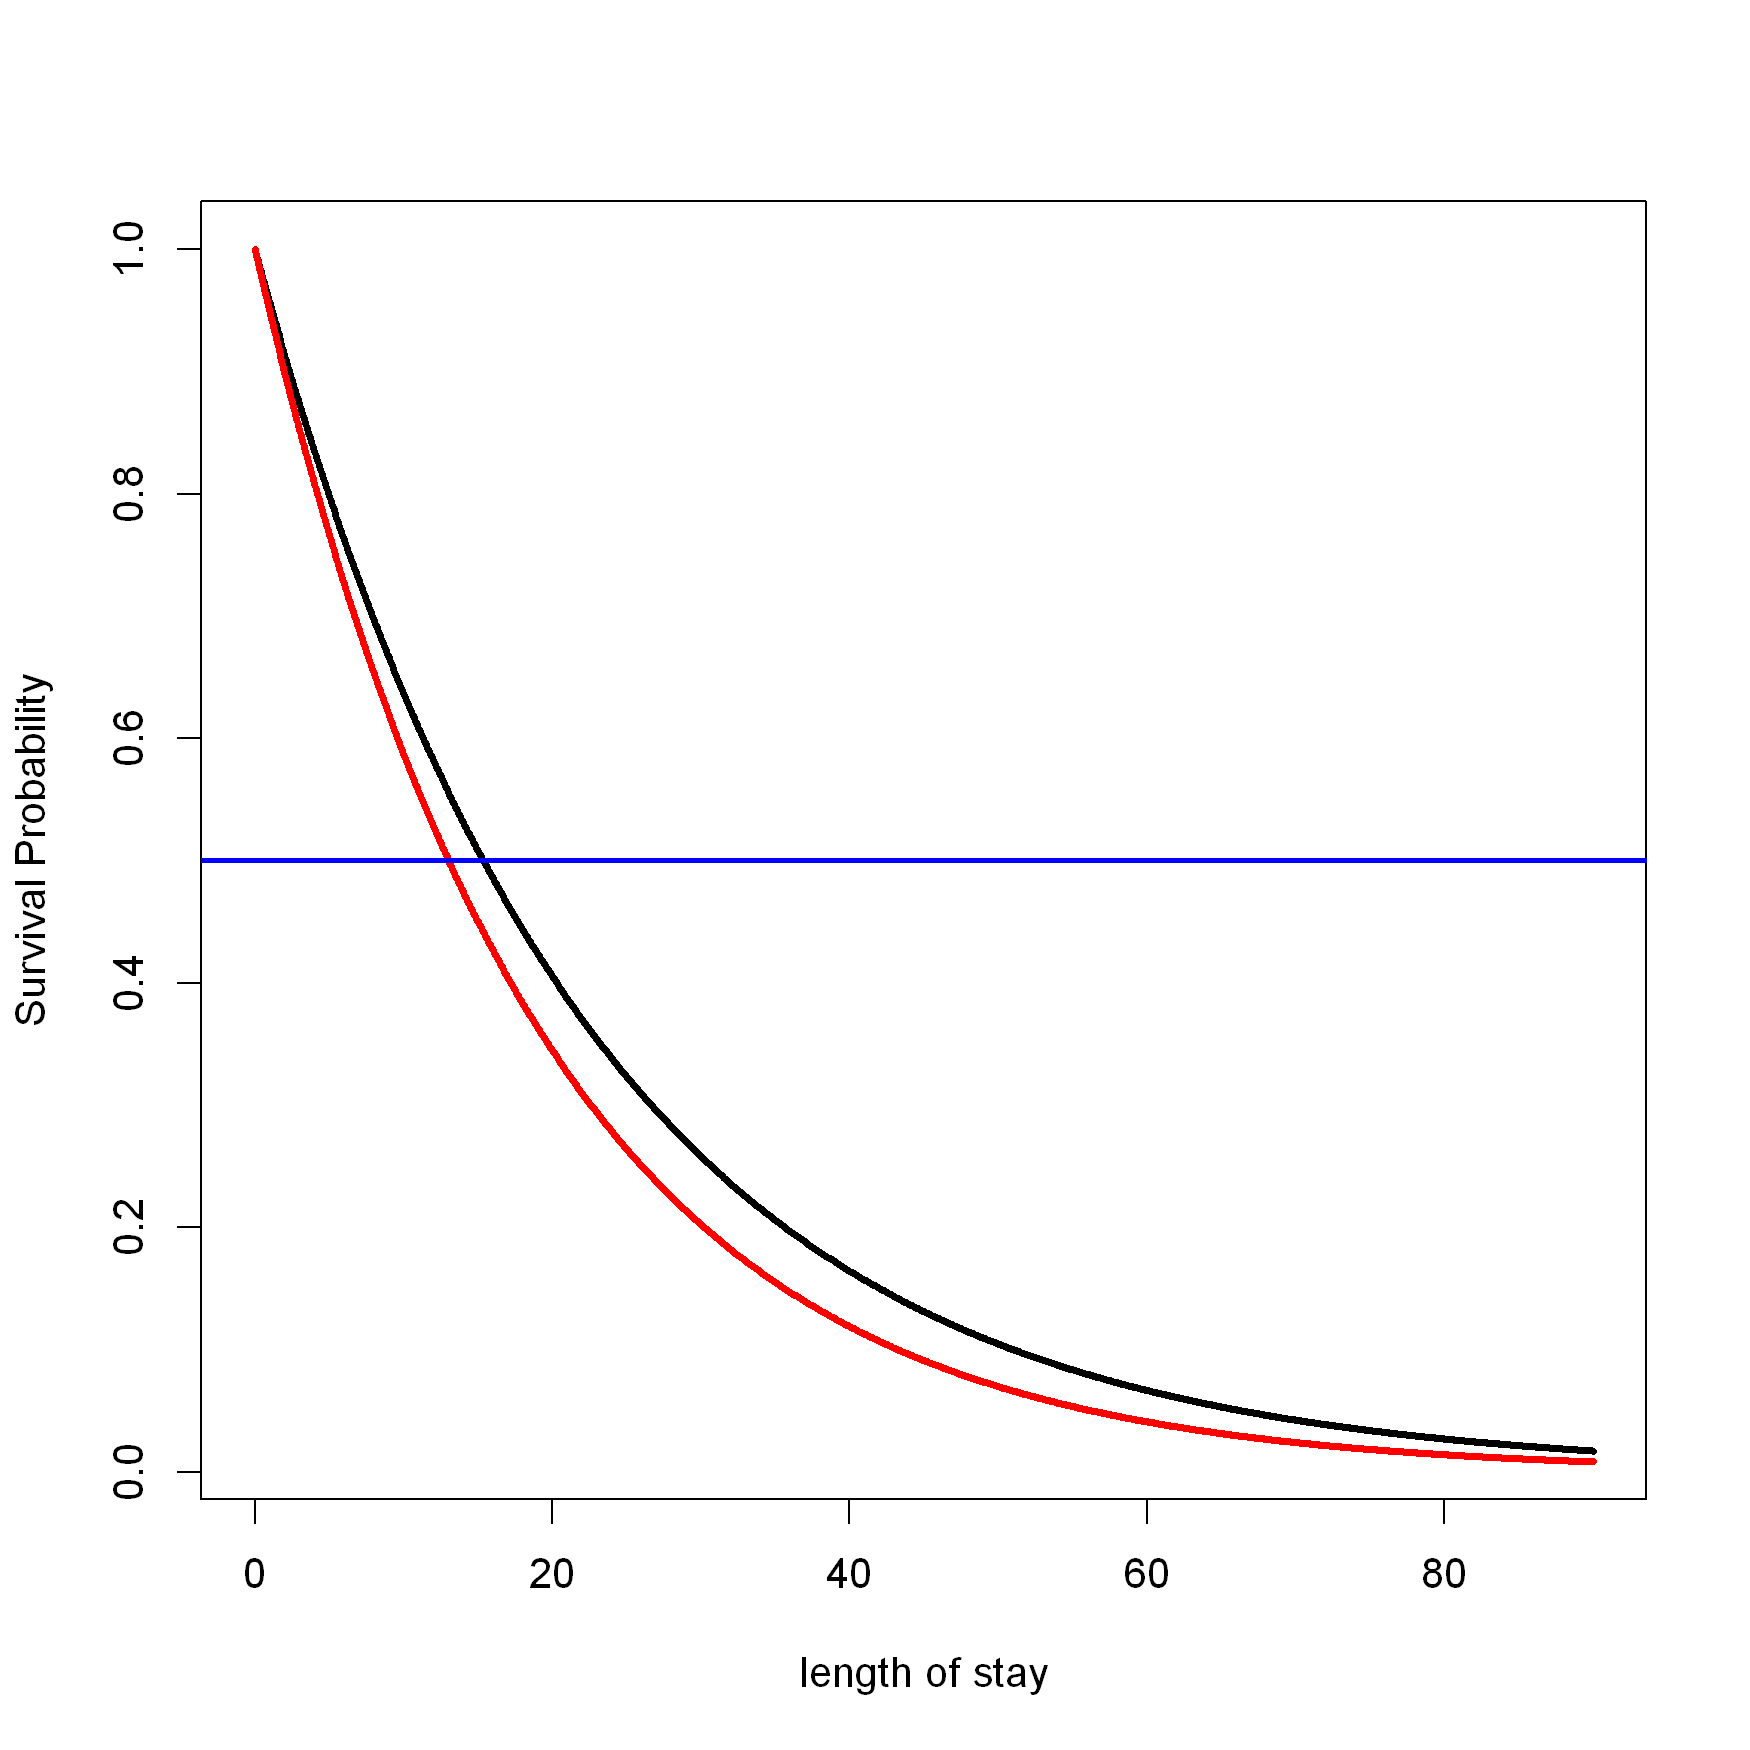

In [77]:
# get cumulative hazards across a grid for t
t <- seq(0, 90, by = 0.1)
cumhaz.male <- hazard.male*t # this formula only works for constant hazards
cumhaz.female <- hazard.female*t

# get survival functions
survival.male <- exp(-cumhaz.male)
survival.female <- exp(-cumhaz.female)

# plot
plot(t, survival.male, type = 'l', lwd = 3, 
     ylab = "Survival Probability", xlab = "length of stay")
lines(t, survival.female, lwd = 3, col = 'red')
abline(h = 0.5, col = 'blue', lwd = 2)

As a reminder, the red curve is the survival function for females, and the black curve is for males.  From this, we can do things like compare the median survival times (i.e. time-to-discharge) between these two groups (intersections with blue line).

### Proportional Hazards Model

There are two ways we need to extend the previous model.  

- First, we should model hazards a little bit more flexibly than constant.  We need to make use of $t$ in some manner in the regression equation.  One easy way to do this might be to create a *baseline* hazard shape (a function of $t$) and then use the covariates to shift that baseline hazard function up or down.  This baseline will act analagously to the intercept from the usual linear regression model.

- The second complication comes from using a continuous $x$.  The hazard function is always *positive*.  We would like to create some sort of linear model, but if we naively multiply a continuous $x$ by a coefficient, we still risk getting negative numbers.  How to fix this?  Very similar technique to what we used in logistic regression.  We can use the $\log$ function to map the interval $(0,\infty)$ to the interval $(-\infty, \infty)$.  Then we can model the *log* hazards as linear.

Okay, what do these modifications look like in terms of the equation?

$$ \log \lambda(t,x) = \beta_0(t) + \beta_1 x $$

This is known as a **proportional hazards (PH) regression model**.  Why?  Let's first look like what the hazard function looks like here by exponentiating both sides:

\begin{align*}
\lambda(t,x) &= \exp \big\{ \beta_0(t) + \beta_1 x \big\} \\
&= \exp \big\{ \beta_0(t) \big\} \exp \big\{ \beta_1 x \big\} \\
\end{align*}

For clarity, I can simply define the baseline hazard function $\lambda_0(t) \equiv \exp \{ \beta_0(t) \big\}$ and define the multiplicative factor $m(x) = \exp \{ \beta_1 x \}$ so that the above looks like

$$\lambda(t,x) = m(x) \cdot \lambda_0(t)$$

This makes it abundantly clear what this model is doing.  There is a baseline, reference hazard function for everybody.  Our covariates allow us to compute multiplicative factors that scale this baseline hazard function up or down.  To drive this point home, let's visualize this with some made up data.  I'm going to plot a made-up baseline hazard function in black and then show you in red what the hazard function would be for a patient with $m(x) = 0.75$.

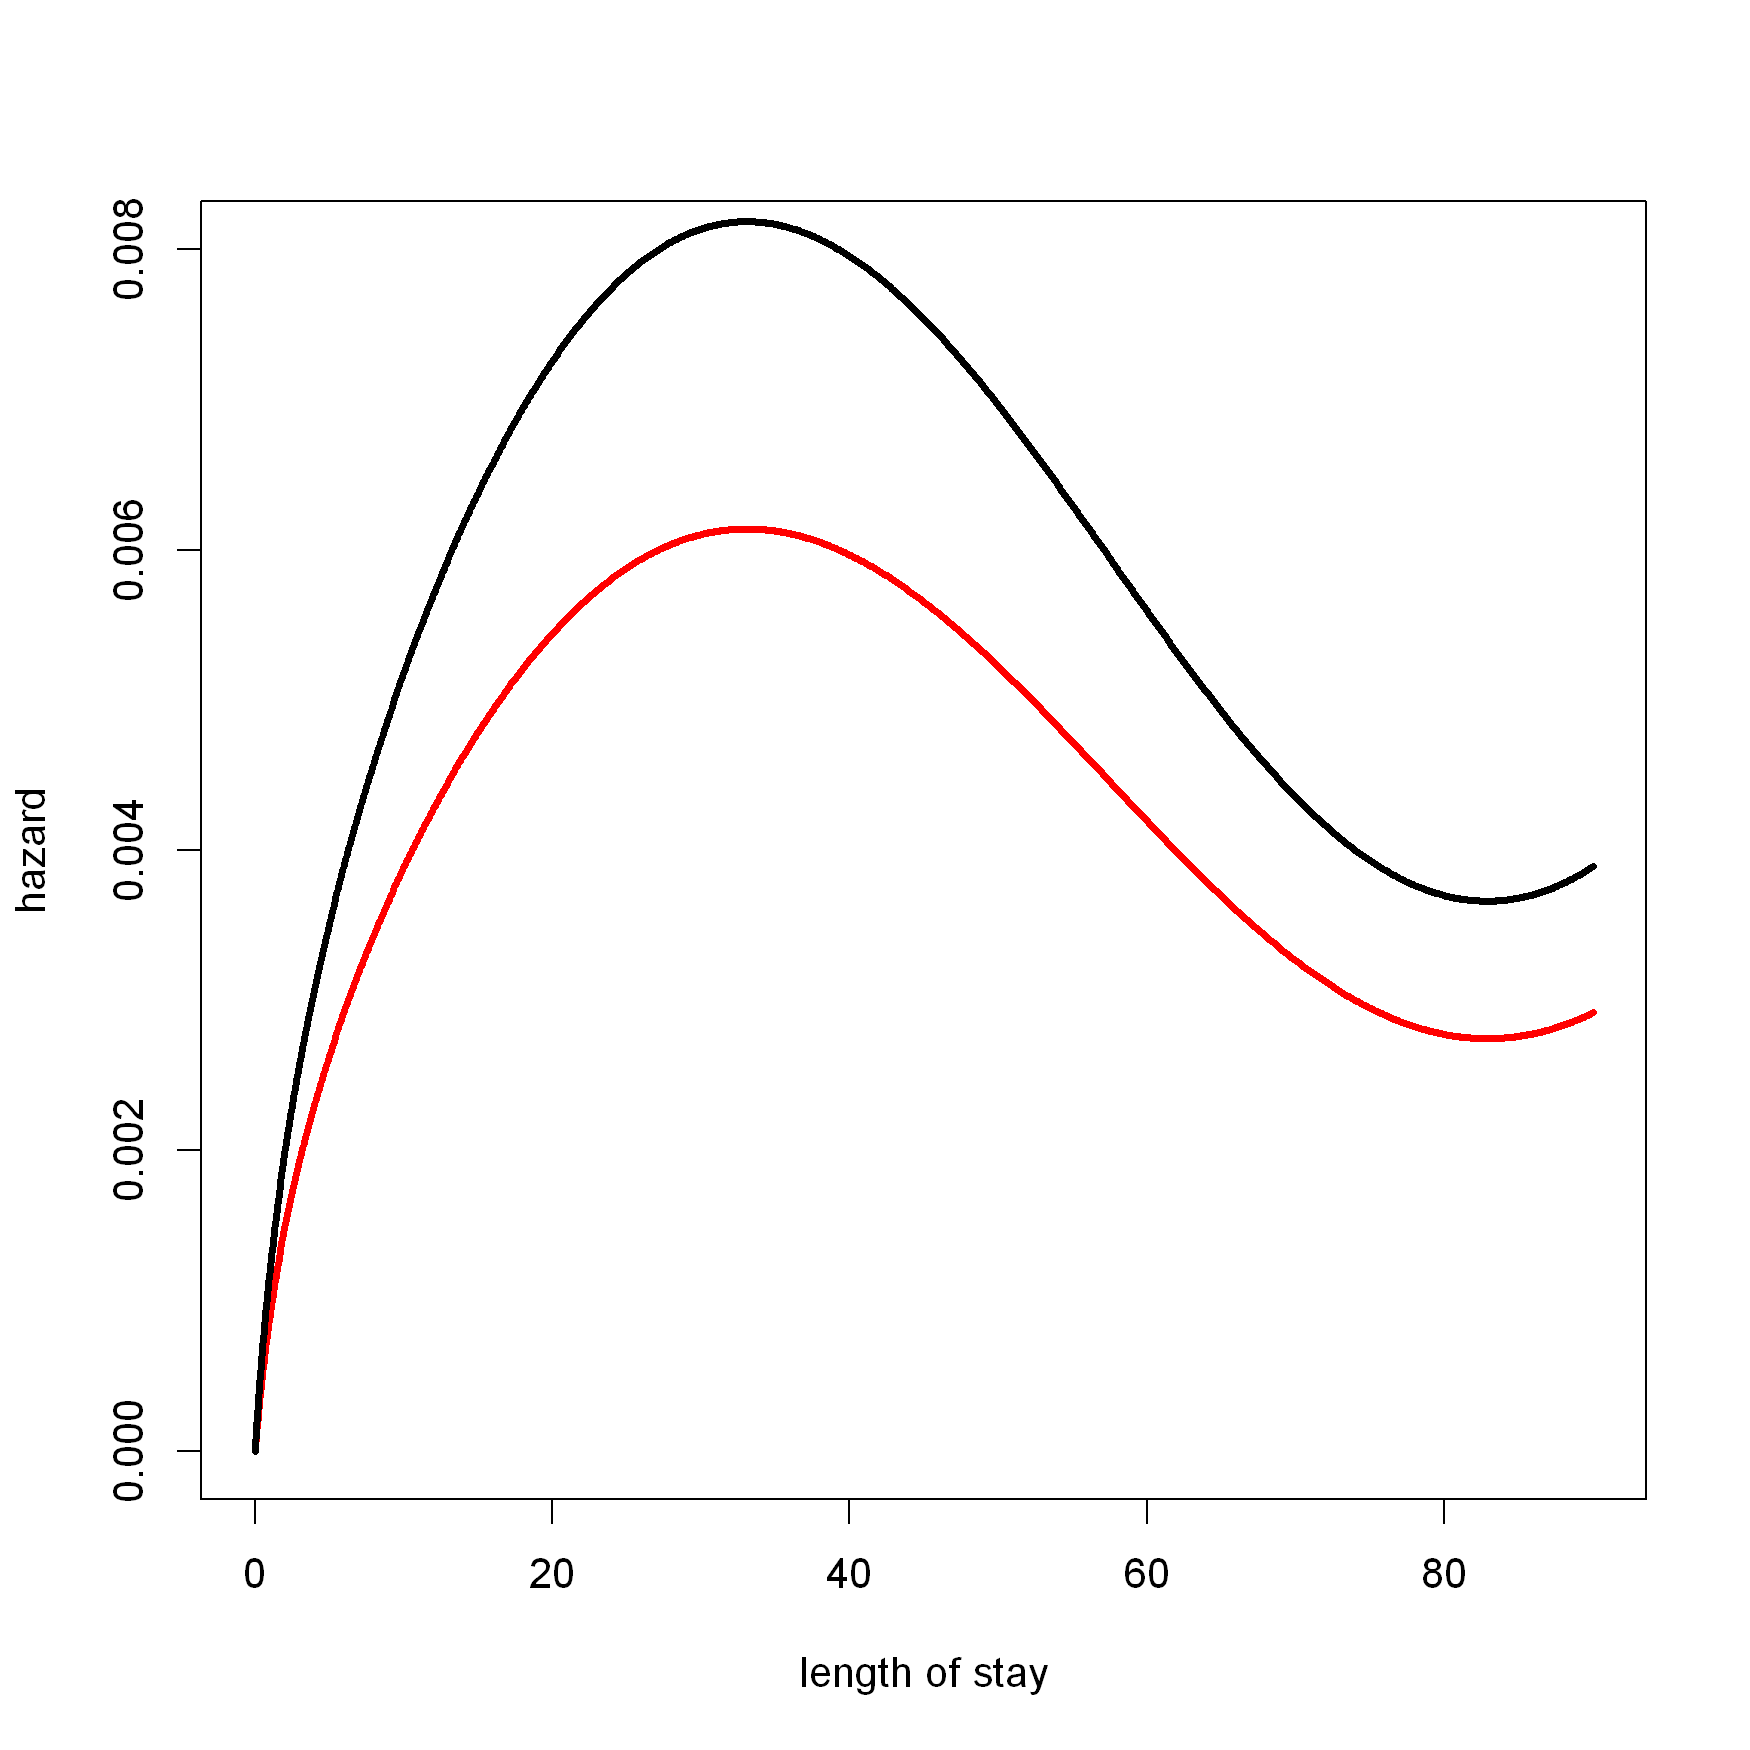

In [80]:
baseline.hazard.func <- function(t) 0.003*(sin(t/18) + 0.5*log(t+1))
t <- seq(0, 90, by = 0.1)
baseline.hazard <- baseline.hazard.func(t)
m.x <- 0.75

# proportional hazards plot
x.hazard.ph <- m.x*baseline.hazard.func(t)
plot(t, x.hazard.ph, 
     type = 'l', lwd = 3, col = 'red',
     ylim = c(0, 0.008), xlab = "length of stay", ylab = "hazard")
lines(t, baseline.hazard, type = 'l', lwd = 3)

As we can see, the red curve changes every value in the baseline hazard function by the same multiplicative factor of $0.75$.

Now, let's look at the proportions between the hazard functions for those patients within covariate level $x$ and those with a different level $\tilde{x}$.  This is also known as a **hazard ratio**.
\begin{align*}
\frac{\lambda(t,\tilde{x})}{\lambda(t,x)} &=\frac{m(\tilde{x}) \cdot \lambda_0(t) }{m(x) \cdot \lambda_0(t)} \\
&=\frac{m(\tilde{x}) }{m(x)} \\
&= \frac{\exp \big\{ \beta_1 \tilde{x} \big\}}{ \exp \big\{ \beta_1 x \big\}} \\
&= \exp \big\{ \beta_1 (\tilde{x} - x) \big\} \\
\end{align*}

You can observe two things:
- The underlying baseline hazard cancels out, and the hazard ratio reduces to the ratio of multiplicative factors between the two levels $\tilde{x}$ and $x$.
- The ratio has no dependence on the particular values of $x$. The only thing that matters is the difference $\tilde{x} - x$.

Using this, we can make an interpretation for our coefficient of interest.  Set $\tilde{x} = x + 1$.  Then by rearranging, we can claim.
\begin{align*}
\frac{\lambda(t,x+1)}{\lambda(t,x)} &= \exp \big\{ \beta_1 \cdot 1 \big\} \\
\beta_1 &= \log \frac{\lambda(t,x+1)}{\lambda(t,x)}
\end{align*}
The coefficient in the model represents the log hazard ratio when $x$ increases by one unit, regardless of what the original value of $x$ is.  This interpretation is especially useful for binary $x$ variables, since the coefficient then corresponds to the log hazard ratio between the two groups they define.  Furthermore, if we are adjusting for several other variables, we can define 
\begin{align*}
\tilde{x}_1 &= x_1+1 \\
\tilde{x}_2 &= x_2 \\
\tilde{x}_3 &= x_3 \\
&\ldots
\end{align*}

and we get a very similar interpretation.  When you compute the hazard ratio, the terms with $\beta_2, \beta_3, \ldots$ will cancel out.  We will then simply be left with $\exp \{ \beta_1 \}$ again.  Thus you can consider two populations.  Both have the same exact levels for the confounding variables, the second population has a one unit increase in $x_1$ than the first population.  $\beta_1$ describes the log hazard ratio between these populations.  The important insight is that this value is the same *regardless* of what the common confounding level or level of $x_1$ is.

### Accelerated Failure Time Model

In the proportional hazards model, we decided to model things like
$$\lambda(t,x) = m(x) \cdot \lambda_0(t) $$

In the accelerated failure time model, we instead model things as follows:
$$\lambda(t,x) = m(x) \cdot \lambda_0\big(m(x) \cdot t \big)$$

This can be interpreted as using the coefficients to produce both a multiplicative scaling of the hazard function but also a time dilation.  What does the latter mean?  If the baseline hazard's shape moves through a particular trajectory, then when $m(x) = 2$ it will move through that trajectory twice as fast.  Here's a visual example with $m(x) = 0.75$, so we should expect a slight slowing of the trajectory.

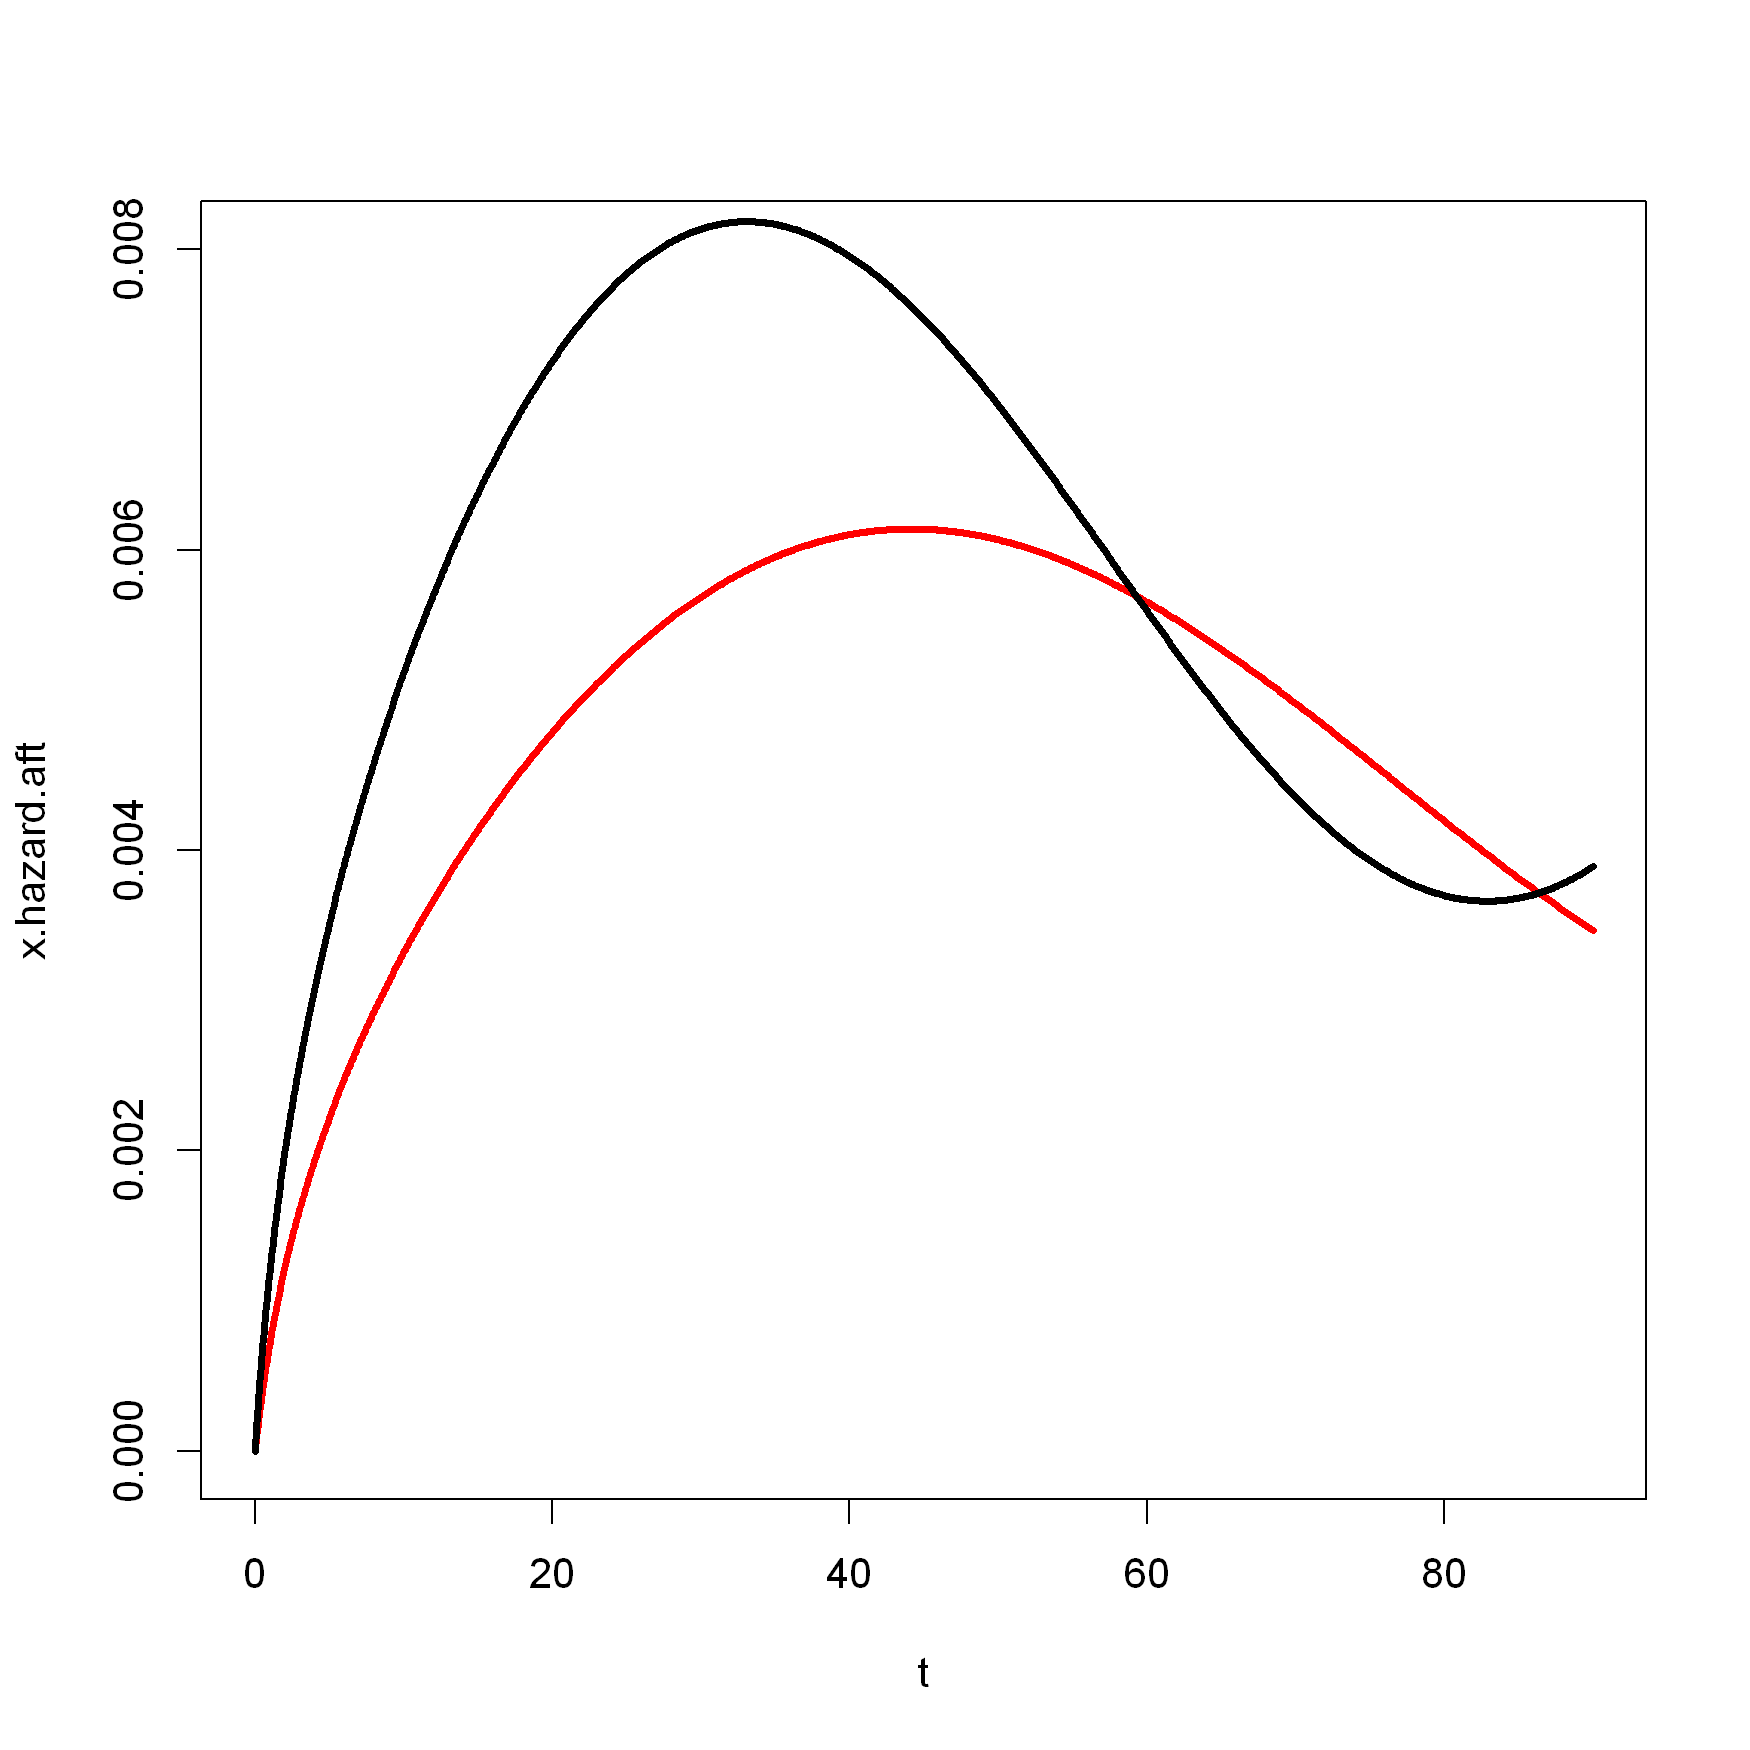

In [81]:
# accelerated failure time plot
m.x <- 0.75
x.hazard.aft <- m.x*baseline.hazard.func(m.x*t)
plot(t, x.hazard.aft, 
     type = 'l', lwd = 3, col = 'red',
     ylim = c(0, 0.008))
lines(t, baseline.hazard, type = 'l', lwd = 3)

This is similar to the previous plot for the PH model in that the baseline hazard is proportionally shrunk.  However, now you can see the time-dilation effect.  For example, the peak of the trajectory has moved from ~35 days to ~45 days.  You can see that the hazard functions now also may cross; this can never happen in a proportional hazards model by design.

This interpretation through time-dilation actually results in an extremely simple equation for the survival function in this model:
$$ S(t, x) = S_0\big( m(x) \cdot t \big) $$
There now is some sort of "baseline" survival function $S_0(t)$.  The covariates have an effect through providing a multiplicative factor that "speeds up" or "slows down" time relative to the baseline. 

For example, suppose the event is remission from cancer under a standard-treatment regime, denoted by $x=0$.  Let $x=1$ represent an experimental treatment. Suppose we learn that $\frac{m(1)}{m(0)} = 2$. Then if the median time-to-remission in the standard-treatment cancer population is 200 days, then we can immediately know that the estimated median time-to-remission for the experimental group is 100 days, since their trajectory is twice as fast.

Here's a visualization of the survival functions derived from the made-up hazard functions that I just showed you.

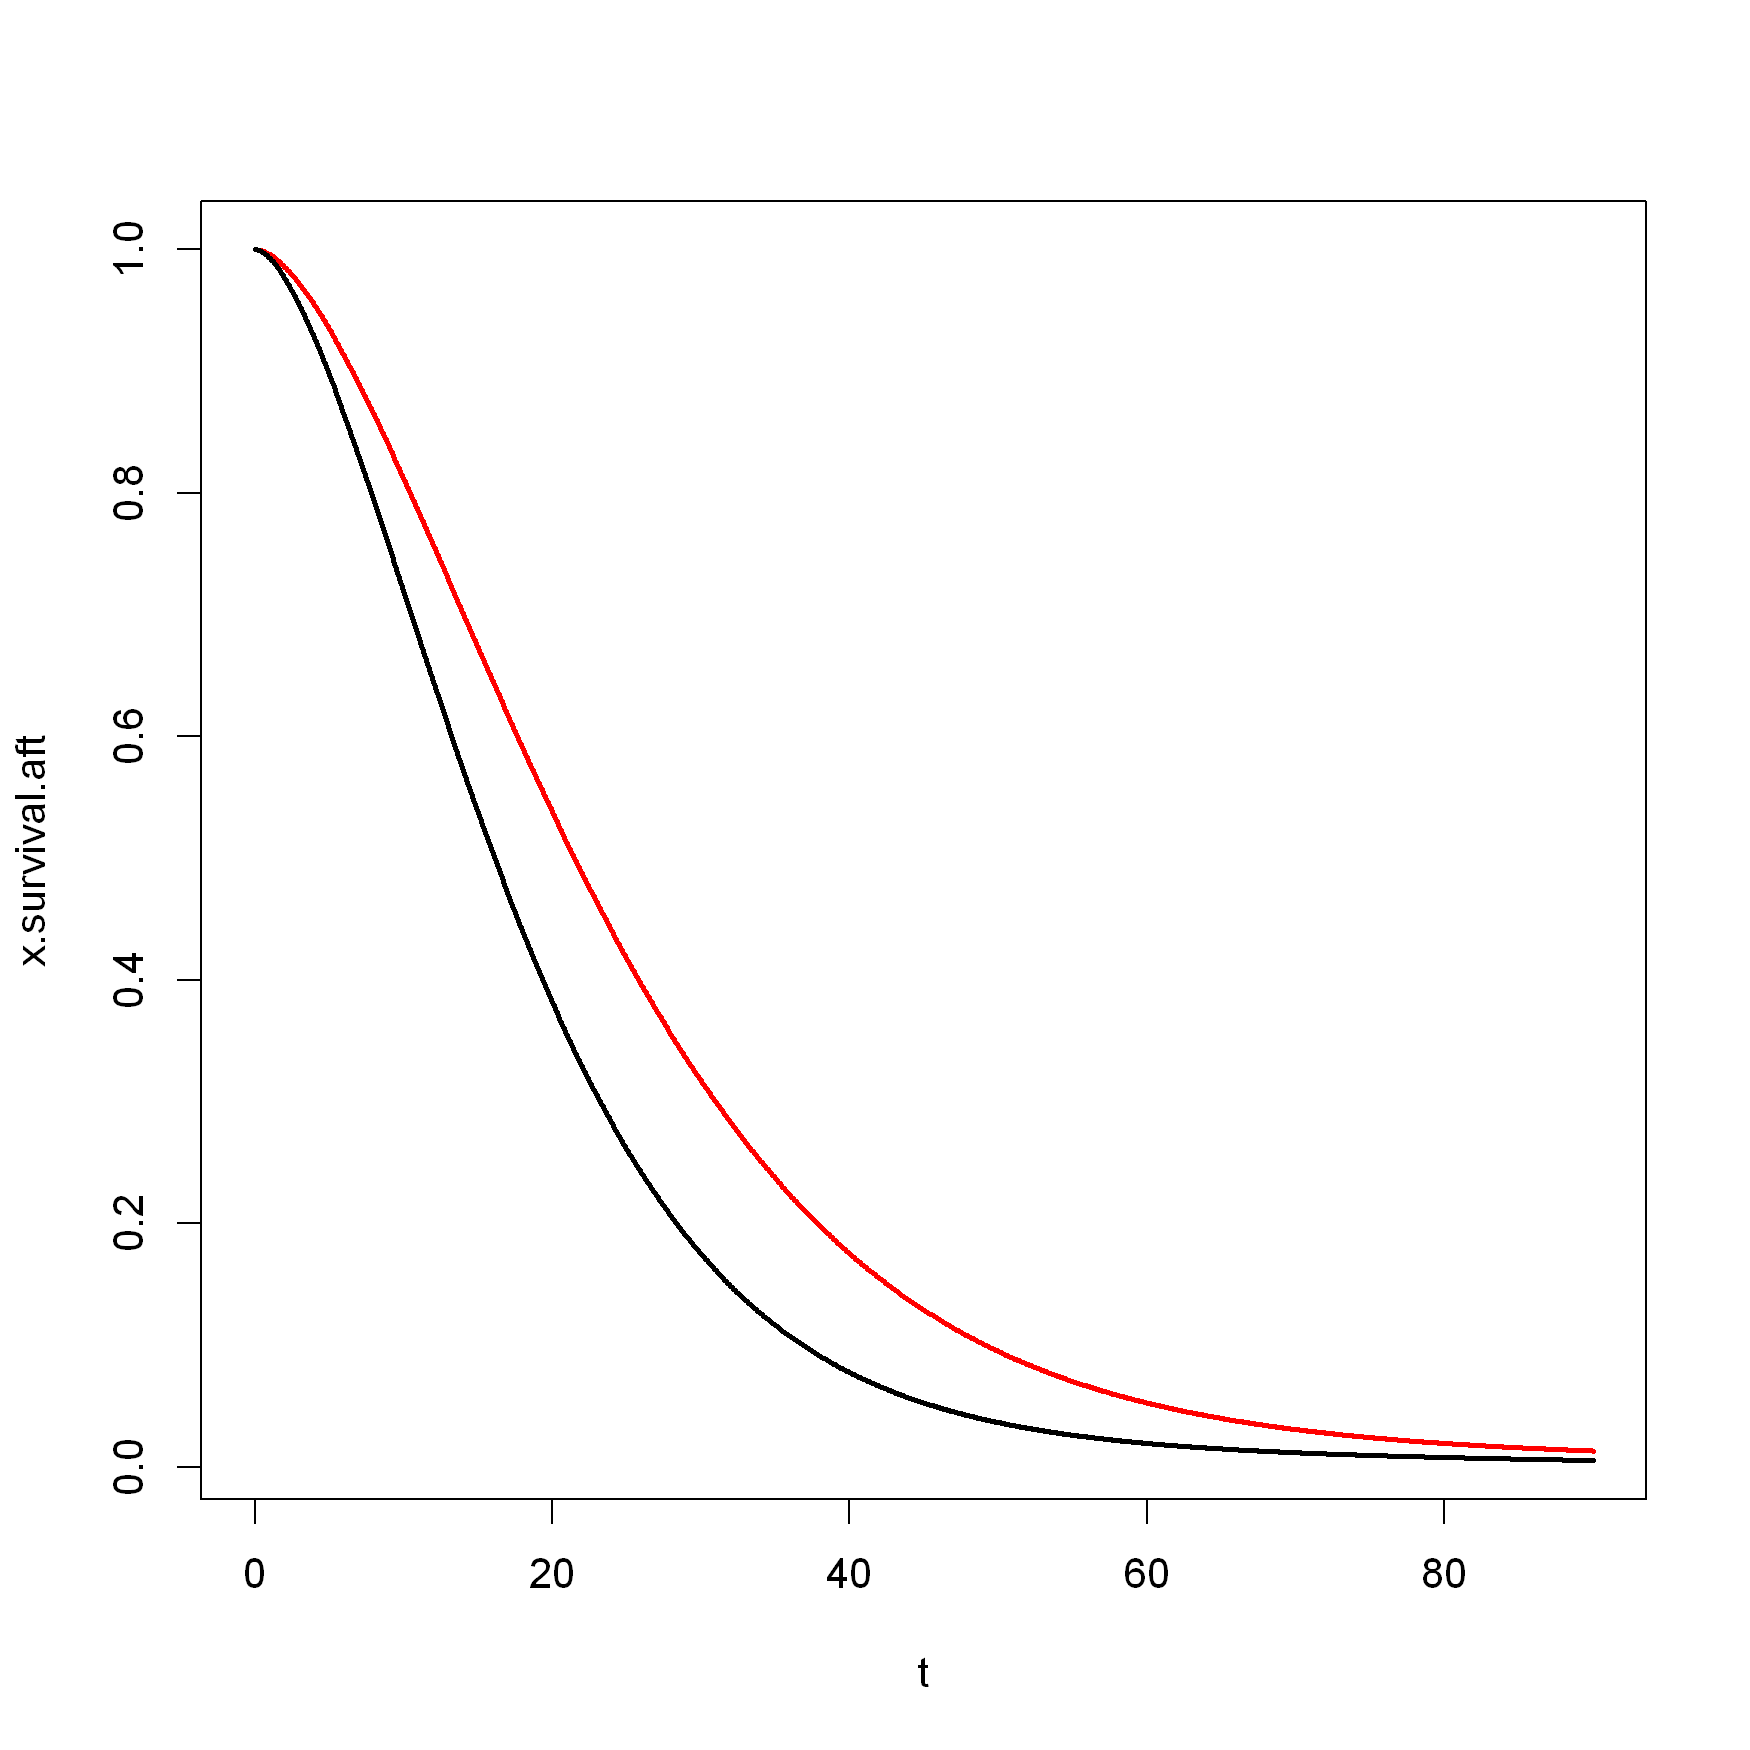

In [82]:
baseline.survival <- exp(-cumsum(baseline.hazard))
x.survival.aft <-exp(-cumsum(x.hazard.aft))
plot(t, x.survival.aft, 
     type = 'l', lwd = 2, col = 'red')
lines(t, baseline.survival, type = 'l', lwd = 2)

It should be intuitive that in an AFT model, the estimated survival functions can never cross, since all curves are just time-dilations of one another.  For any quantile or mean for the time-to-event in the black baseline survival function, we can automatically get that statistic for the red survival function by simply multiplying the baseline statistic by $\tfrac{1}{m(x)} = \tfrac{1}{0.75} = 1.3333$.  In this case, all measures of location are simply $33\%$ larger in the red group vs baseline.

In real life data, it is certainly possible for survival curves to cross when comparing subpopulations, which indicates that both the PH and AFT models would not be appropriate.

# Censored Survival Analysis
## Censoring
Note that in the framework of survival analysis, we assume every individual has a true time-to-event that falls in $(0, \infty)$, even if its inplausibly far into the future (like hundreds of years later). Given the constraints of real-life data collection and the fact that people eventually die before certain events can ever take place, the information that we can practically gain from each individual is often only partial.  This partial data is a result of a process we call **censoring**.

There are 3 types of censoring:
- **Left** Censoring occurs when the event is known to have already occurred, but we are not sure of how far in the past.  This is a rare situation practically and usually occurs because we missed appropriate window of observation.
- **Interval** Censoring is the same thing as Left Censoring (we missed the event), but we can also identify an earlier timepoint when the subject had not experienced the event yet.  The event is only known to lie in an interval. A practical situation could be when study participants are brought in and measured/test monthly.  At each visit, we know a patient with a newly discovered event likely experienced the event before this visit but certainly after the previous visit.
- **Right** censoring is the most common type of censoring and will be the focus of our exposition.  This usually occurs because, for some reason, we lose the ability to continue data collection on a subject.  This means that the event time is some unknown value that is larger than what we observed.

### Right Censoring

There are a wide variety of recognized ways through which subjects become right censored:
- **Loss to follow-up:** a patient moves or simply stops showing up
- **End of Study:** a stopping criteria is fulfilled; either enough patients experienced the event or a pre-allotted amount of time has passed
- **Competing Event:** a patient experiences a different event which either prevents them from experiencing the target event (e.g. death) or violates the study's definition of the target event (e.g. heart failure w/o previous history of myocardial infarction)
- **Ineligibility:** something occurs that causes a patient to no longer be eligible for the trial

For a moment, we shall consider only one type of censoring to occur in our data, say loss to follow-up.  When a patient is right censored, the type of data we must examine needs to be slightly broadened.  We must collect the time-duration observed $T$ just as before.  But we must also consider a binary marker of if that patient was censored or not.  Let $\delta$ be such a marker, taking a 1 if patient was observed to experience the target event.  For clarity, a single patient's data might look like $(T, \delta) = (17.2, 0)$ if they were lost to follow-up, and we could only observe that they didn't experience the event for 17.2 units of time.

Our length-of-stay variable was not censored.  Let's introduce some artificial censoring with the following code just to see what a practical dataset might look like.

In [91]:
set.seed(121)
censor.time <- rgamma(nrow(df), shape = 2, rate = 0.1)
df$delta <- df$los < censor.time # target event happened before "censoring" time

# make copy of los to modify; replaced data chosen for censoring with censor times
df$T.censored <- df$los
df$T.censored[!df$delta] <- censor.time[!df$delta]

# cast delta to numeric from logical
df$delta <- as.numeric(df$delta)

# print first few rows and mean number of people who were censored
head(df[,c("T.censored", "delta")], 8)
print(paste("Censored Fraction:", round(1 - mean(df$delta), 3)))

T.censored,delta
9.810417,1
25.040116,0
2.827083,1
6.763889,1
0.850000,1
4.163784,0
2.359722,1
24.671656,0


[1] "Censored Fraction: 0.427"


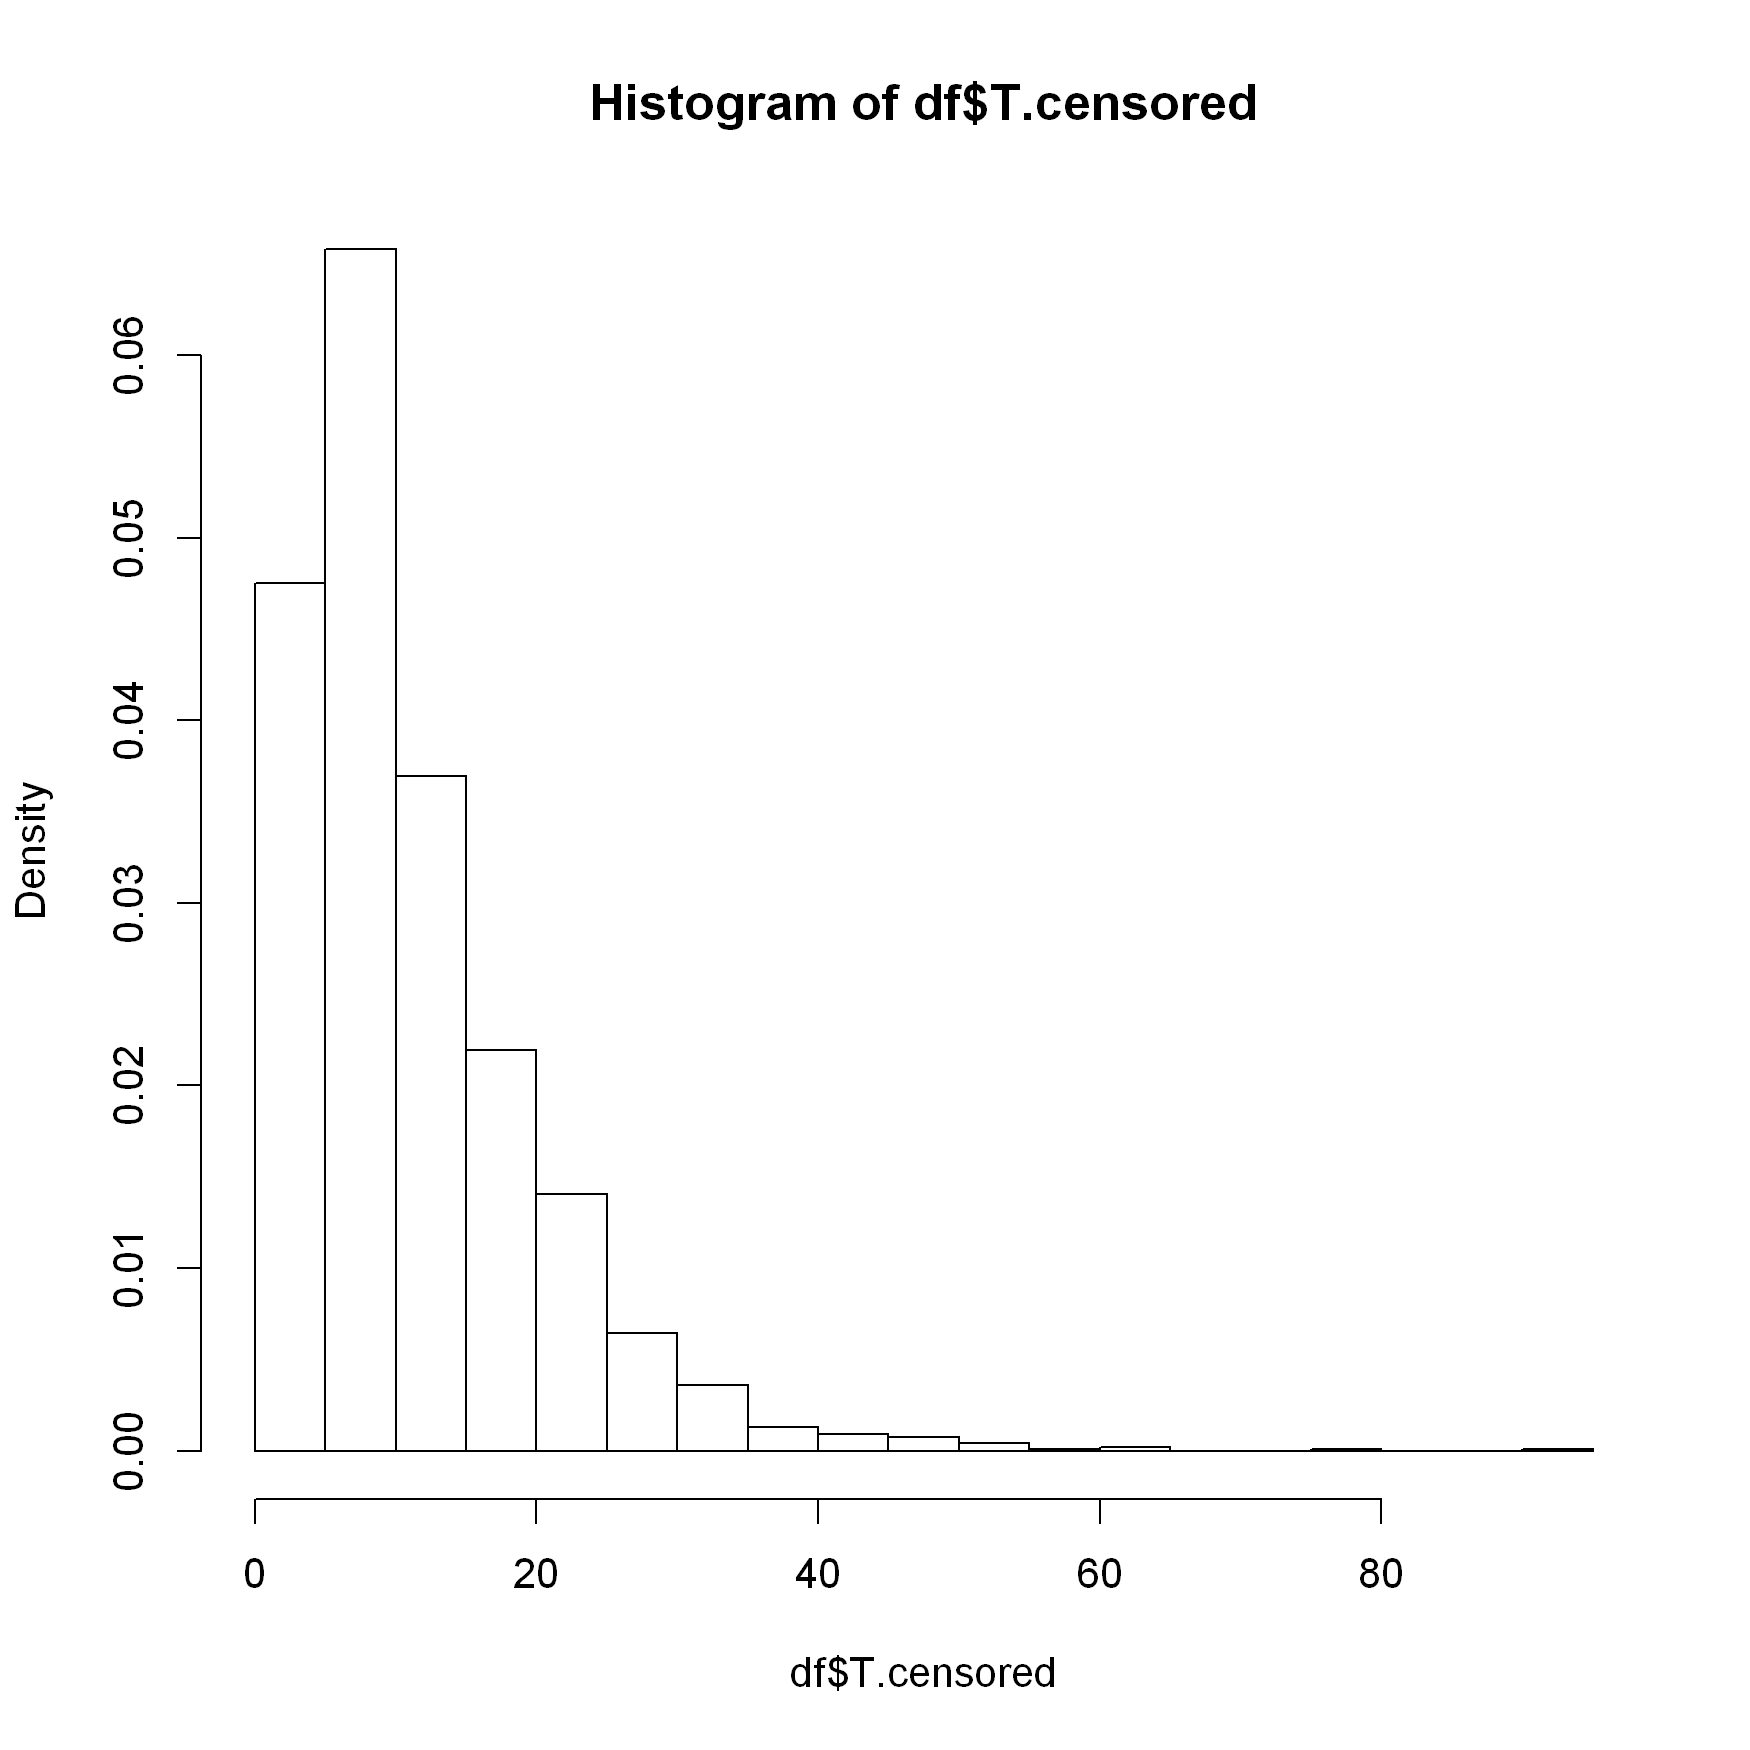

In [92]:
hist(df$T.censored, breaks = 20, prob = TRUE)

As you can see, the shape of the distribution of times is now way less skewed, since so many people get censored early on.

### Competing Events & Non-Informative Censoring

Okay, we saw approximately how things look when we have one type of censoring event.  How about another?  How aout three types of censoring? We must consider many types of events now; pretend we have some sort of variable describing the event that takes place at time $T$. If you recall one-hot encoding from last session, we can one-hot encode this event variable as $\delta_1, \delta_2, \ldots$ for all of the possible events.  We will associate $\delta_1$ with the target event of interest.  For clarity, $(T, \delta_1, \delta_2, \delta_3) = (17.2, 1, 0, 0)$ indicates someone who experienced the target event at time 17.2.

An important realization of this setup is that the target event itself and all types of censoring events are all collectively competing events!  Theoretically, there is a random "time-to-event" associated with each of them, and all we observe is the *minimum* of the collection.  For example, say $\delta_1$ represents myocardial infarction, $\delta_2$ represents loss to follow up, and $\delta_3$ represents the study end.  Suppose 
- for myocardial infarction I have $T_1 = 143159$
- for loss to follow up I have $T_2 = 72$
- for the study end everybody has $T_3 = 90$

Then my observation is $T = \min \{T_1, T_2, T_3 \} = 72$.  Based on this, I have $(\delta_1, \delta_2, \delta_3) = (0, 1, 0)$.

The modeling perspective becomes quite complicated in the general case when all these times have correlations with one another.  However, if we make a big simplifying assumption, it immediately simplifies the problem and makes analysis tractable.  We assume that all these times are *statistically independent* of each other; in other language; we assume all types of censoring / competing events are **non-informative**.

How reasonable is this assumption?  Honestly, usually not very.  Censoring due to end-of-study is the only case where this is almost guaranteed to hold.  Even something like loss to follow-up could occur if a patient drops out due to adverse side-effects that are correlated to experiencing the target event.  However, we're going to make this assumption to start.  When we get back to linear models for survival analyis, we'll see how we can weaken this assumption to make it much more reasonable.

If we make the mutual independence assumption, two important things occur
- Practically, we can lump all other competing events of non-interest into a single category of censoring.  This reduces the structure of the data back again to $(T, \delta)$ where $\delta$ is a 1 if the target event occured at time $T$ and 0 if some other event occurred.
- Theoretically, the math becomes tractable to account for the censoring.  To use the "standard" methods, we have to make this assumption.  Otherwise, we need to rely on much more sophisticated statistical analysis.

## Kaplan-Meier Estimator

The **Kaplan-Meier estimator** gives us a piece-wise constant estimate of the survival function, for censored survival data assuming non-informative censoring.  We will load in the **survival** package to do our analyses today and sometimes rely on the **autoplot** function from the **ggfortify** package for nice displays.  

The survival package makes use of the formula pattern we've seen before.  However, since the outcome of interest is now a pair of values $(T, \delta)$ plus the information on what direction of censoring we have, we must pass this information through the **Surv** function for R to know how to handle it.  The defaults for the Surv function assumes right censoring.

Below is the syntax we will use.  We use the **survfit** function to return to us Kaplan-Meier estimate of the survival function.  We can then plot this information, and it automatically gives us confidence intervals in a shaded region.  Confidence intervals here should be interpreted pointwise, e.g. at $t = 40$, the shaded region represent a confidence interval for the survival probability at time $t=40$.  They are not confidence intervals that completely capture the entire function at a $95\%$ rate.

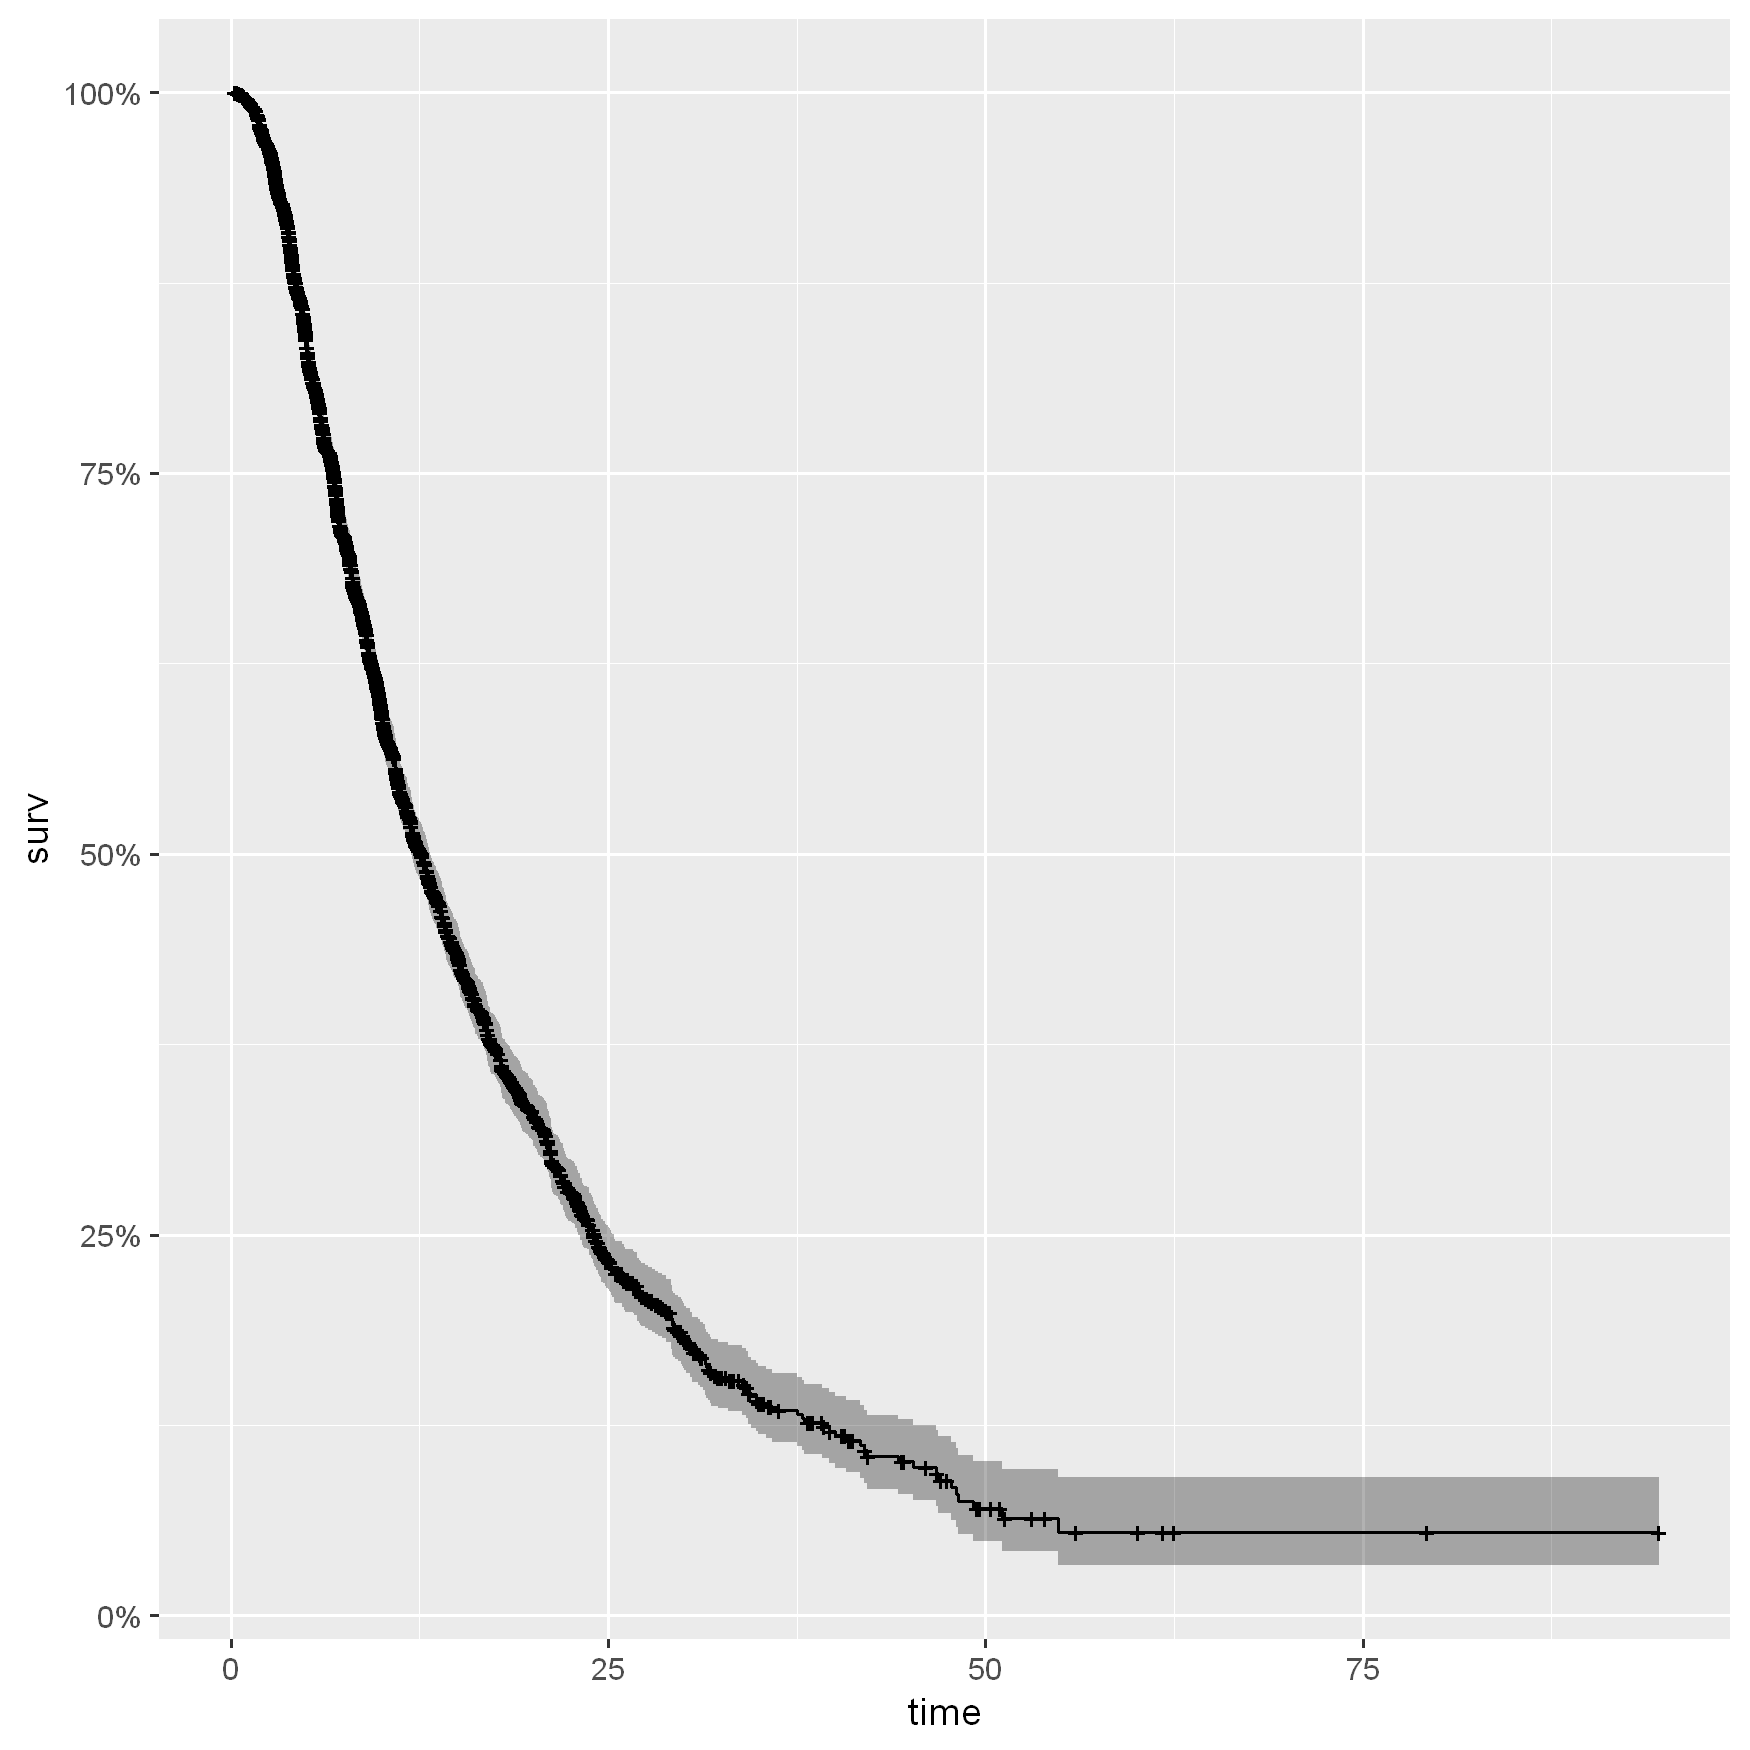

In [99]:
#install.packages("survival")
#install.packages("ggfortify")
library(survival)
library(ggfortify)

# plot survival curve with censoring in black (and confidence intervals)
km.fit <- survfit(Surv(T.censored, delta) ~ 1, data=df)
autoplot(km.fit)

In [ ]:
install.packages("survival")

I haven't overlaid the original plot we created when there was no censoring.  But I've verified that it is nearly exactly the same.  So even though we lost information due to the random censoring, the Kaplan-Meier estimate still got extremely close to the uncensored estimate.

### A Rough Visualization of the Hazard Function

From our KM estimate of the survival function, we can derive an estimate of the cumulative hazard function via the relationship. 
$$\Lambda(t) = - \log(S(t)) $$
As you may recall, this can be useful by examining the curvature and guessing what the hazard function might look like. The survfit function automatically calculates this for you, so we can simply extract and plot the cumulative hazard function.  By the curvature, we'll get a sense of the hazard function.

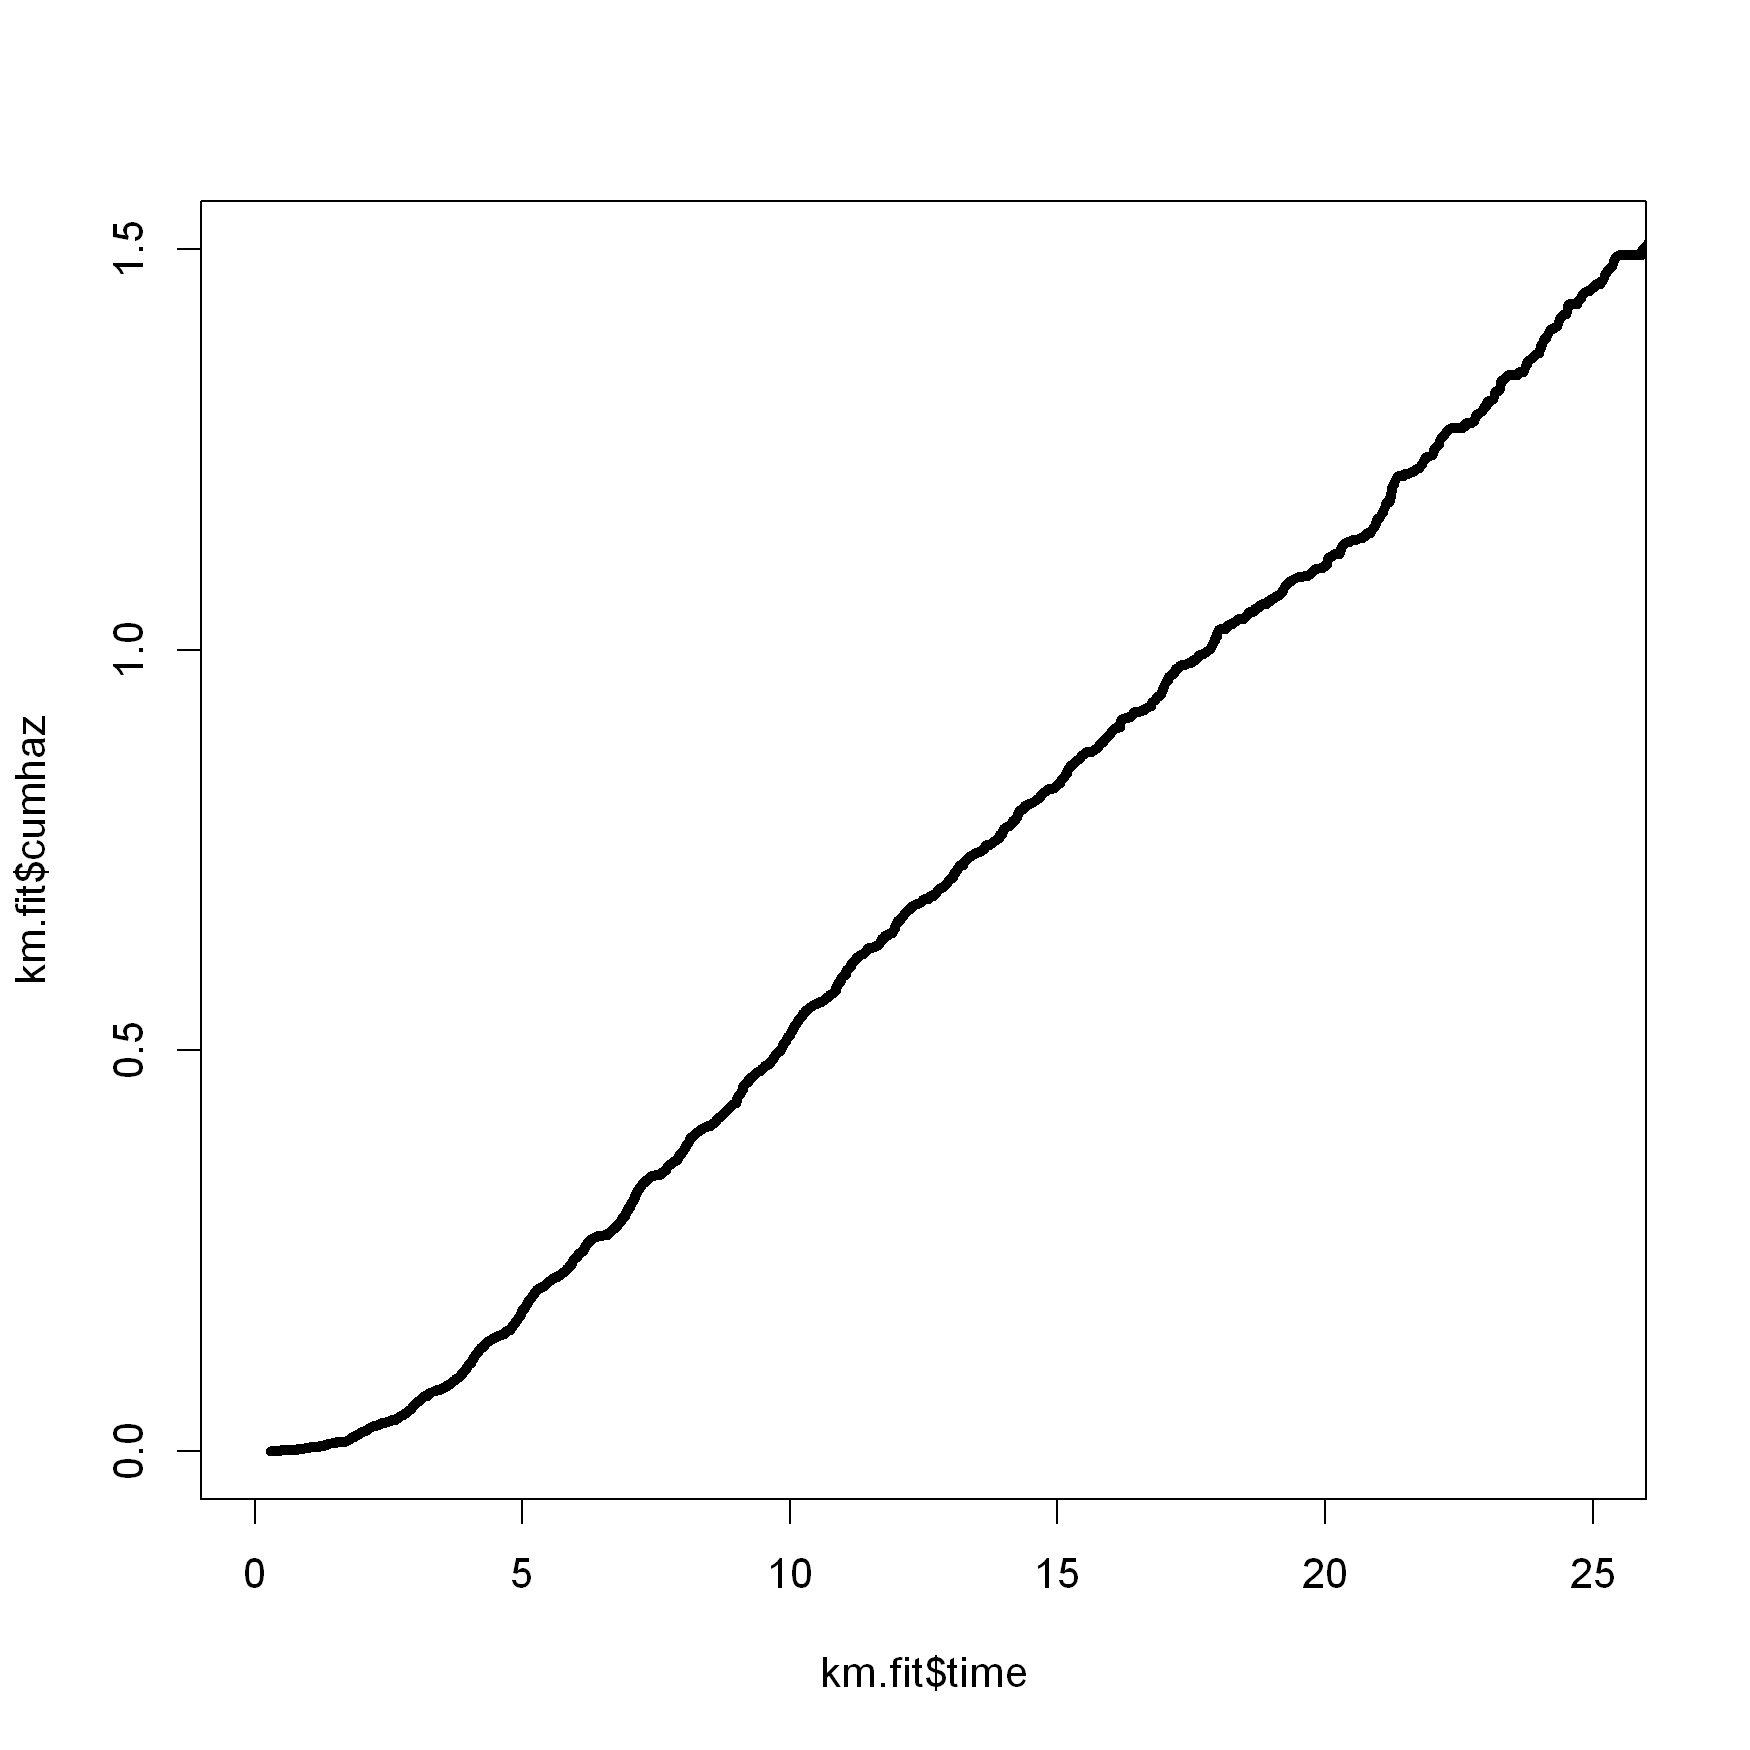

In [103]:
plot(km.fit$time, km.fit$cumhaz, 
     type = 'l', lwd = 4,
     xlim = c(0,25), ylim = c(0,1.5))

There are more sophisticated ways of getting plots of the estimated hazard function directly to do your model checking or whatever, but these rely on additional packages, so we won't get into that in this course.

As a side note, if you come across the **Nelson-Aalen estimator**, this is a different popular way to estimate the cumulative hazard function directly.

## The Log-Rank Test

Okay, now for associations!  We have a discrete variable such as femalesex and we want to know what the KM-curves look like in each group.  How do we do this?  Similar syntax to what we've seen earlier.  We can plot just as before.

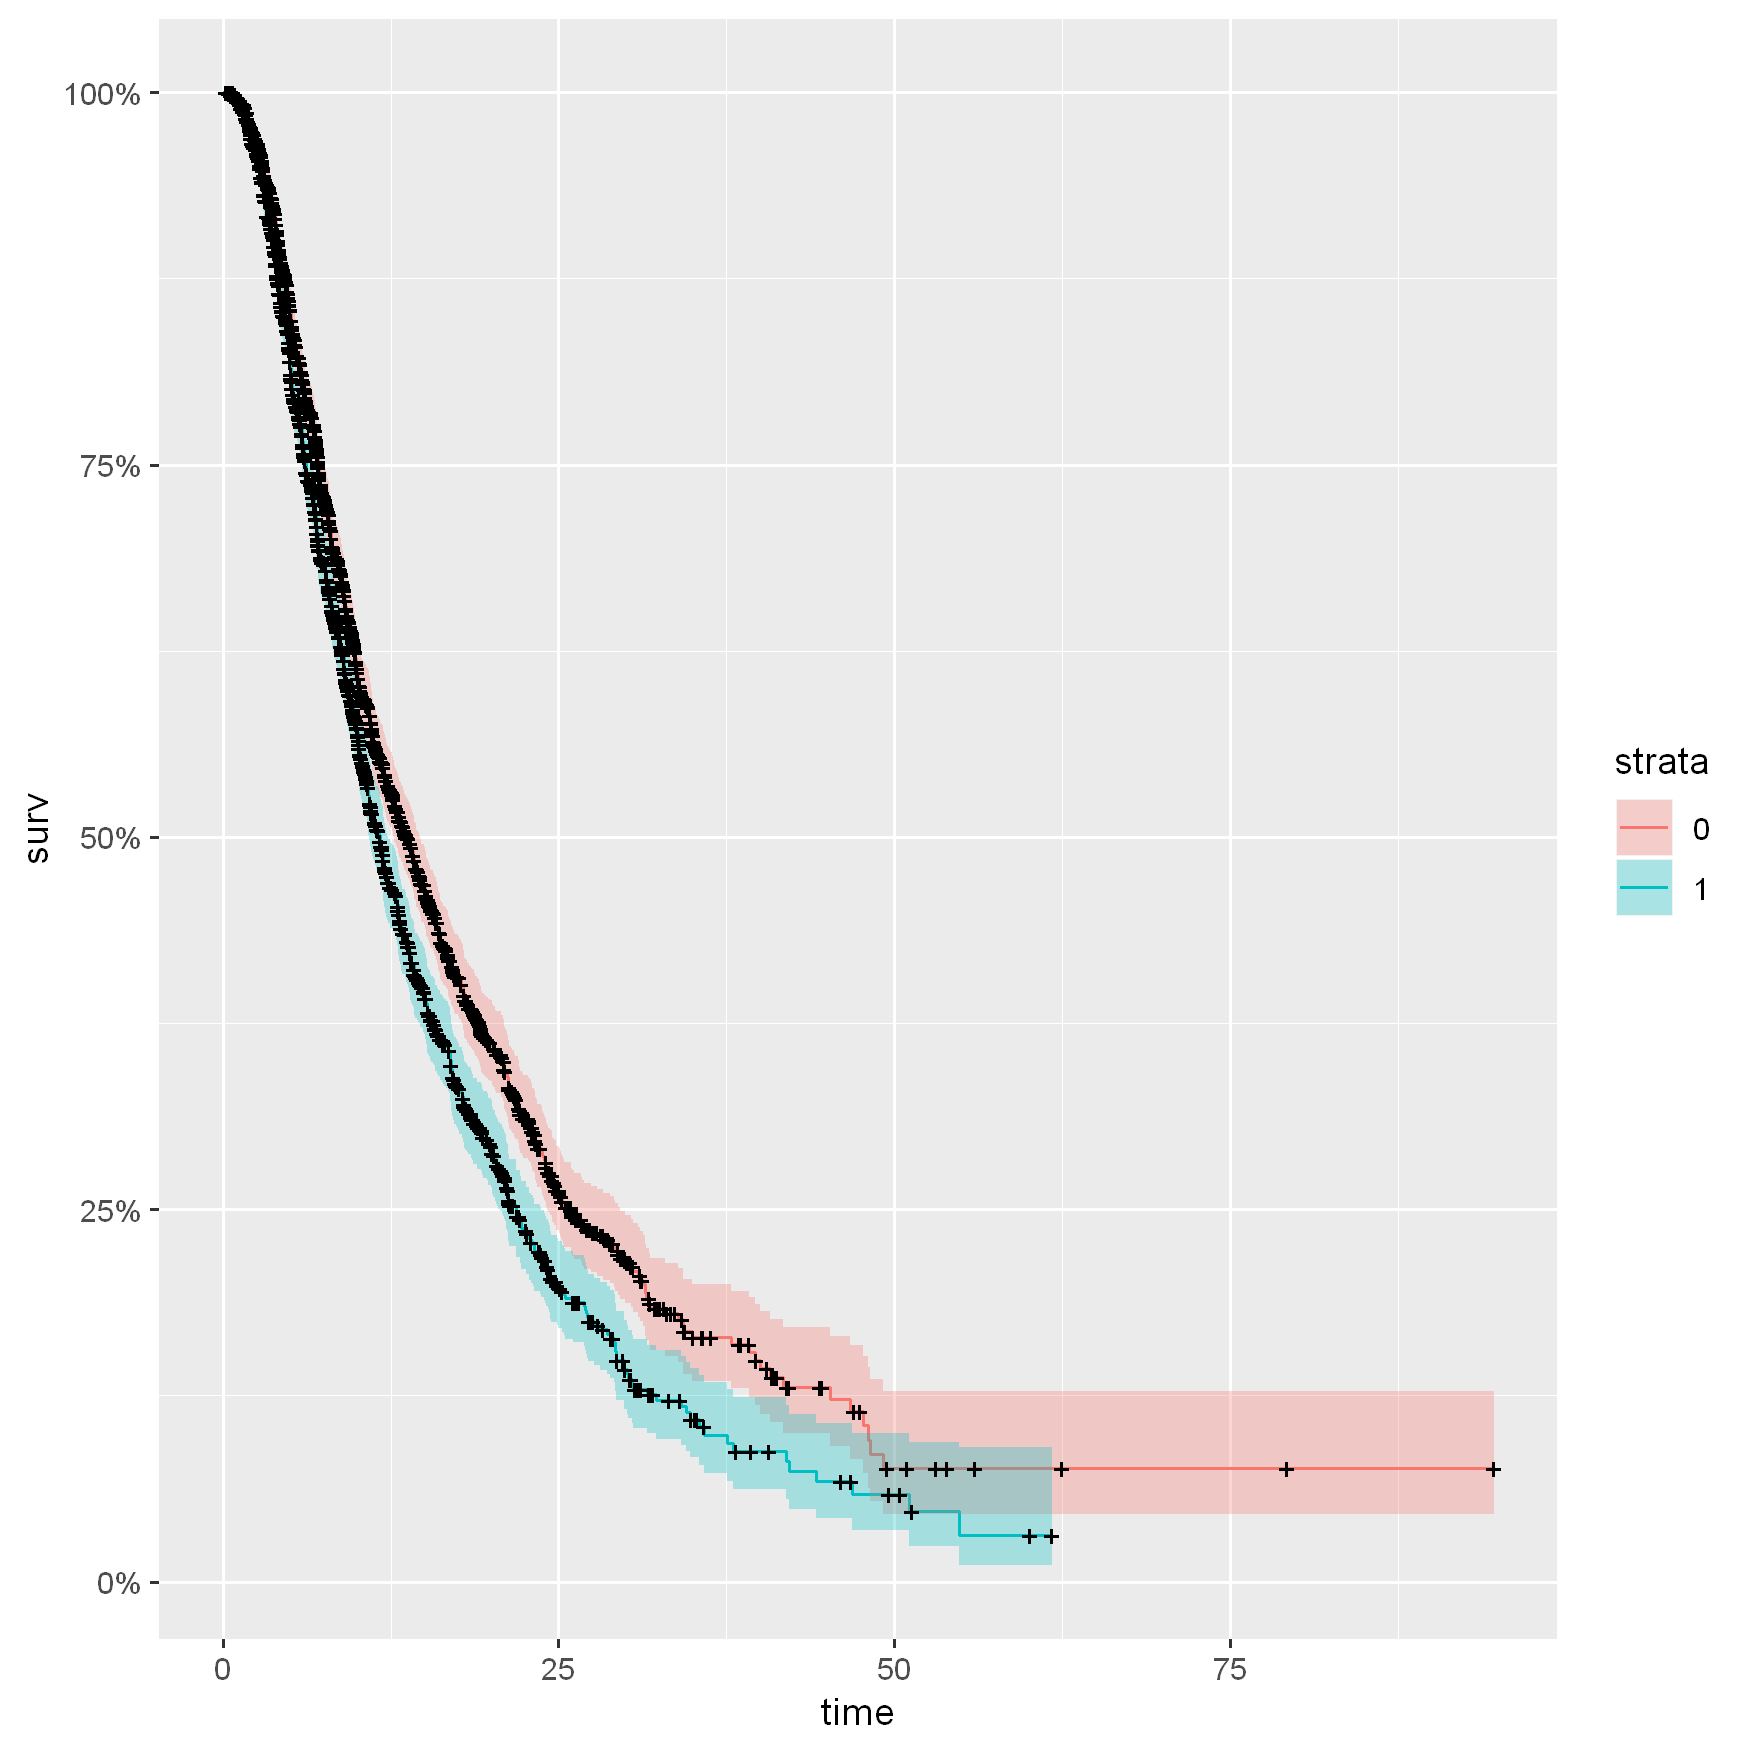

In [94]:
# plot survival curve with censoring in black (and confidence intervals)
km.fit <- survfit(Surv(T.censored, delta) ~ femalesex, data=df)
autoplot(km.fit)

How do we test for statistical significance between these two curves?  Actually, let's take it back a notch.  Pop quiz!

How might we test for statistical significance if there was *no* censoring involved?  In this case, what we're trying to tease out is if there is a difference in distribution in a continuous variable $T$ between two groups.  Take a moment to think back to Session 3 on hypothesis testing and try to recall if there is a test which can be used here.  Ready for the answer?

The ranksum test!  Here, ensure not to interpret it as a test of medians.  The shape/scales of the two groups are pretty much never the same in this kind of data.

Now to handle the case when we have censoring.  We have to use a new type of test called the **log-rank test**.  This test makes the same type of assumptions as the KM estimate.  Also note that this is an asymptotic test, which means the sample size must be sufficiently large.  We can implement it as follows with the **survdiff** function:

In [95]:
survdiff(Surv(T.censored, delta) ~ femalesex, data=df)

Call:
survdiff(formula = Surv(T.censored, delta) ~ femalesex, data = df)

               N Observed Expected (O-E)^2/E (O-E)^2/V
femalesex=0 1874     1037     1131      7.82      18.6
femalesex=1 1542      920      826     10.71      18.6

 Chisq= 18.6  on 1 degrees of freedom, p= 2e-05 

As we'd expect from the plot and our sample size, the results are extremely significant.  You can interpret the null hypothesis to be that the survival curves are the same, and the alternative to be that they are different.  

However, one note of caution.  The log-rank test has low power when the two survival curves cross, and you may want to consider other more sophisticated approaches.  On the other hand, when the proportional hazards assumption holds, the log-rank test is actually the most powerful test possible.  Next, I'll give you an estimator/visualization that you can use to check proportional hazards between two groups.

### In-Class Exercise 3: Time-to-Dishcharge vs Diabetes

1. Copy and run the following code to mimic censoring.  Your time-to-event and censoring variables will be "T.censored" and "delta", respectively.

In [201]:
set.seed(121)
censor.time <- rgamma(nrow(df), shape = 2, rate = 0.1)
df$delta <- df$los < censor.time
df$T.censored <- df$los
df$T.censored[!df$delta] <- censor.time[!df$delta]
df$delta <- as.numeric(df$delta)

2. Using this censored time-to-event outcome, plot the KM estimates of the survival function for those with and without a diabetes with complications diagnosis (diabetescomp_elx_hospital).  If you didn't install the ggfortify package, you can simply use the regular plot function here instead of autoplot.
3. Perform a log-rank test to decide if these curves are significantly different.  State a full interpretation of your results in a comment.

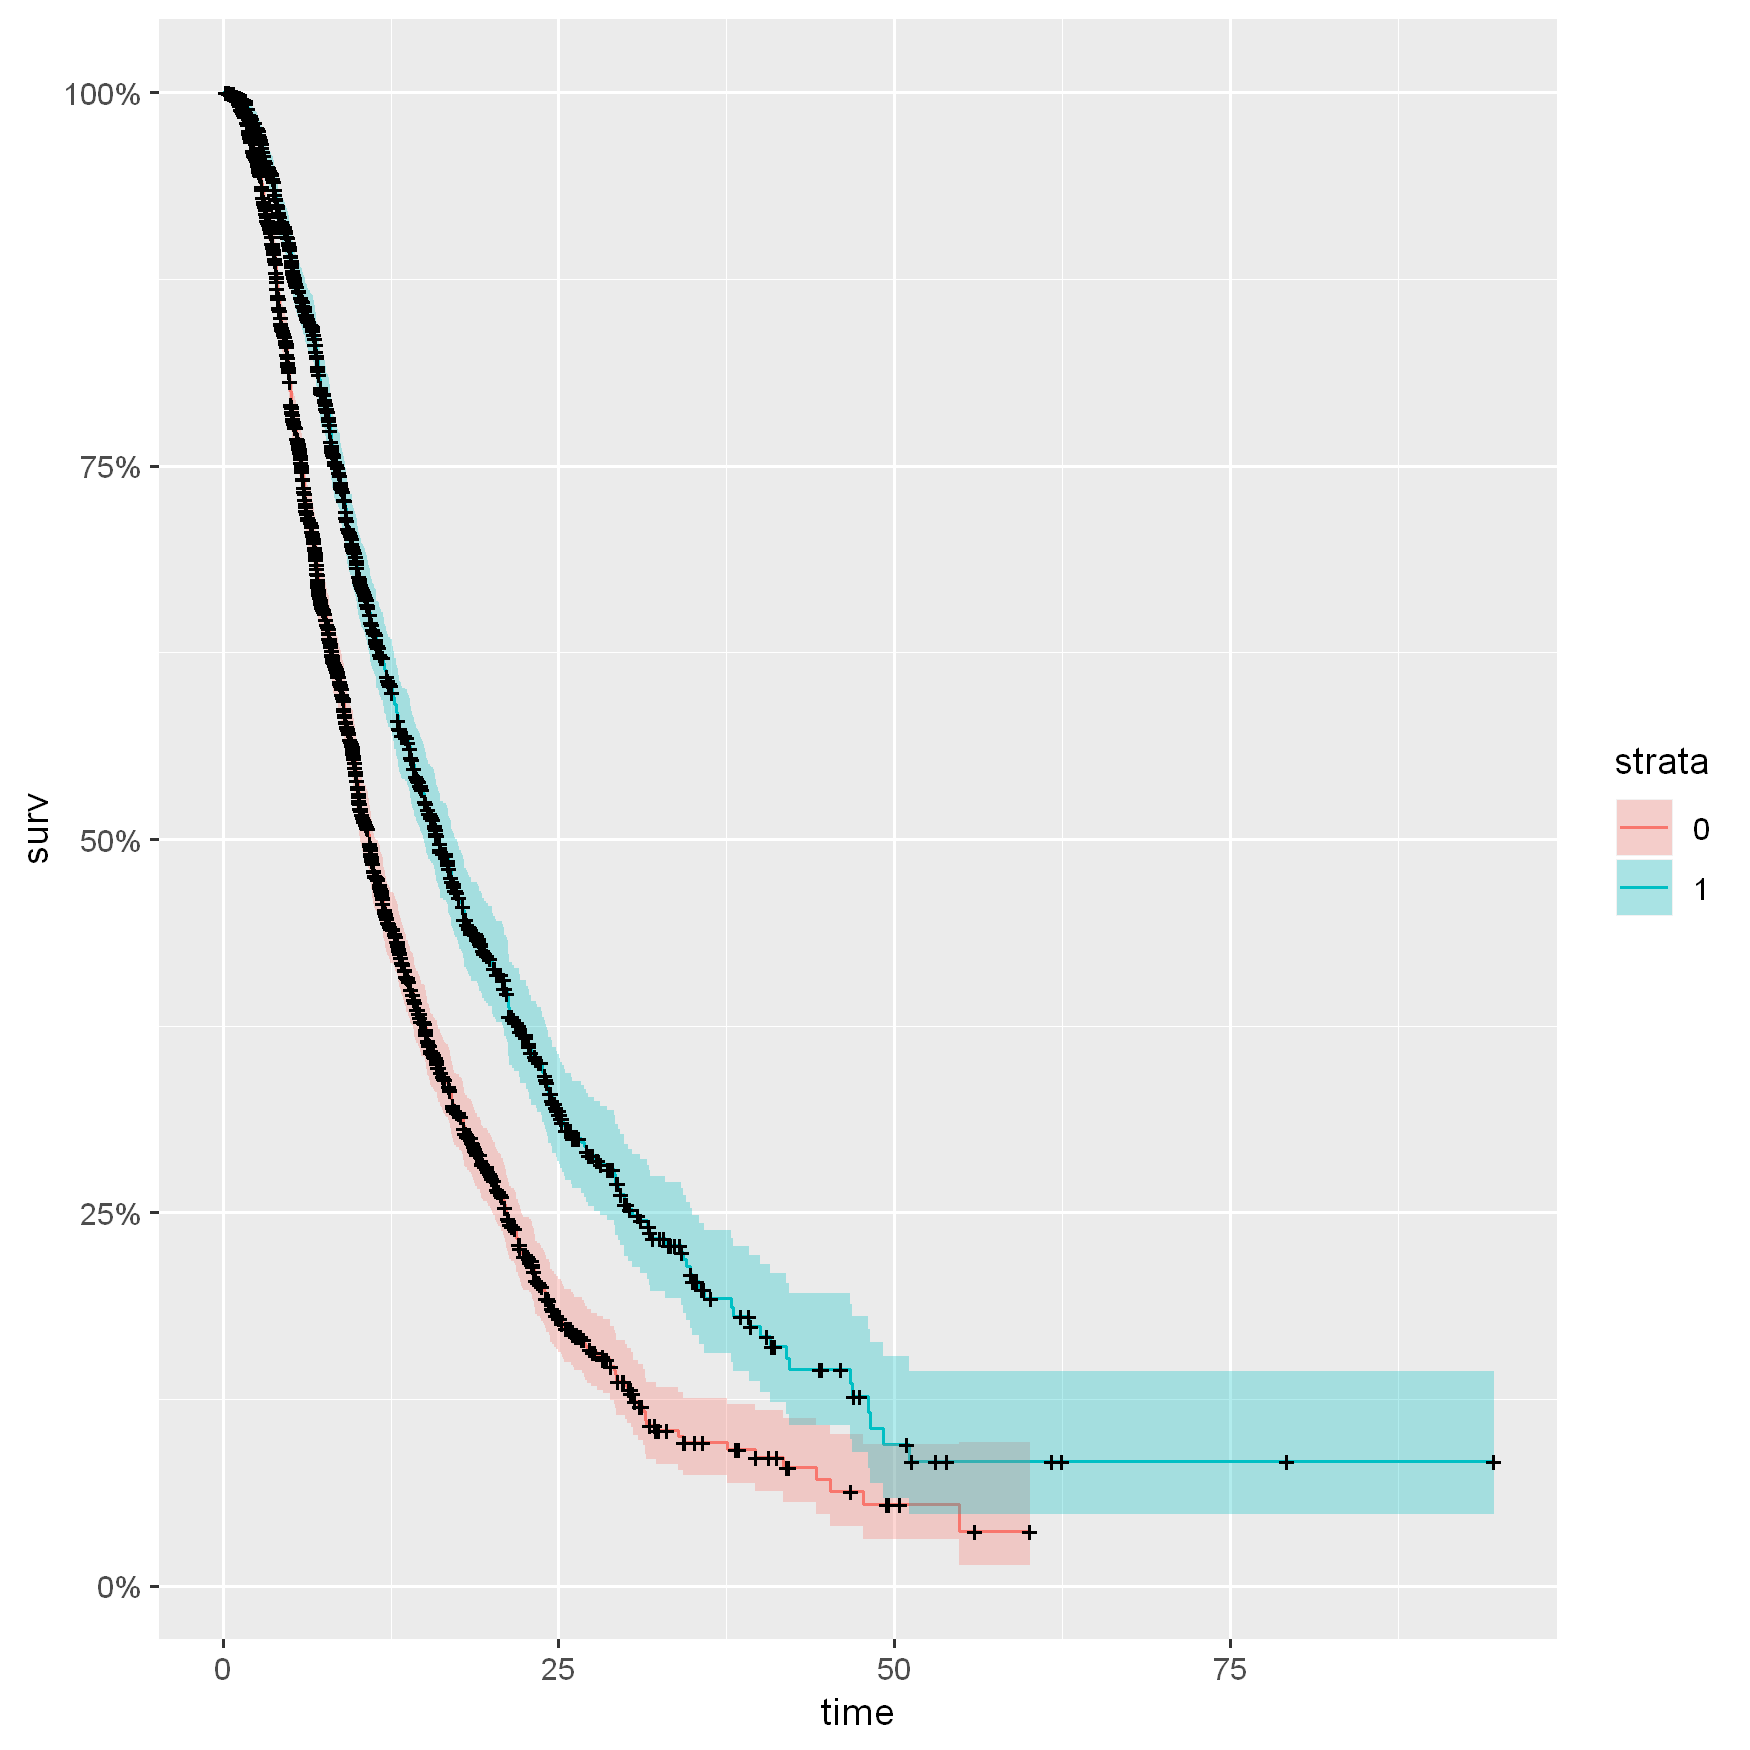

In [209]:
formula <- as.formula("Surv(T.censored, delta) ~ diabetescomp_elx_hospital")
autoplot(survfit(formula, data=df))

In [210]:
survdiff(formula, data = df)

Call:
survdiff(formula = formula, data = df)

                               N Observed Expected (O-E)^2/E (O-E)^2/V
diabetescomp_elx_hospital=0 2103     1297     1093      38.1      87.2
diabetescomp_elx_hospital=1 1313      660      864      48.2      87.2

 Chisq= 87.2  on 1 degrees of freedom, p= <2e-16 

At the $5\%$ level, we reject the null hypothesis that these survival curves are the same in favor of the alternative that they are different.

## Proportional Hazards Model with Adjustent

Finally, we arrive at the primary goal of today's lecture.  Cox's famous proportional hazards model.  

Let's quickly review the proportional hazards model that we established earlier but in the context of adjusting for another variable $x_2$:
$$\log \lambda(t,x_1, x_2) = \beta_0(t) + \beta_1 x_1 + \beta_2 x_2 $$
which implies
\begin{align*}
\lambda(t,x_1, x_2) &= m(x_1, x_2) \cdot \lambda_0(t) \\
\text{where} \qquad m(x_1, x_2) &= \exp \{ \beta_1 x_1 + \beta_2 x_2\}
\end{align*}

In this setting, $\lambda_0(t) = \exp \{ \beta_0(t)\}$ is the "baseline" hazard function.  

Assuming proportional hazards holds, there are straightforward ways to extend the coefficient estimation procedure to account for *non-informative* censoring.  One of the lovely things about regression frameworks is how they allow us to relax assumptions.  In the regression settings, both proportional hazards and non-informative censoring only need to hold *after* accounting for all your predictor variables.  For example, censoring due to an adverse event related to your target event is likely informative *unconditionally*.  However, if we can account (read: adjust) for many of the patient's relevant health factors, we might be able to make the *conditonal* claim that amongst people at a certain level of $x$, censoring and the target event happen independently of one another.  One note of caution - this must hold true for all the different types of events that you're lumping into "censoring".  

Similar logic applies to the proportional hazards claim in that it only needs to hold conditionally.


### Cox's PH Model

These relaxations give us considerably more flexibility.  However, Cox took this one step further.  Cox made the remarkable discovery that we do *not* actually have to specify a model for the baseline hazard function to have a consistent way to estimate the other parameters.  This means that no matter how complicated the shape of the true underlying baseline hazard function, as long as the proportional hazards assumption holds, there is always a way to estimate $\beta_1$ and $\beta_2$ correctly.  This is known as a **semiparametric model**, since we're describing the relationship of the log hazard in terms of the $x$'s through a parameterized linear equation , but we are allowing the relationship in terms of $t$ to be unrestricted, i.e. nonparametric.

There is one large drawback of using this specific type of semiparametric model.  We cannot actually produce individualized survival curves for anybody; since the underlying baseline hazard function remains unknown, the individualized hazard functions are unknown, and thus their survival curves are unknown.

We typically fit Cox's proportional hazards model in order to interpret a hazard ratio, so this is usually not a major concern.  As you may recall in a proportional hazards model, the baseline hazard function cancels out in the hazard ratio.  You interpret the same exact way we described earlier.  $\exp \{\beta_1 \}$ describes the relative change of the baseline hazard "multiplier" when you increase $x_1$ by 1 unit and keep all the other adjusting variables $x_2, x_3, \ldots$ the same.  In an equation, 
$$ \frac{\lambda(t, x_1 + 1, x_2, x_3)}{\lambda(t, x_1, x_2, x_3)} = \frac{m(x_1 + 1, x_2, x_3)}{m(x_1, x_2, x_3)} =  \exp \{\beta_1 \}$$
Plot KM curves and run logrank test for latino predictor.
Now that we've got concepts down, let's fit a model!  We'll continue examining the effect of femalesex, but we'll additionally adjust for some other demographics known at time 0: age, race, latino.

In [97]:
# create and print formula
predictors <- c('femalesex', 'age', 'race', 'latino')
formula <- paste(predictors, collapse = " + ")
formula <- paste("Surv(T.censored, delta)", formula, sep = " ~ ")
formula <- as.formula(formula)
print(formula)

model <- coxph(formula, data = df)
summary(model)

Surv(T.censored, delta) ~ femalesex + age + race + latino


Call:
coxph(formula = formula, data = df)

  n= 3416, number of events= 1957 

               coef exp(coef)  se(coef)      z Pr(>|z|)    
femalesex  0.194464  1.214660  0.045728  4.253 2.11e-05 ***
age       -0.001120  0.998881  0.001585 -0.707    0.480    
raceBlack  0.052007  1.053383  0.177535  0.293    0.770    
raceOther -0.061512  0.940342  0.192184 -0.320    0.749    
raceWhite  0.013566  1.013659  0.174777  0.078    0.938    
latino     0.029628  1.030072  0.083802  0.354    0.724    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

          exp(coef) exp(-coef) lower .95 upper .95
femalesex    1.2147     0.8233    1.1105     1.329
age          0.9989     1.0011    0.9958     1.002
raceBlack    1.0534     0.9493    0.7438     1.492
raceOther    0.9403     1.0634    0.6452     1.370
raceWhite    1.0137     0.9865    0.7196     1.428
latino       1.0301     0.9708    0.8740     1.214

Concordance= 0.532  (se = 0.007 )
Likelihood ratio test= 20.42  on 6 df,   

From this, we can interpret that those who are female just about $20\%$ higher hazard for being discharged than males, after adjusting for the other demographic variables.

The final section contains three hypothesis tests.  As you can see, there is a logrank test down below under the null hypothesis that there are no differences in the survival curves between all the different subpopulations.  If you want to do a logrank test with 3+ groups, you can just run a Cox PH model with a single group predictor and check this number. 

### Checking Proportional Hazards

Next, we'll use a tool to check if the proportional hazards assumption is correct.  We can use the **cox.zph** function to perform this analysis for us.  It will give for each predictor whether it believes proportional hazards is satisfied with respect to that predictor.  Since p-values are dependent on the data size, I think a better way to check the assumption is to plot the results and make a visual assessment.  

Passing the results of the analysis to the plot function gives us a plot showing the **scaled Schoenfeld Residuals** for each predictor (shifted vertically by the estimated coefficient).  You don't need to understand what this means - just how to interpret it.  A smoothed lines with confidence intervals around it will appear near the center of the plot.  This line represents an estimate of how the $\beta$ coefficient of that predictor should be changing as a function of time.

If you recall, the PH assumption ensures that the $\beta$ coefficients should *not depend* on time.  Thus, we can check if PH is reasonable by seeing if these lines are relatively constant or not.

            chisq df       p
femalesex  0.0282  1    0.87
age       37.2786  1 1.0e-09
race       4.4303  3    0.22
latino     1.1343  1    0.29
GLOBAL    38.5975  6 8.6e-07

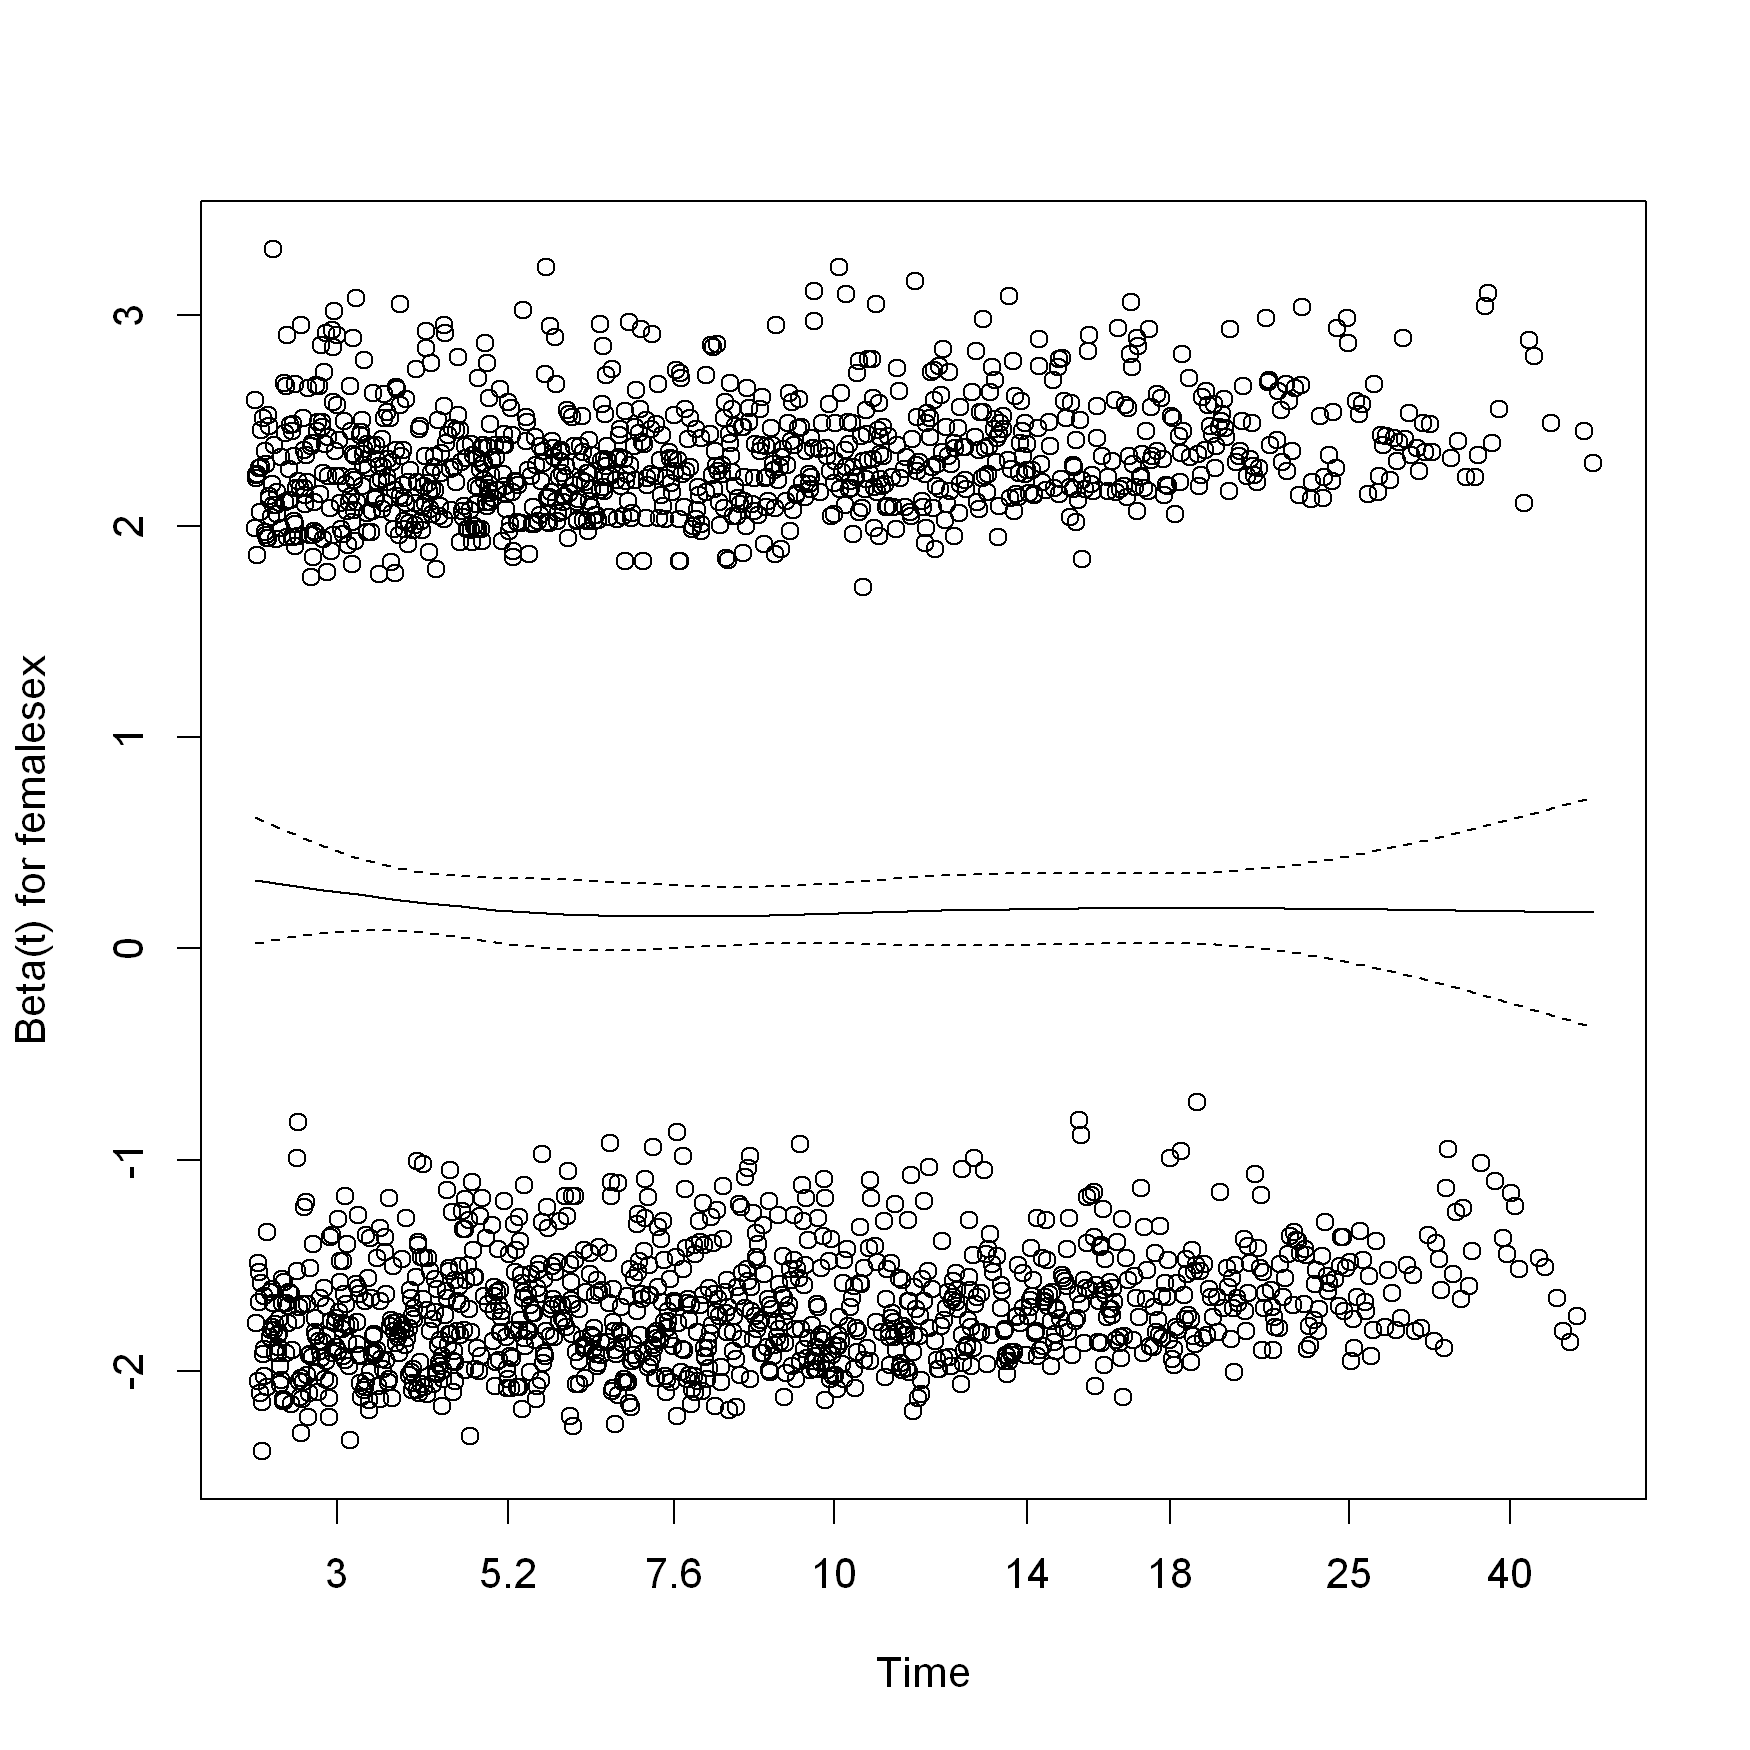

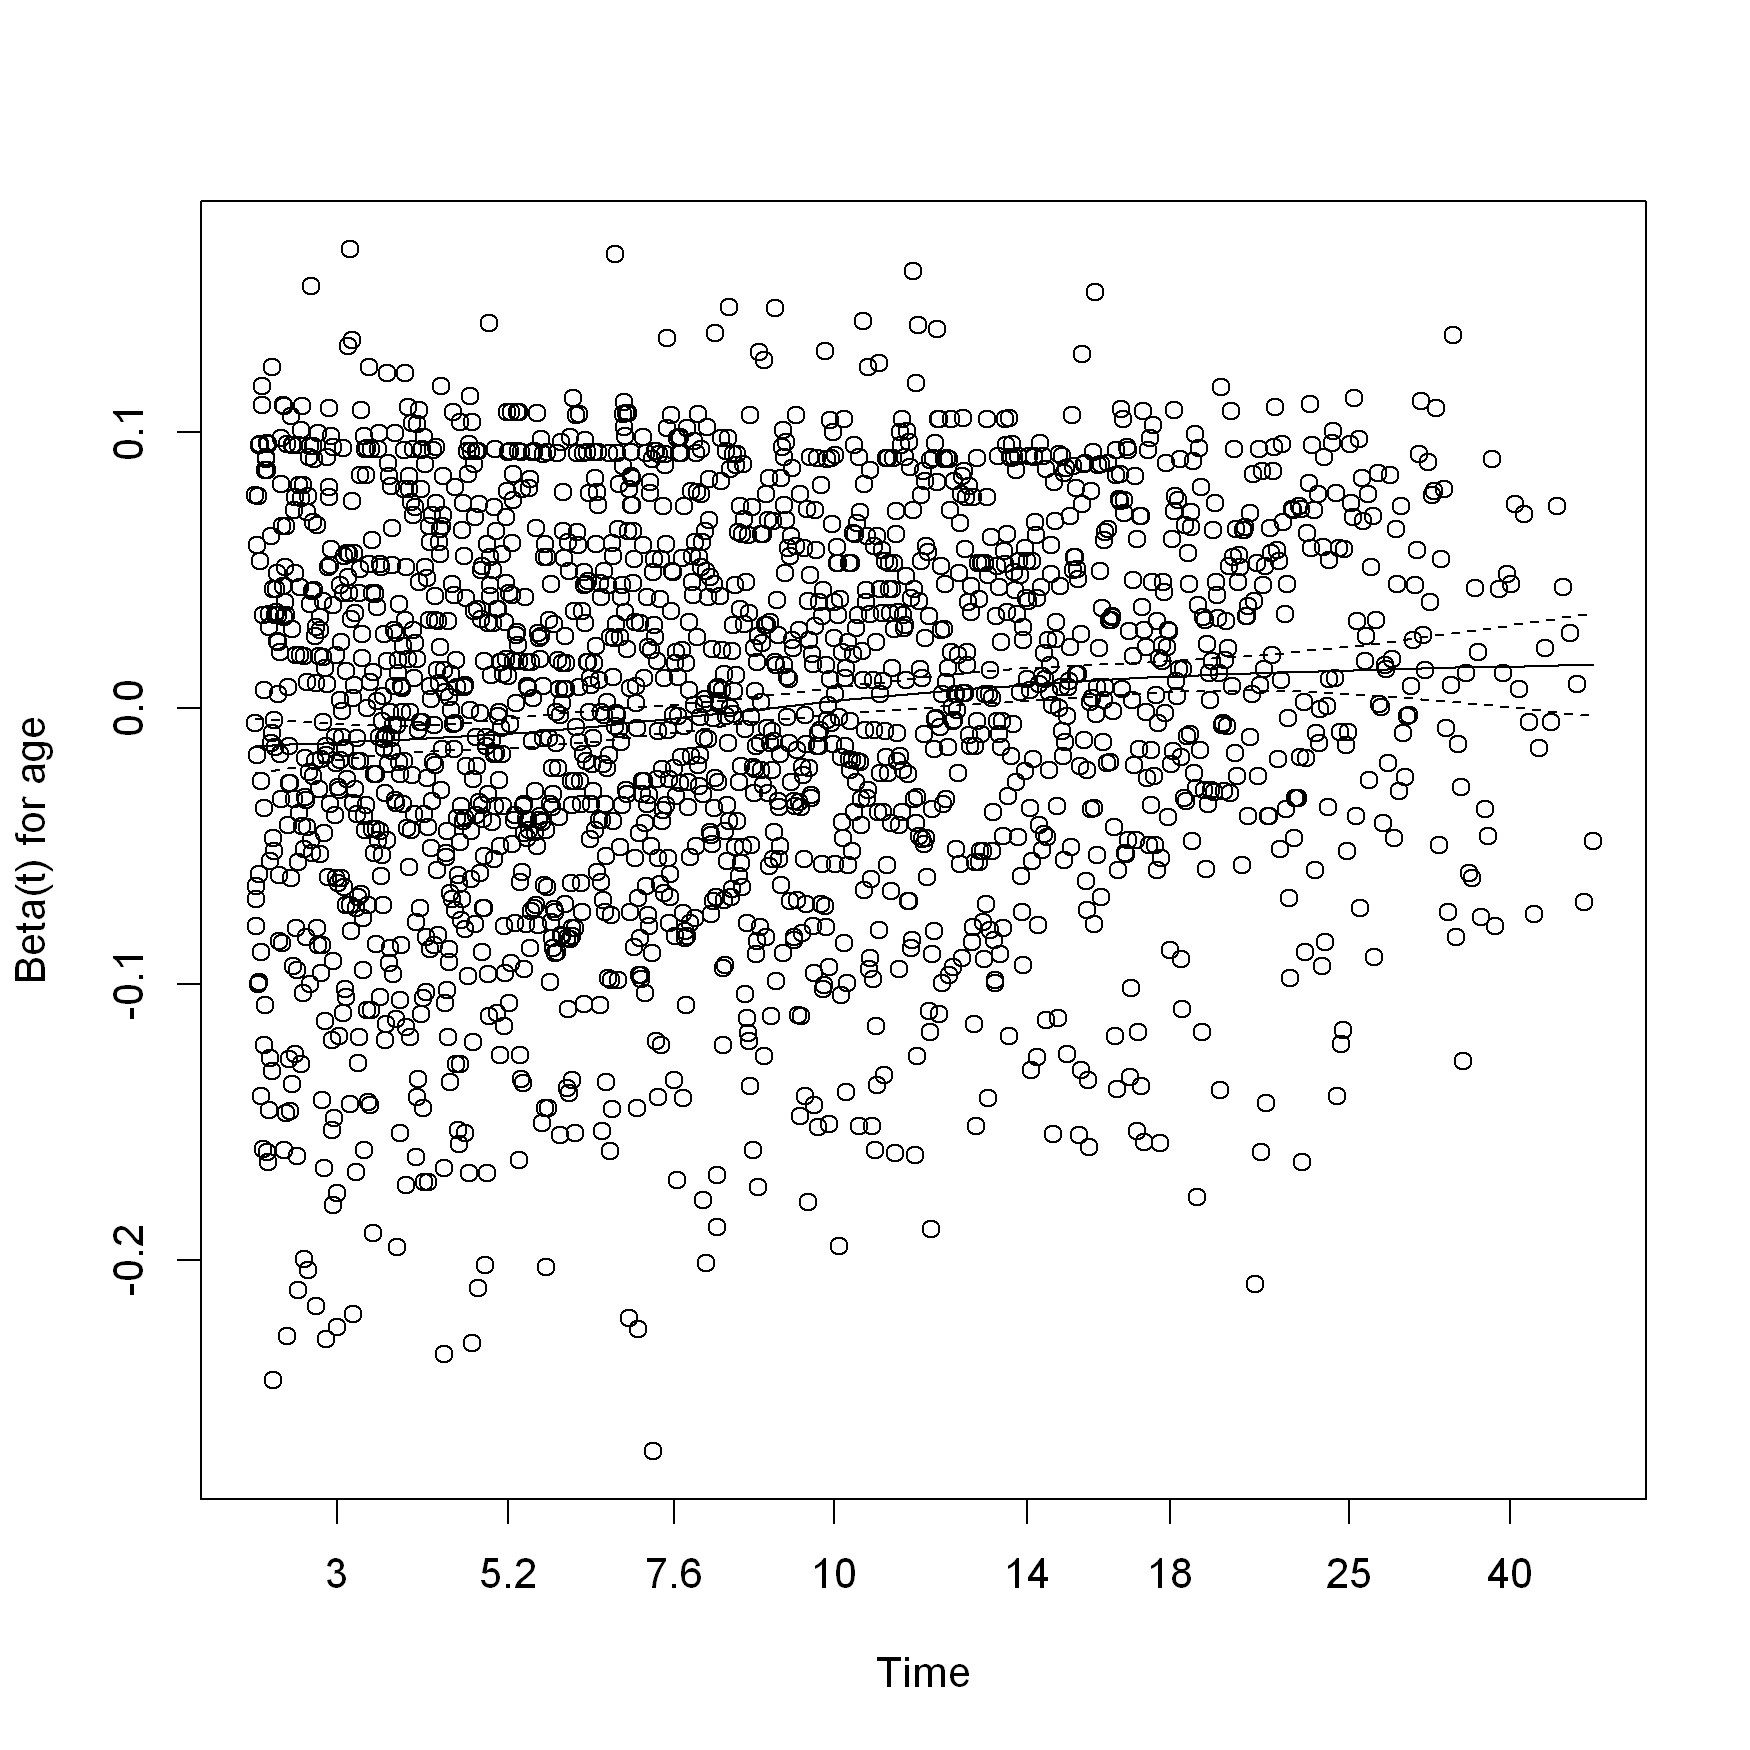

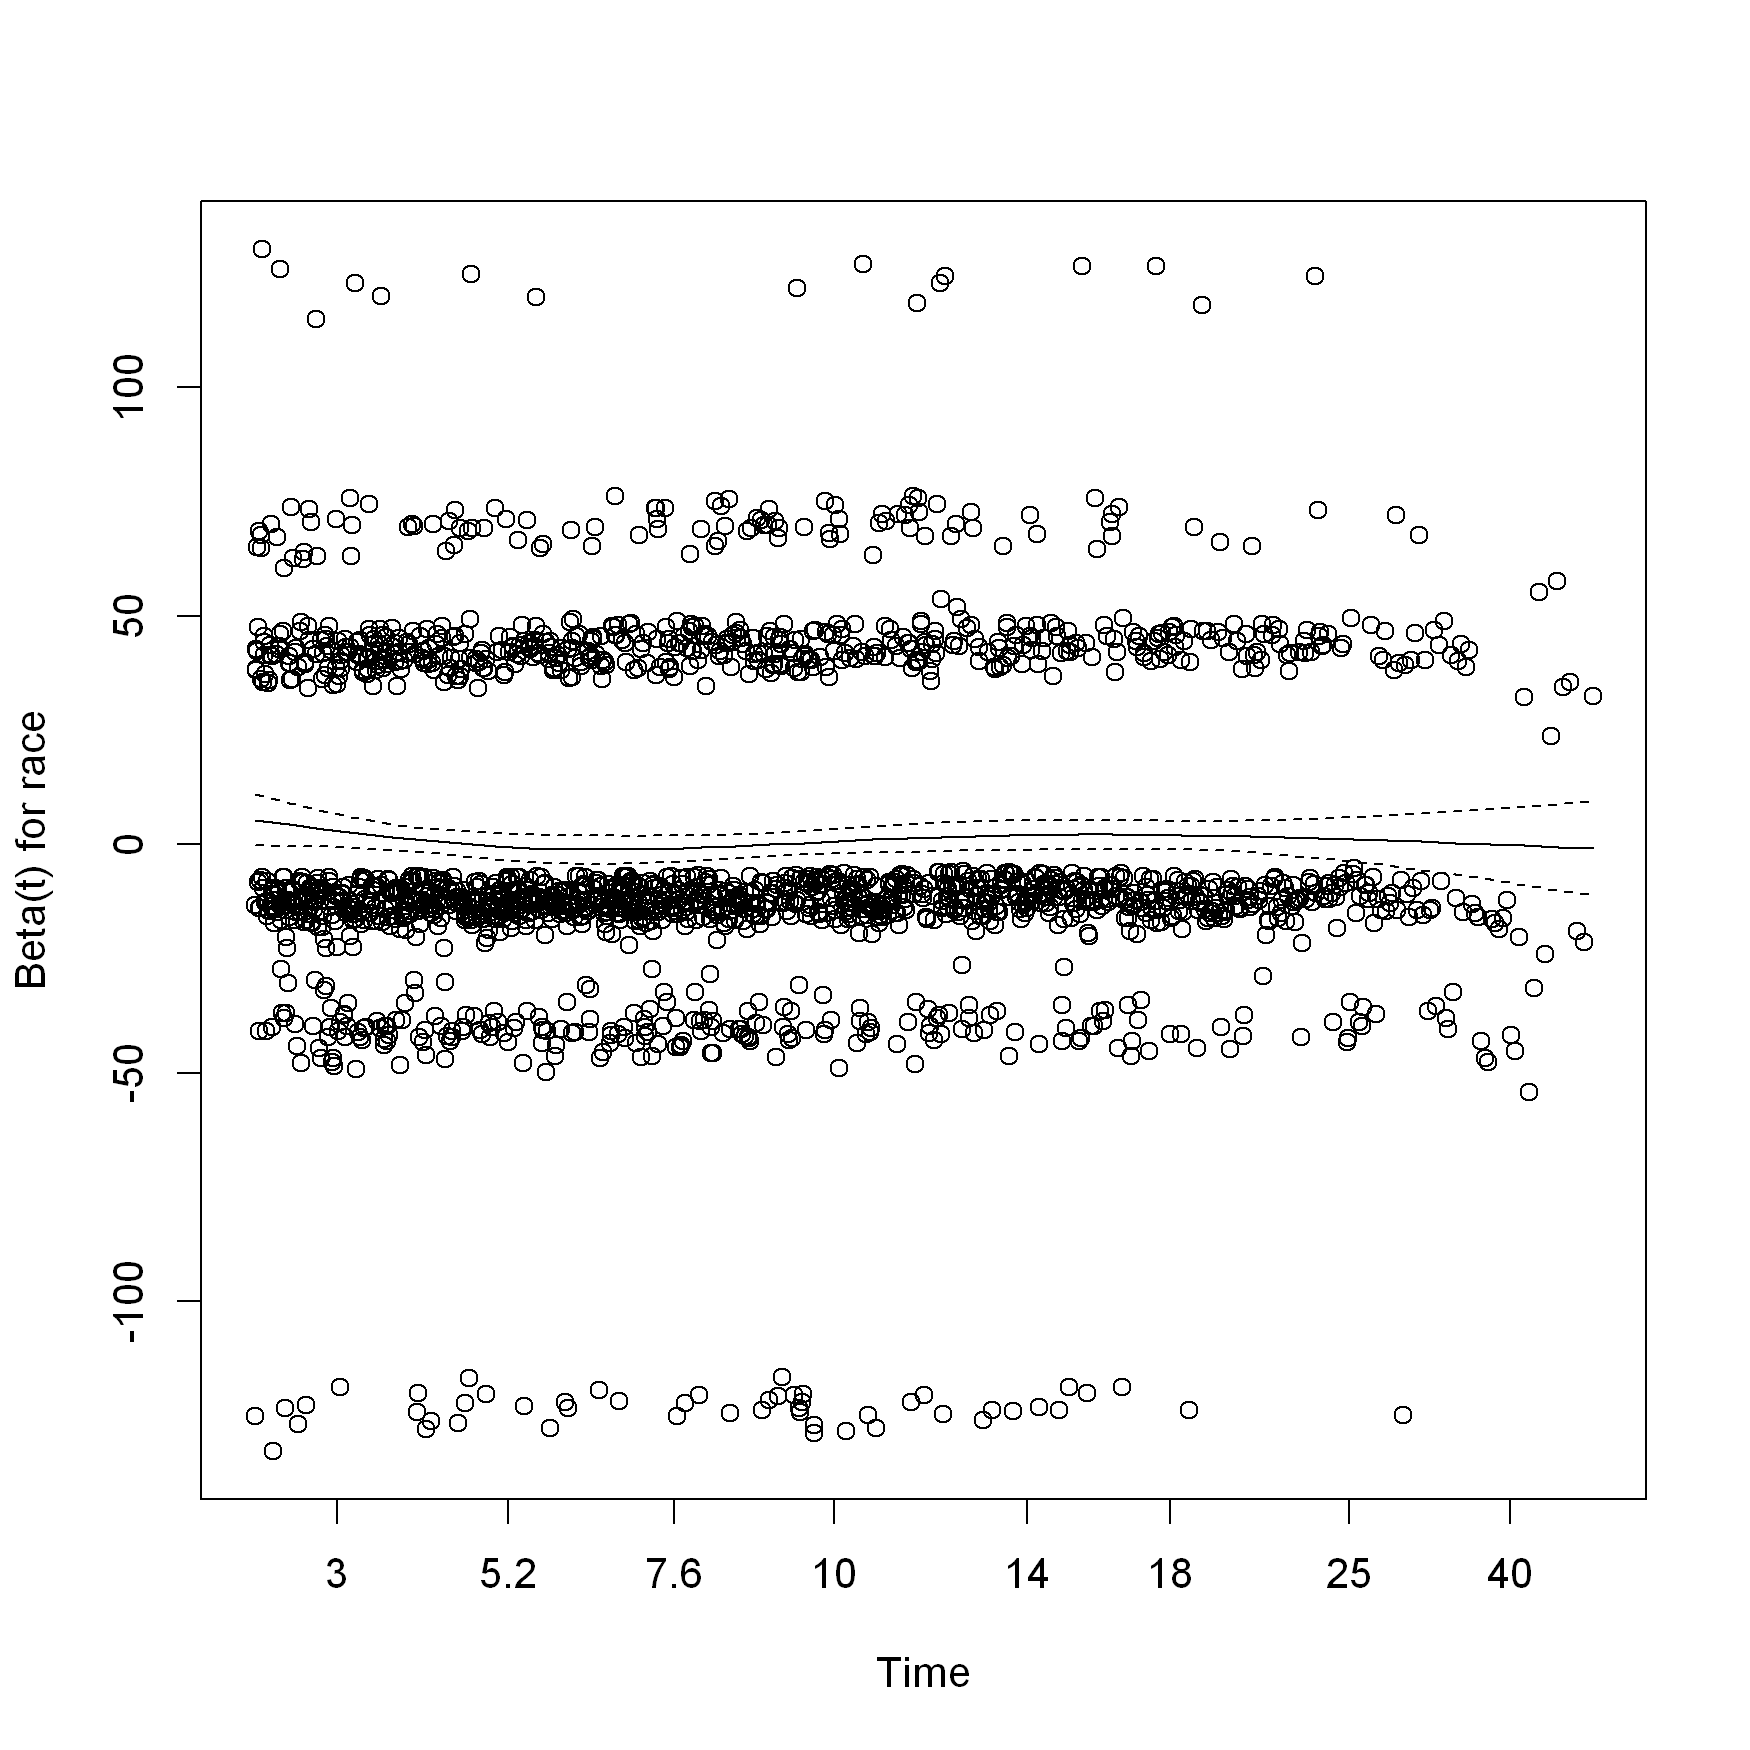

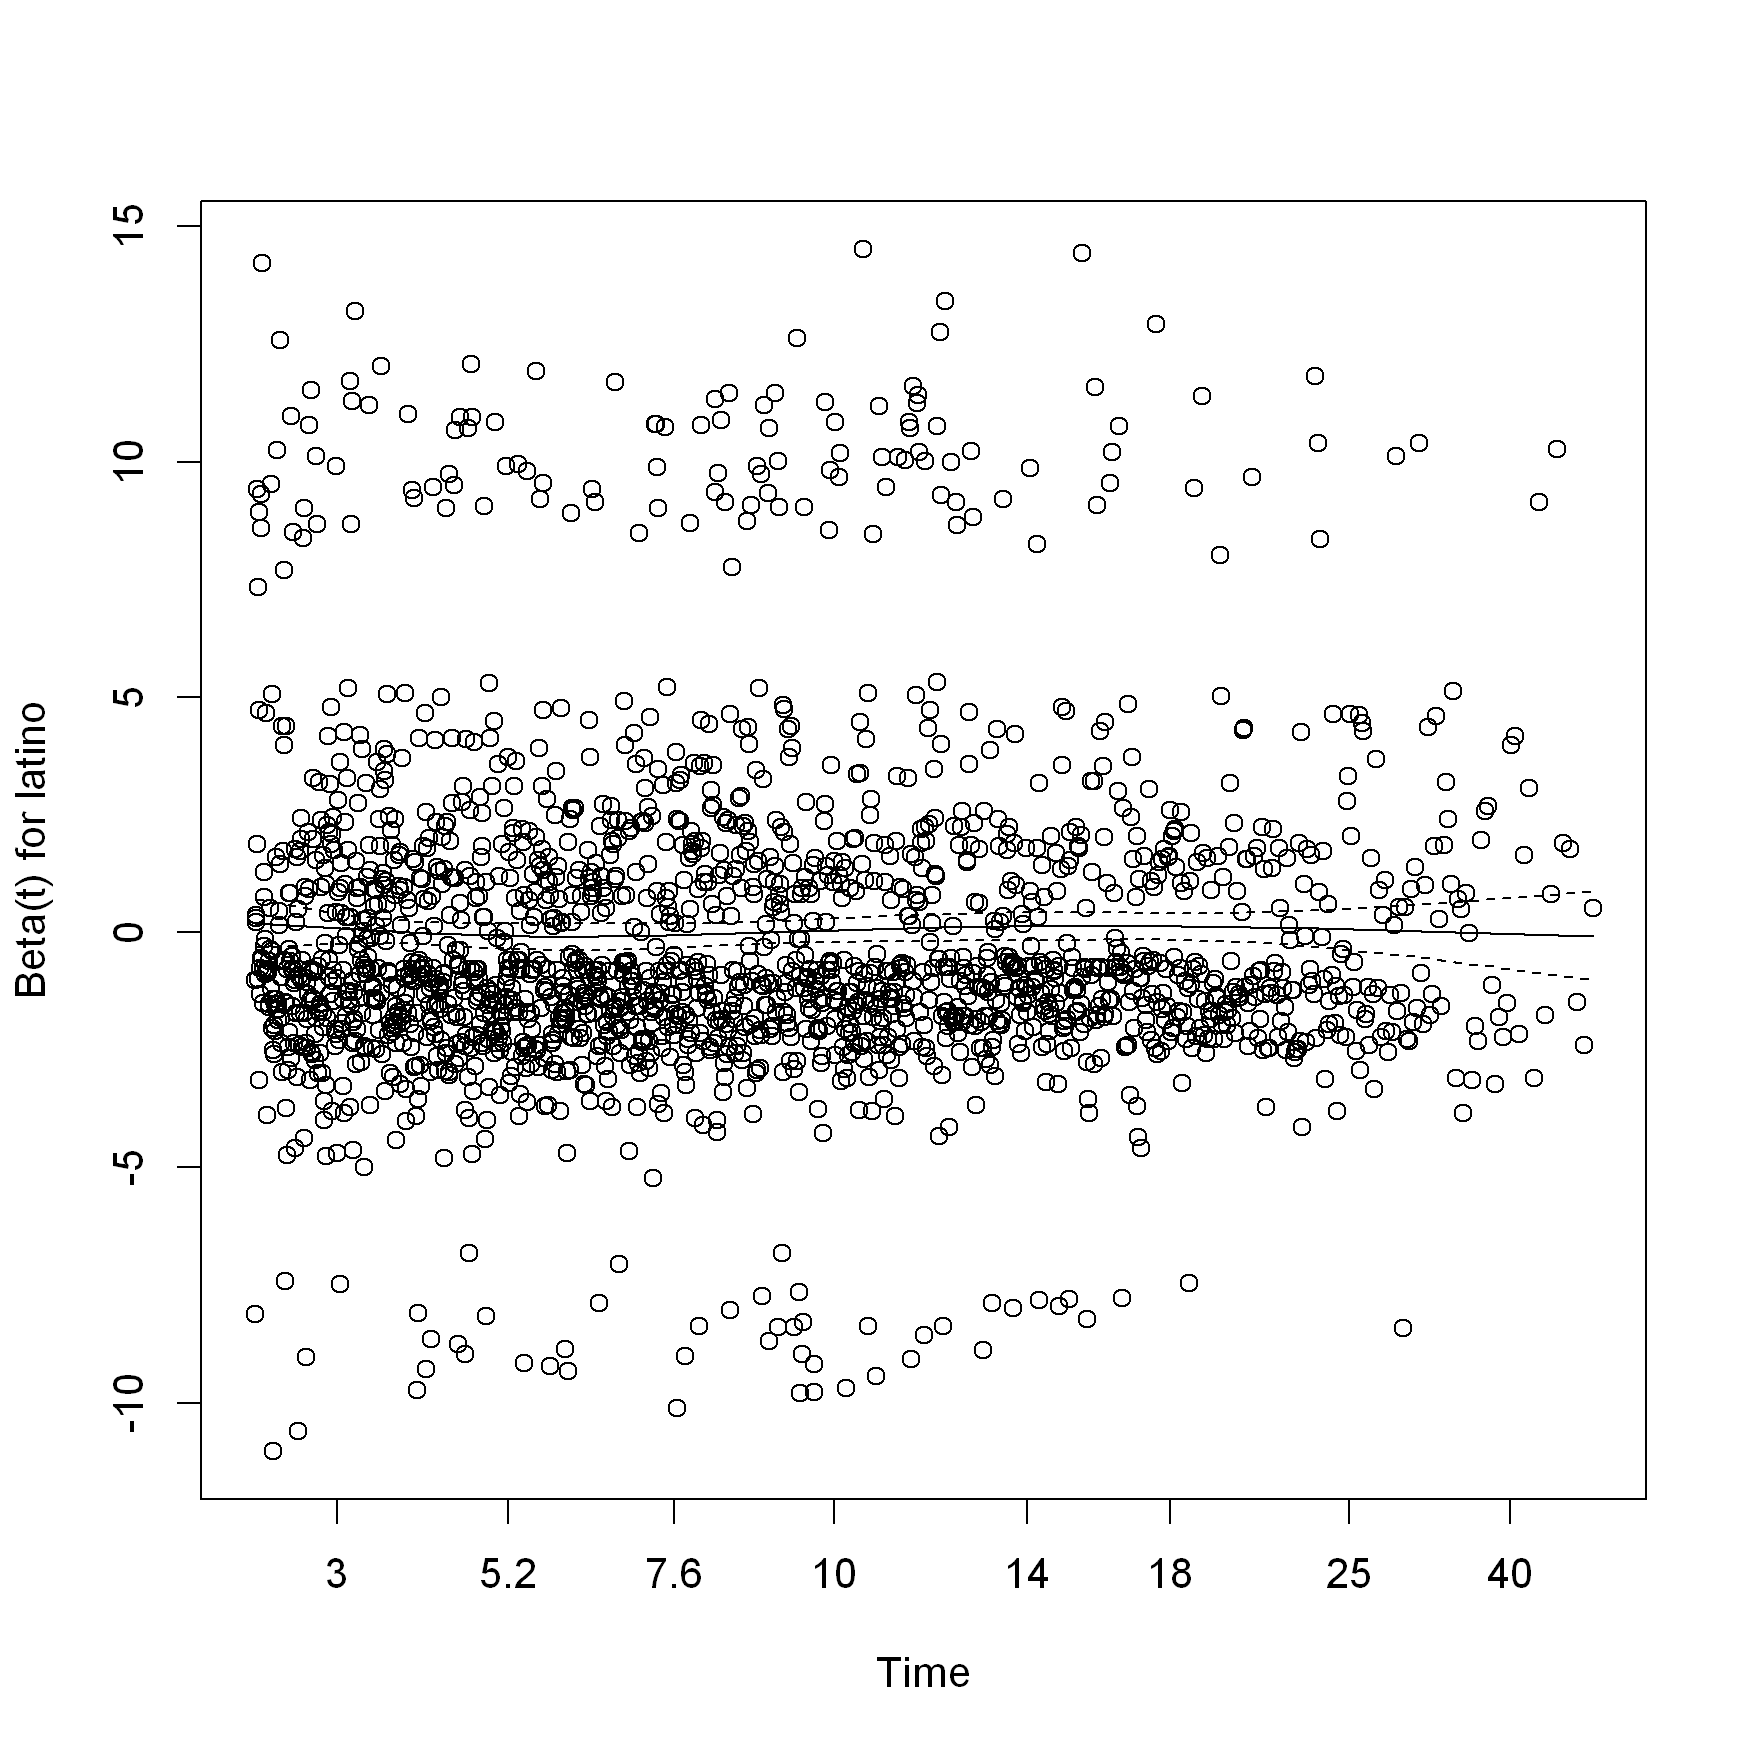

In [98]:
ph.analysis <- cox.zph(model)
ph.analysis
plot(ph.analysis)

From these plots, we can say that the coefficient for age might have a slight time-dependence.  However, it's pretty minor, and the PH model would still be a good choice here.  

### In-Class Exercise 4: Diabetes Revisited with Adjustment

1. Run a Cox PH regression model to learn about the association between T.censored (which is simply a censored length of stay) and diabetescomp_elx_hospital.  Adjust for age, femalesex, and log(wbcc_max).

2. In a comment, state an interpretation for the diabetes coefficient.

3. Perform a check for the validity of the proportional hazards assumption using the plotting technique we discussed.

In [211]:
predictors <- c("diabetescomp_elx_hospital", "age", "femalesex", "log(wbcc_max)")
formula <- paste(predictors, collapse = " + ")
formula <- paste("Surv(T.censored, delta)", formula, sep = " ~ ")
formula <- as.formula(formula)

model <- coxph(formula, data = df)
summary(model)

Call:
coxph(formula = formula, data = df)

  n= 3416, number of events= 1957 

                               coef exp(coef)  se(coef)       z Pr(>|z|)    
diabetescomp_elx_hospital -0.402774  0.668463  0.048363  -8.328   <2e-16 ***
age                       -0.003037  0.996968  0.001474  -2.061   0.0393 *  
femalesex                  0.097045  1.101910  0.045791   2.119   0.0341 *  
log(wbcc_max)             -1.037684  0.354274  0.039615 -26.194   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                          exp(coef) exp(-coef) lower .95 upper .95
diabetescomp_elx_hospital    0.6685     1.4960    0.6080    0.7349
age                          0.9970     1.0030    0.9941    0.9999
femalesex                    1.1019     0.9075    1.0073    1.2054
log(wbcc_max)                0.3543     2.8227    0.3278    0.3829

Concordance= 0.703  (se = 0.006 )
Likelihood ratio test= 796.2  on 4 df,   p=<2e-16
Wald test            = 797.4  on 4 df,   p=<2e-1

In [214]:
round(exp(model$coefficients['diabetescomp_elx_hospital']), 3)

diabetescomp_elx_hospital 
                    0.668

Those with with a diagnosis of diabetes with complications have $67\%$ the hazard for discharge of those without such a diagnosis.

                          chisq df       p
diabetescomp_elx_hospital  2.53  1    0.11
age                       17.96  1 2.3e-05
femalesex                  1.13  1    0.29
log(wbcc_max)             18.25  1 1.9e-05
GLOBAL                    44.31  4 5.5e-09

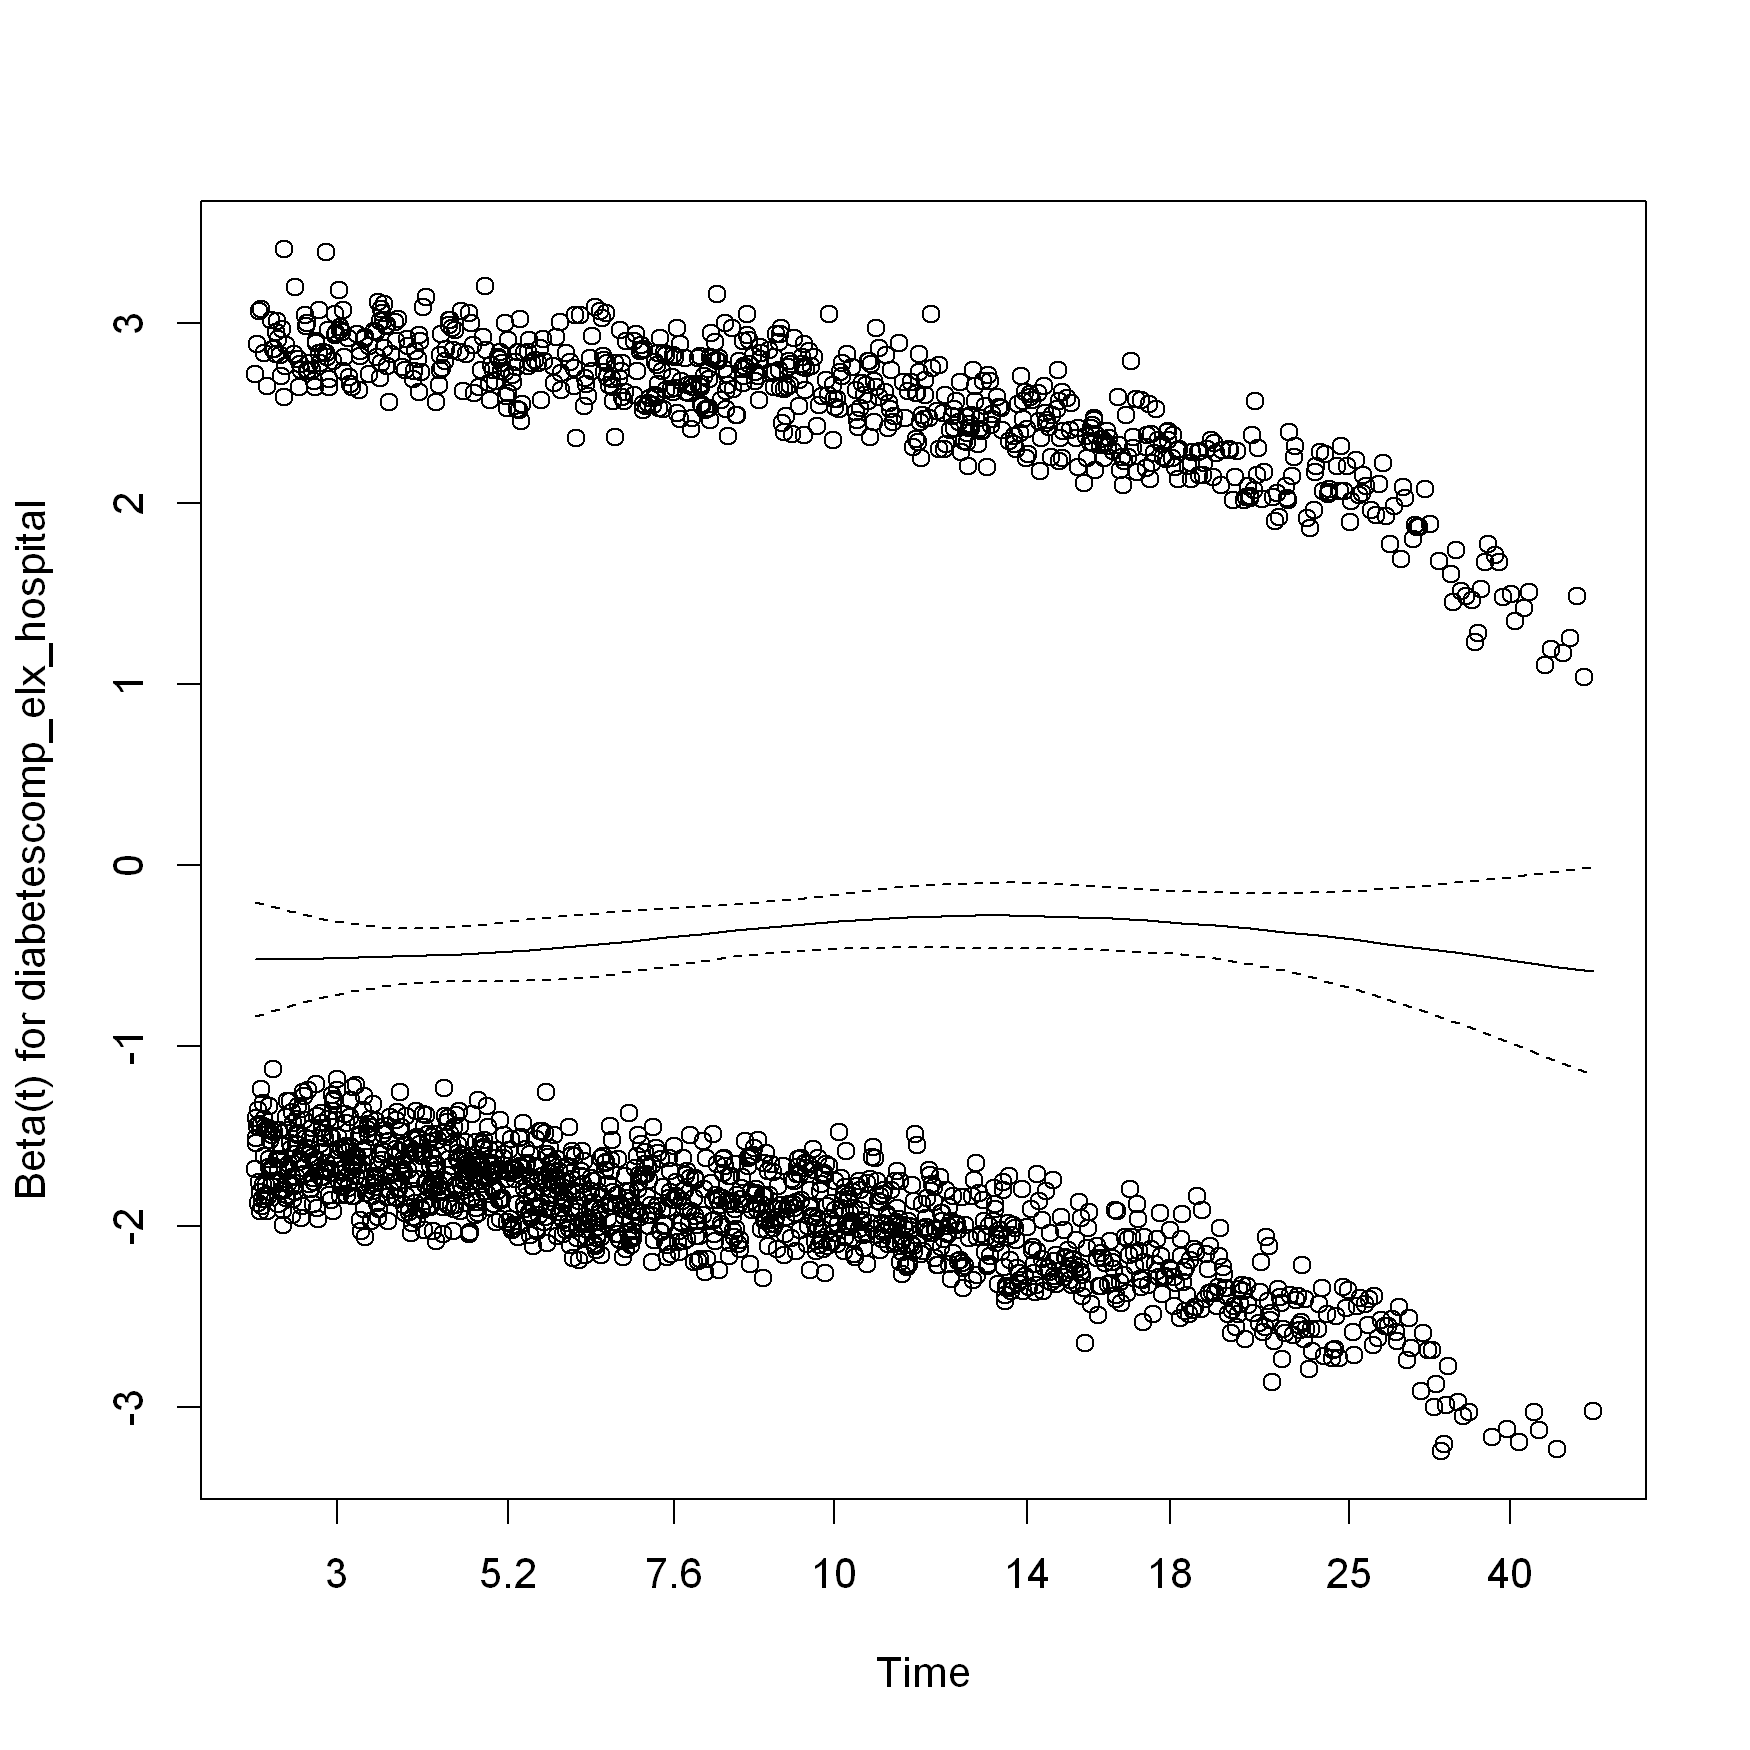

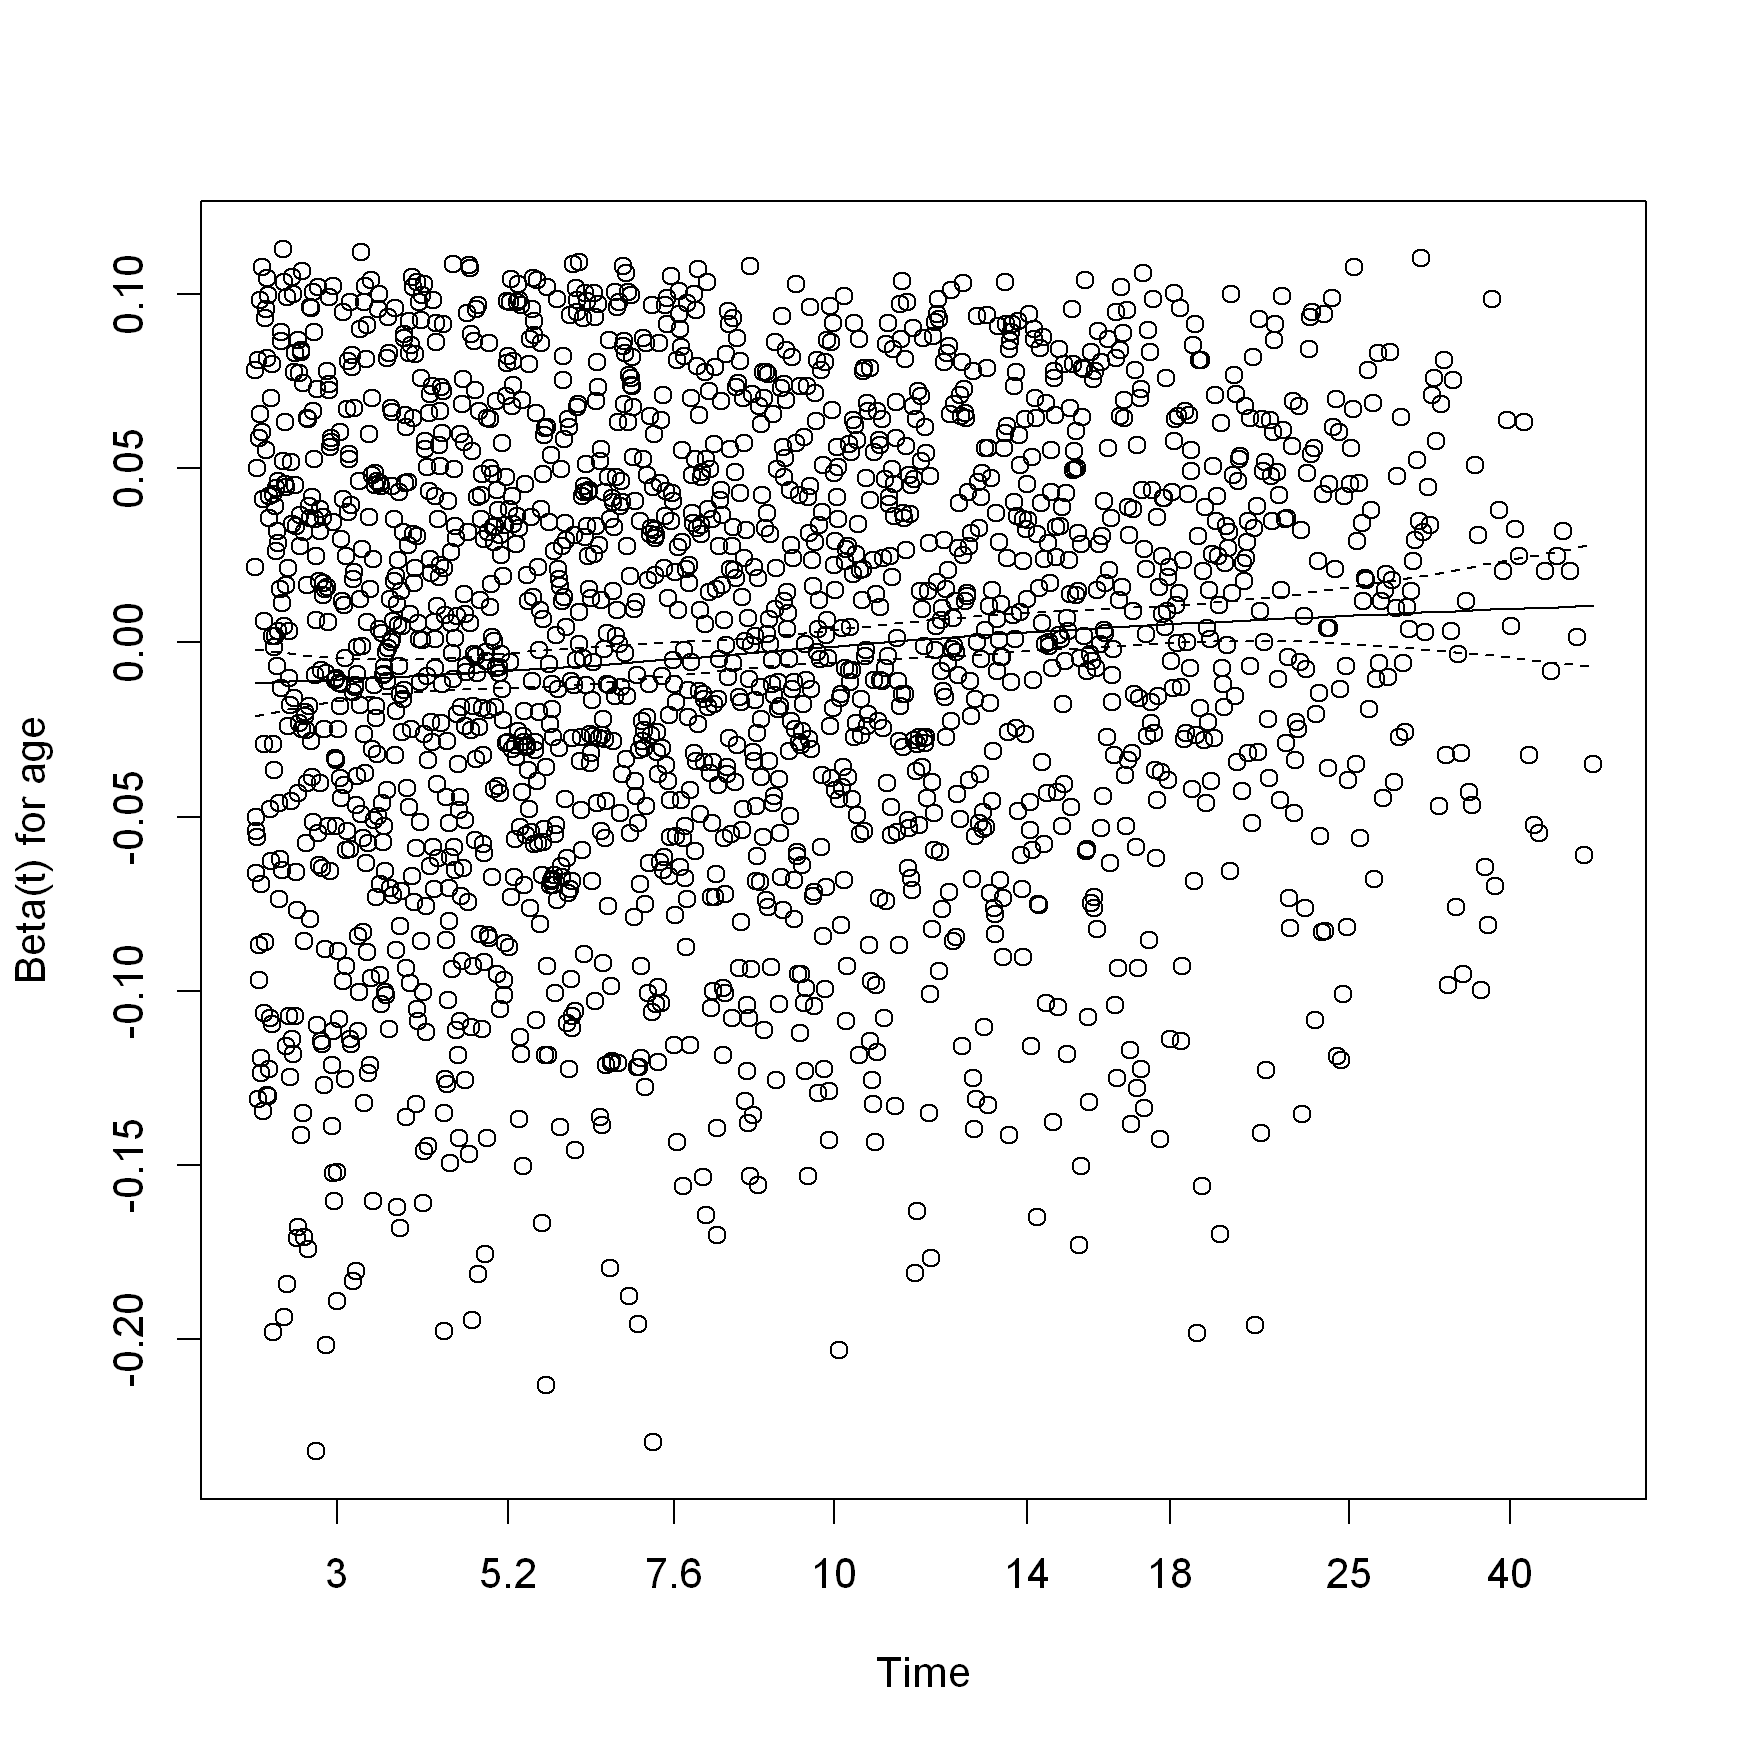

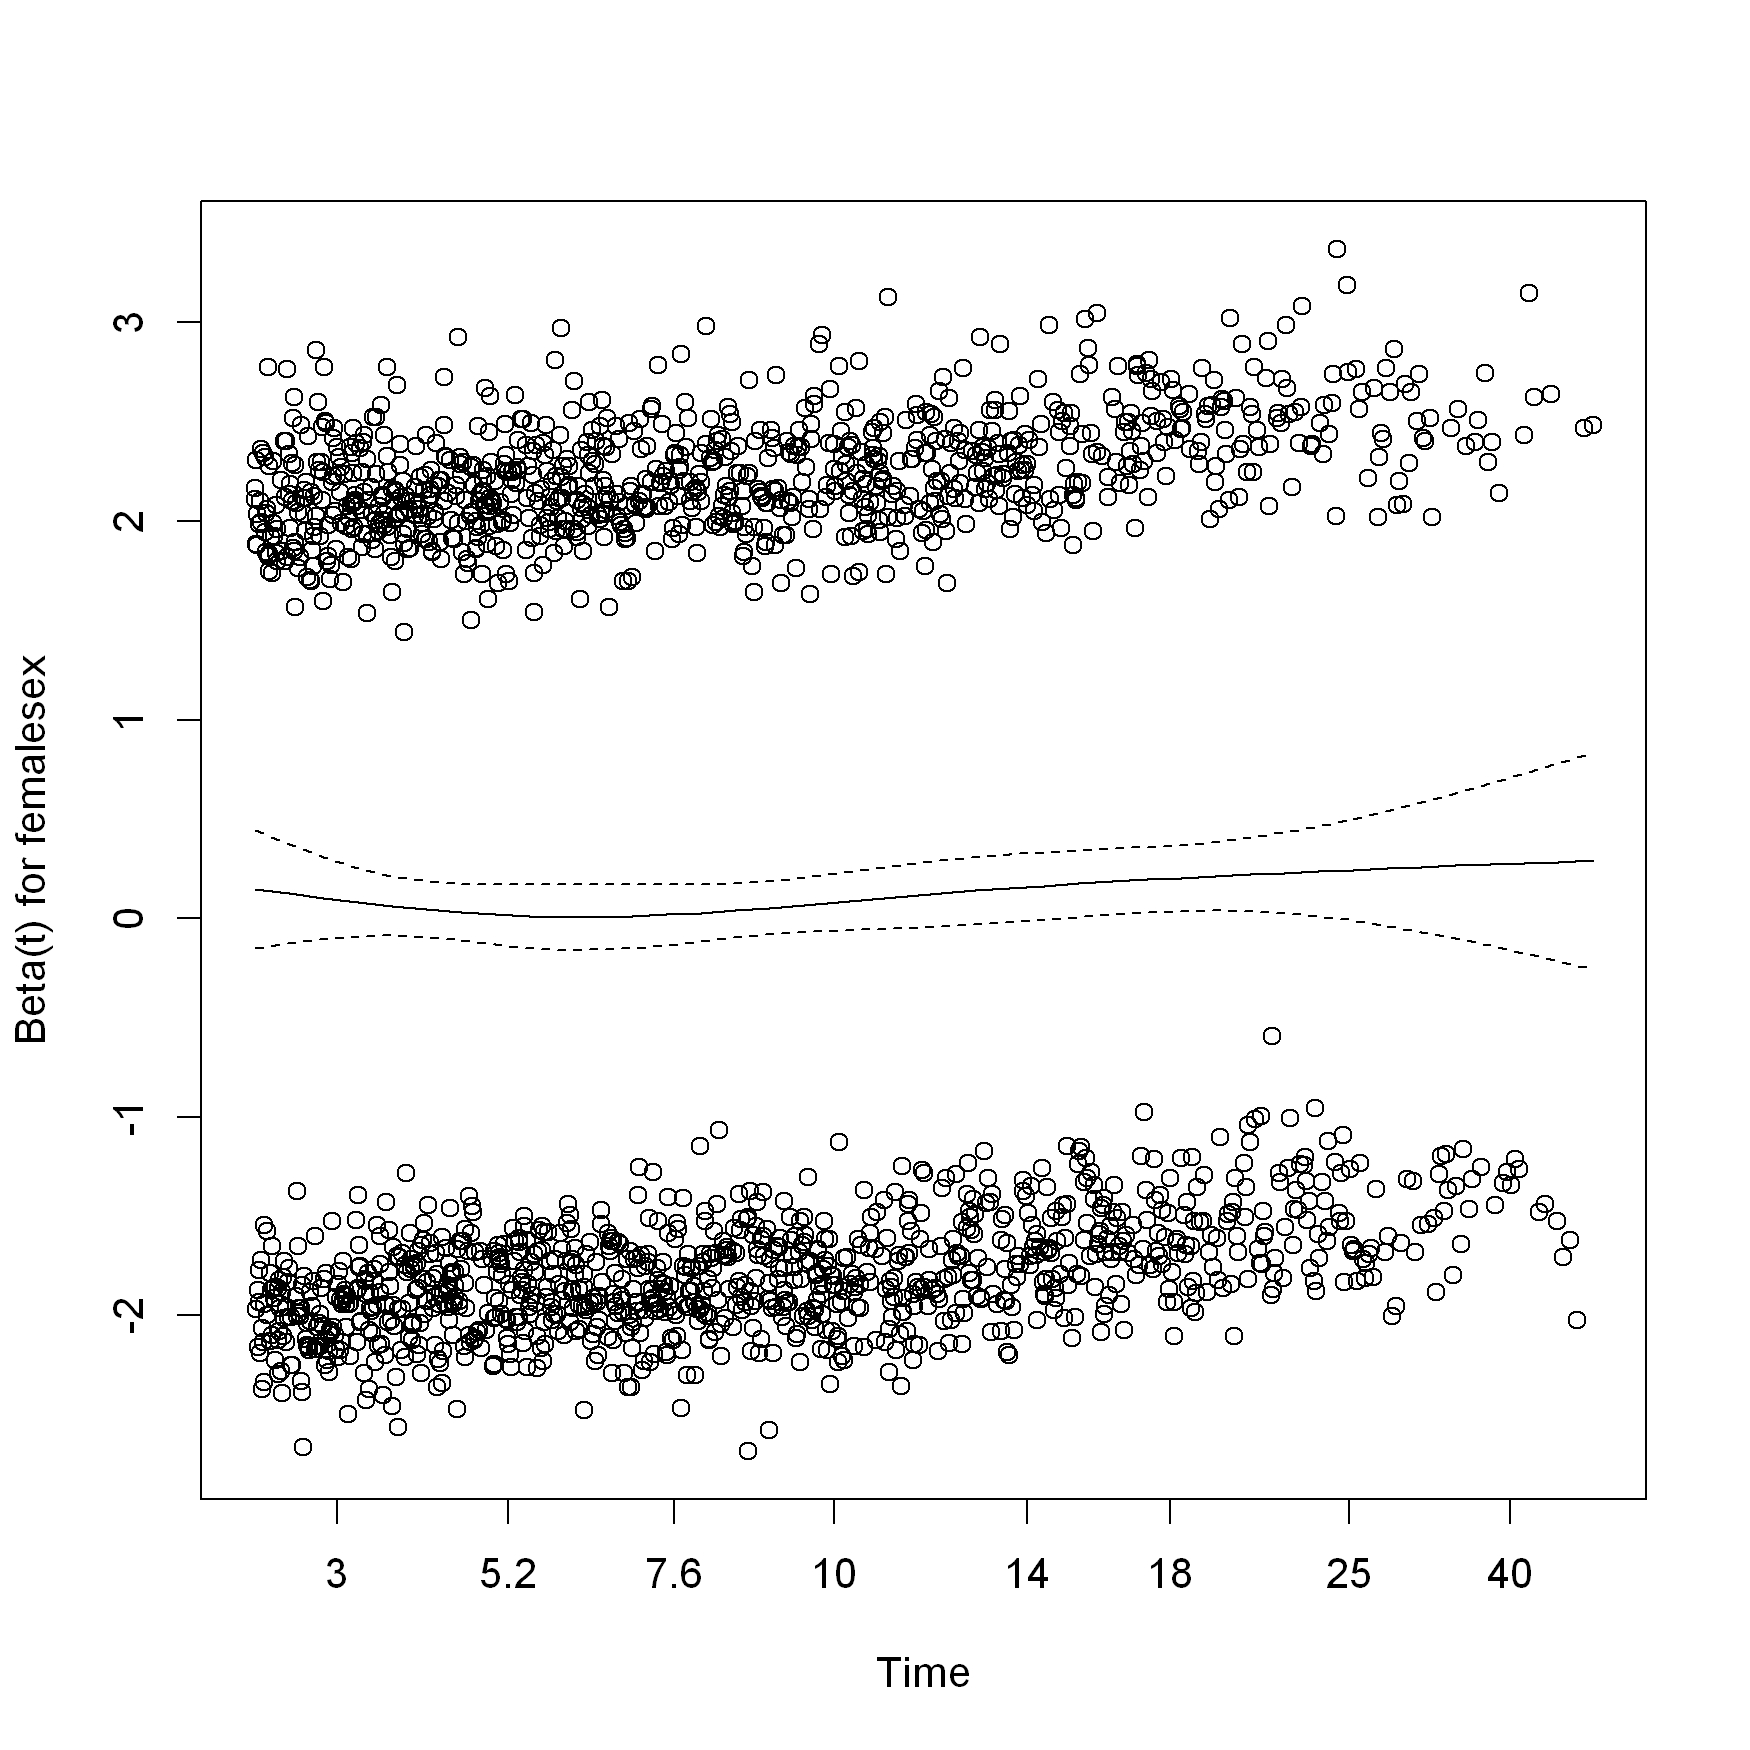

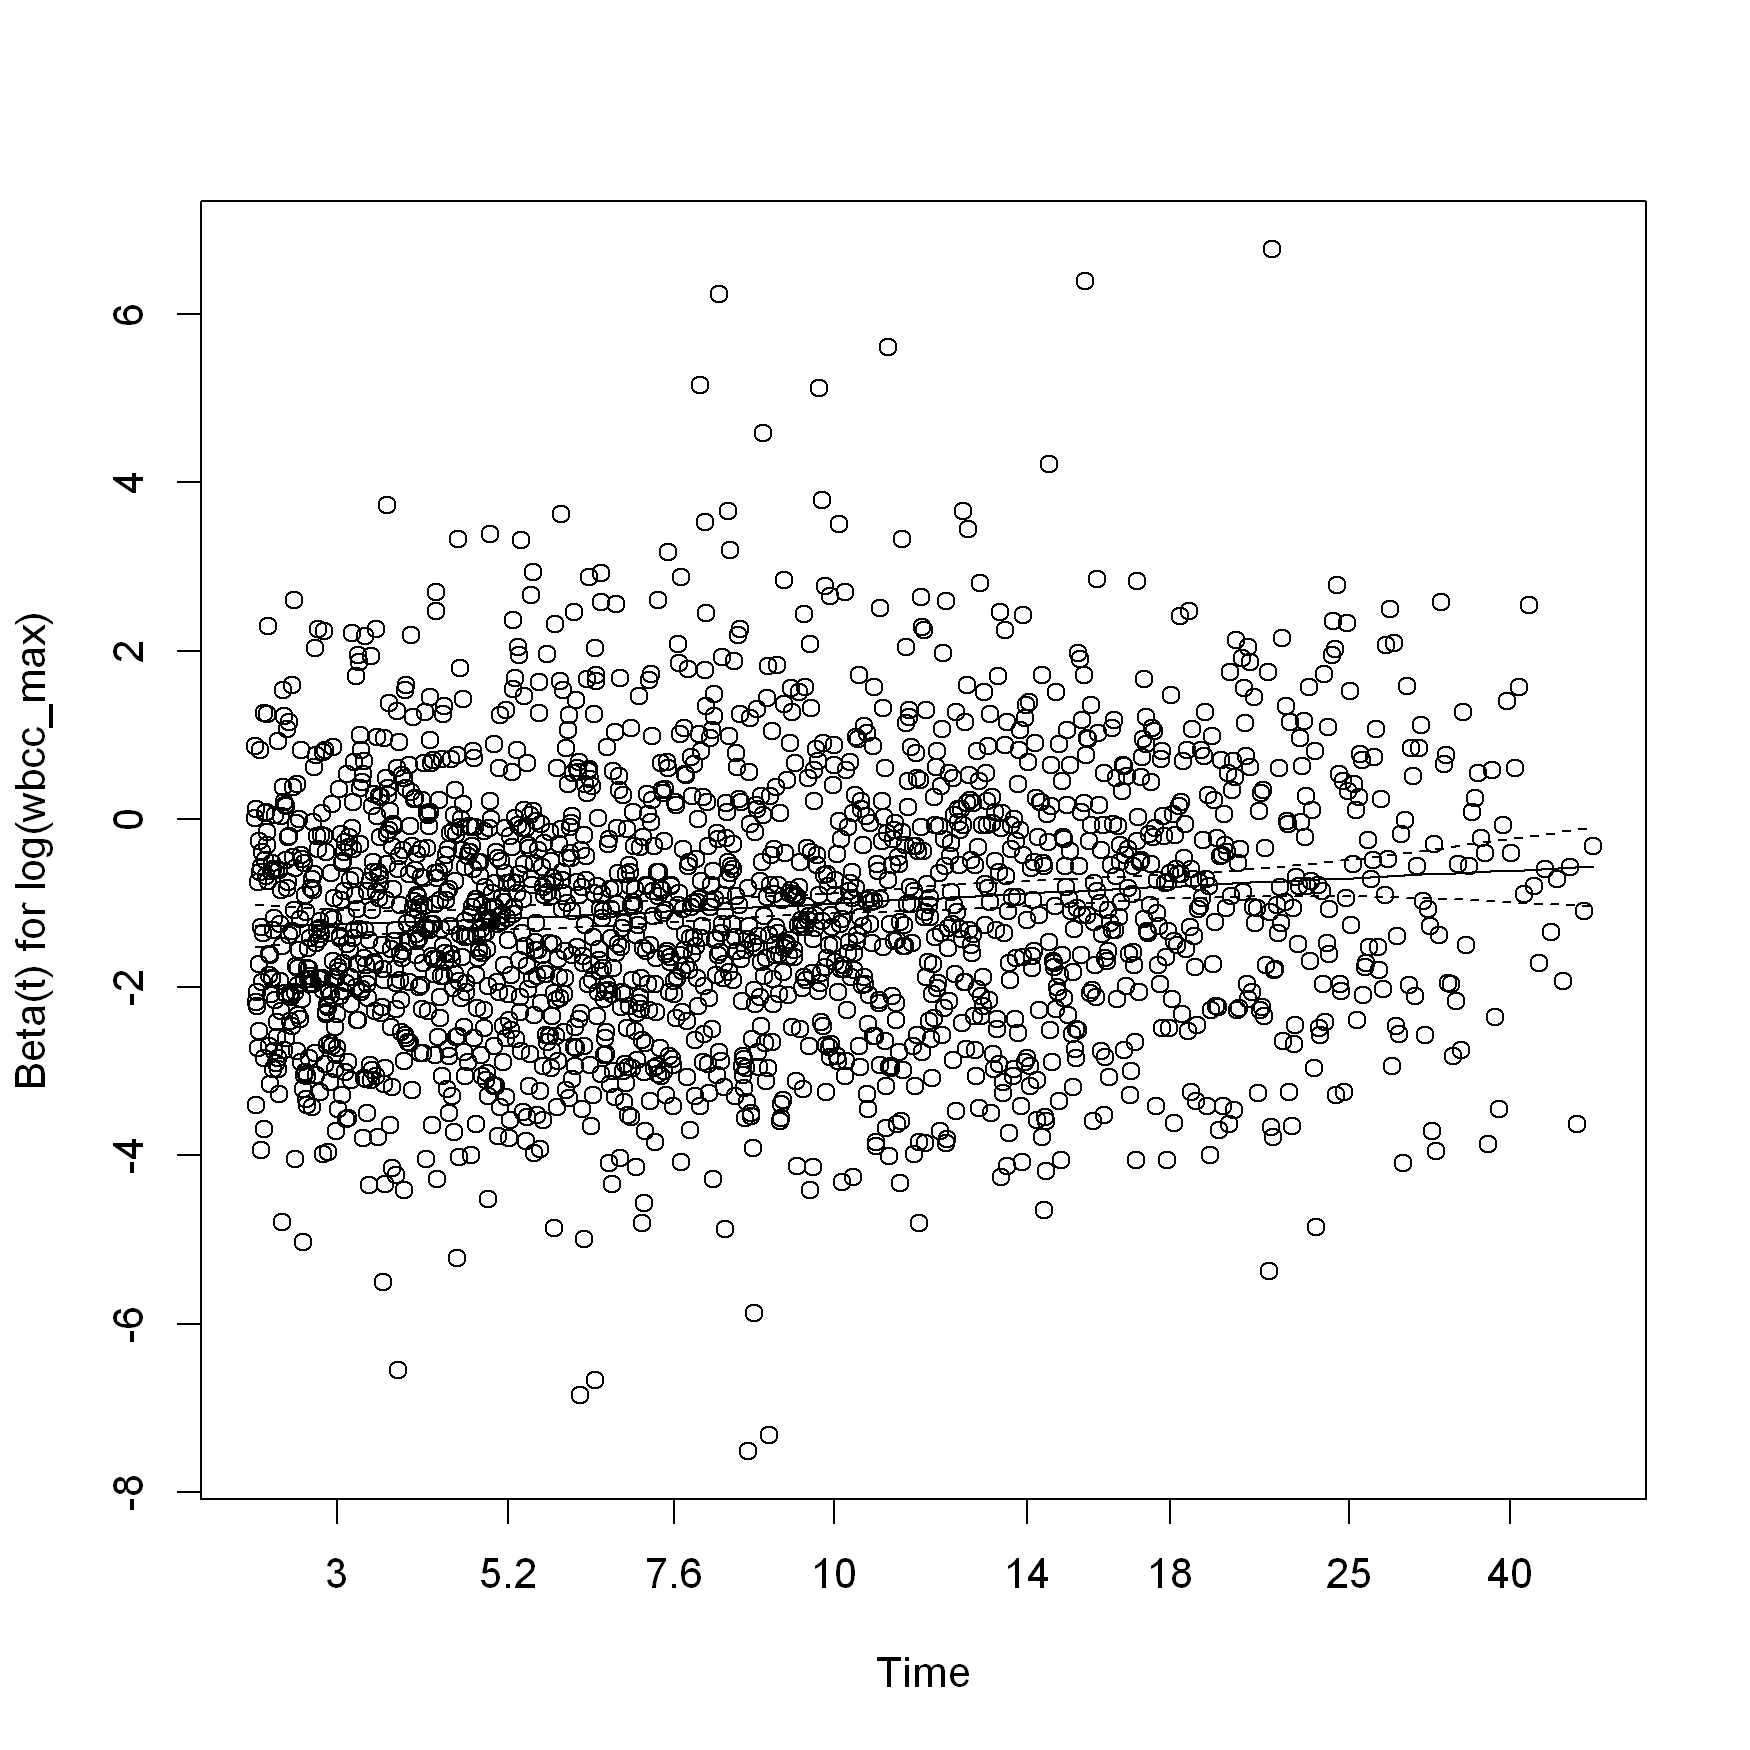

In [215]:
ph.analysis <- cox.zph(model)
ph.analysis
plot(ph.analysis)

These look approximately fine, so I'd say the PH assumption isn't perfect but good enough for our analysis.

## When PH Fails

What are your options when PH doesn't hold?

- Continue forward with your Cox PH model as usual.  Coefficients now correspond to an "weighted-average hazard ratio", where the weighting scheme is based on the geometric average of the survival functions at the two levels of $x$.  Not super intuitive, so I don't prefer this option.

- Choose a different model to accomodate your fixed covariates.  Perhaps consider an AFT model.  If that also doesn't work, consult your local statistician for more bespoke modeling.

- Try the Cox PH model with time-varying covariates.  Sometimes the use of covariate information collected after time zero can help fix things as well as improve your predictive ability.  You will still have time-zero covariates, but now your linear model will make use of covariate information at time $t$ as well.  For example
$$ \log \lambda(t, x_1, x_2) = \beta_0(t) + \beta_1 x_1 + \beta_2 x_2(t) $$
where $x_2(t)$ indexes the most recent measurement up till time $t$.